<a href="https://colab.research.google.com/github/ahmedengu/feature_importance/blob/master/Stocks/France/Valeo/Valeo_1H_High.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from IPython.display import clear_output
import pandas as pd

if pd.__version__ != '0.25.0' or False:
  # install
  !apt-get install default-jre build-essential swig
  !pip  install h2o==3.24.0.5 yfinance==0.1.43
  !pip  install git+https://github.com/ahmedengu/findatapy.git pandas==0.25.0
  clear_output(wait=True)

  !wget http://prdownloads.sourceforge.net/ta-lib/ta-lib-0.4.0-src.tar.gz
  !tar -xzvf ta-lib-0.4.0-src.tar.gz
  %cd ta-lib
  !./configure --prefix=/usr
  clear_output(wait=True)
  !make
  clear_output(wait=True)
  !make install
  clear_output(wait=True)
  !pip install Ta-Lib==0.4.17
  clear_output(wait=True)
  print('RESTARTING')
  %cd /content
  
  # force restart
  import os
  os.kill(os.getpid(), 9)

In [0]:
# Experiment Config
import pandas as pd
from IPython.display import display
from IPython.core.debugger import set_trace

data_ticker = "FRFREUR"
data_resample = '1H'
data_label = 'High'
data_label_name = 'y'
start_date = '1 Jan 2018'
finish_date = '1 Jan 2019'
is_duka = True
is_yahoo = False
kaggle_file = 'bitstamp' # default None
kaggle_folder = '1 Day/Stocks'

models_summary = {}
for metric in ['accuracy','F1','auc','logloss','mean_per_class_error','rmse','mse']:
  models_summary.update({metric:pd.DataFrame()})

# feature elimination config
model_selected_features = 50
PCA_k = 50
HCF_threshold = 0.90
LVF_threshold = 0.1
GLRM_k = 20
select_k = 50
select_percentile = 10
select_alpha = 0.1
select_rfe = 50

features_to_include = ['All', 'DLF', 'XGBF', 'RFE', 'Fwe'] # True for all , ['All','Fwe','RFE','Percentile','KBest','LVF','HCF','PCA','XGBF','GLMF','DLF','GLRM'] 
is_EDA = True
max_models_num = 10

# pandas options
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

In [3]:
# random seed
from numpy.random import seed
seed(1)
from tensorflow import set_random_seed
set_random_seed(1)
import pandas as pd
import gc
import os

resample_how= {'Open': 'first', 'High': 'max', 'Low': 'min', 'Close': 'last',
                             'Volume': 'sum', 'Date': 'first'}

if is_duka:
  from findatapy.util import DataConstants

  DataConstants.market_thread_no.update({'dukascopy': 64})

  # Download dataset
  from findatapy.market import Market, MarketDataRequest, MarketDataGenerator

  market = Market(market_data_generator=MarketDataGenerator(log_every_day=30))

  md_request = MarketDataRequest(start_date=start_date, finish_date=finish_date,
                                       fields=['temp', 'ask', 'bid', 'askv', 'bidv'], vendor_fields=['temp', 'ask', 'bid', 'askv', 'bidv'],
                                       freq='tick', data_source='dukascopy',
                                       tickers=[data_ticker], vendor_tickers=[data_ticker])

  temp_dataset = market.fetch_market(md_request)
  full_dataset = pd.DataFrame(temp_dataset[data_ticker + '.bid'].resample(data_resample).ohlc())
  full_dataset.columns = ['Open', 'High', 'Low', 'Close']
  temp_dataset = pd.DataFrame(temp_dataset[data_ticker + '.bidv'].resample(data_resample).sum())
  temp_dataset.columns = ['Volume']
  full_dataset['Volume'] = temp_dataset['Volume']

  del temp_dataset, md_request, market, DataConstants, Market, MarketDataRequest, MarketDataGenerator

  gc.collect()

elif is_yahoo:
  import yfinance as yf
  from datetime import datetime

  full_dataset = yf.download(data_ticker, start=str(datetime.strptime(start_date, '%d %b %Y')).split(' ')[0], end=str(datetime.strptime(finish_date, '%d %b %Y')).split(' ')[0])
  full_dataset['Date']=full_dataset.index
  del yf,datetime

elif data_ticker == 'EURUSD':
  !wget -q https://github.com/philipperemy/FX-1-Minute-Data/raw/master/2000-Jun2019/eurusd/DAT_ASCII_EURUSD_M1_2014.zip
  !wget -q https://github.com/philipperemy/FX-1-Minute-Data/raw/master/2000-Jun2019/eurusd/DAT_ASCII_EURUSD_M1_2015.zip
  !wget -q https://github.com/philipperemy/FX-1-Minute-Data/raw/master/2000-Jun2019/eurusd/DAT_ASCII_EURUSD_M1_2016.zip
  !wget -q https://github.com/philipperemy/FX-1-Minute-Data/raw/master/2000-Jun2019/eurusd/DAT_ASCII_EURUSD_M1_2017.zip
  !wget -q https://github.com/philipperemy/FX-1-Minute-Data/raw/master/2000-Jun2019/eurusd/DAT_ASCII_EURUSD_M1_2018.zip
  !unzip -qq -o \*.zip
  full_dataset = pd.read_csv('DAT_ASCII_EURUSD_M1_2014.csv',names=['Date','Open', 'High', 'Low', 'Close','Volume'], delimiter=';')
  full_dataset = full_dataset.append(pd.read_csv('DAT_ASCII_EURUSD_M1_2015.csv',names=['Date','Open', 'High', 'Low', 'Close','Volume'], delimiter=';'))
  full_dataset = full_dataset.append(pd.read_csv('DAT_ASCII_EURUSD_M1_2016.csv',names=['Date','Open', 'High', 'Low', 'Close','Volume'], delimiter=';'))
  full_dataset = full_dataset.append(pd.read_csv('DAT_ASCII_EURUSD_M1_2017.csv',names=['Date','Open', 'High', 'Low', 'Close','Volume'], delimiter=';'))
  full_dataset = full_dataset.append(pd.read_csv('DAT_ASCII_EURUSD_M1_2018.csv',names=['Date','Open', 'High', 'Low', 'Close','Volume'], delimiter=';'))
  full_dataset['Date'] = pd.to_datetime(full_dataset['Date'])
  full_dataset.index = full_dataset['Date']
  full_dataset = full_dataset.dropna()
  full_dataset = full_dataset.sort_index()
  full_dataset = full_dataset.resample(data_resample, how=resample_how).dropna()
  full_dataset = full_dataset[full_dataset.index > start_date]
  full_dataset = full_dataset[full_dataset.index < finish_date]


    
elif data_ticker == 'APPLUSUSD':
  full_dataset=pd.read_csv('https://github.com/kyleconroy/apple-stock/raw/master/apple_stock_data.csv',index_col =0,parse_dates =[0])

  full_dataset = full_dataset.astype(float)
  full_dataset['Date']=full_dataset.index
  full_dataset = full_dataset[full_dataset.index > '2007-04-01']


elif data_ticker == 'COMI':
  full_dataset=pd.read_csv('https://static.mubasher.info/File.MubasherCharts/File.Historical_Stock_Charts_Dir/44507230b2b03e2da37352abf1a659545b44.csv',index_col =0,names =['Open', 'High', 'Low', 'Close','Volume'],parse_dates =[0])

  full_dataset = full_dataset.astype(float)
  full_dataset['Volume'] = full_dataset['Volume'] * full_dataset['Close'] 
  full_dataset = full_dataset.drop_duplicates()
  full_dataset['Date']=full_dataset.index
  full_dataset = full_dataset[full_dataset.index > start_date]
  full_dataset = full_dataset[full_dataset.index < finish_date]
  
elif kaggle_file is not None:
  if not os.path.isfile('kaggle.json'):
    from google.colab import files
    files.upload()
    
    import time
    time.sleep(10)
    !ls
    !mkdir -p ~/.kaggle
    !cp kaggle.json ~/.kaggle/
    !ls ~/.kaggle

    !chmod 600 /root/.kaggle/kaggle.json
    del files
    
  !kaggle datasets download $data_ticker
  !unzip -qq -o \*.zip
  !unzip -qq -o \*.zip

  if data_ticker == 'mczielinski/bitcoin-historical-data':
    
    full_dataset = pd.read_csv([file for file in os.listdir() if kaggle_file in file][0])
    full_dataset.columns= ['Date', 'Open', 'High', 'Low', 'Close', 'Volume', 'Volume_(Currency)','Weighted_Price']
    full_dataset.index=pd.to_datetime(full_dataset['Date'], unit='s')

    resample_how.update({'Volume_(Currency)': 'sum', 'Weighted_Price': 'last'})

    full_dataset = full_dataset.resample(data_resample, how=resample_how).dropna()[1:-1]
    full_dataset = full_dataset[full_dataset.index > start_date]
    full_dataset = full_dataset[full_dataset.index < finish_date]
  
  elif data_ticker == 'borismarjanovic/daily-and-intraday-stock-price-data':
    
    full_dataset = pd.read_csv(kaggle_folder + '/' + [file for file in os.listdir(kaggle_folder) if kaggle_file in file][0])
    if 'Time' in full_dataset.columns:
      full_dataset['Date'] = pd.to_datetime(full_dataset['Date'] + ' ' + full_dataset['Time'])
      full_dataset = full_dataset.drop('Time',axis=1)
    full_dataset.columns= ['Date', 'Open', 'High', 'Low', 'Close', 'Volume', 'OpenInt']
    full_dataset.index=pd.to_datetime(full_dataset['Date'])

    full_dataset = full_dataset[full_dataset.index > start_date]
    full_dataset = full_dataset[full_dataset.index < finish_date]

  
gc.collect()
full_dataset = full_dataset.dropna()

full_dataset = full_dataset.drop('Date',axis=1, errors='ignore')
full_dataset = full_dataset.sort_index()
full_dataset = full_dataset[-100000:]
display(full_dataset)
display(full_dataset.describe())
full_dataset.to_pickle('full_dataset')
del full_dataset, set_random_seed, seed
gc.collect()

2019-08-27 20:16:12,520 - findatapy.market.datavendorweb - INFO - Request Dukascopy data
2019-08-27 20:16:12,522 - findatapy.market.datavendorweb - INFO - About to download from Dukascopy... for FRFREUR
2019-08-27 20:16:57,448 - findatapy.market.datavendorweb - INFO - Downloading... 2018-01-30 00:00:00
2019-08-27 20:18:31,808 - findatapy.market.datavendorweb - INFO - Downloading... 2018-03-30 00:00:00
2019-08-27 20:19:21,387 - findatapy.market.datavendorweb - INFO - Downloading... 2018-04-30 00:00:00
2019-08-27 20:20:09,396 - findatapy.market.datavendorweb - INFO - Downloading... 2018-05-30 00:00:00
2019-08-27 20:20:58,999 - findatapy.market.datavendorweb - INFO - Downloading... 2018-06-30 00:00:00
2019-08-27 20:22:02,130 - findatapy.market.datavendorweb - INFO - Downloading... 2018-07-30 00:00:00
2019-08-27 20:23:12,093 - findatapy.market.datavendorweb - INFO - Downloading... 2018-08-30 00:00:00
2019-08-27 20:24:23,005 - findatapy.market.datavendorweb - INFO - Downloading... 2018-09-3

/usr/local/lib/python3.6/dist-packages/findatapy/market/ioengine.py:264: FutureWarning: to_msgpack is deprecated and will be removed in a future version.
It is recommended to use pyarrow for on-the-wire transmission of pandas objects.
  r.set(fname, data_frame.to_msgpack(compress='blosc'))


2019-08-27 20:27:59,580 - findatapy.market.ioengine - WARNING - Couldn't push MarketDataRequest_439__abstract_curve_key-None__category-None__category_key-backtest_default-cat_dukascopy_tick_NYC_FRFREUR__cut-NYC__data_source-dukascopy__environment-backtest__expiry_date-NaT__fields-temp_ask_bid_askv_bidv__finish_date-2019-01-01 00:00:00__freq-tick__freq_mult-1__gran_freq-None__resample-None__resample_how-last__start_date-2018-01-01 00:00:00__tickers-FRFREUR__trade_side-trade__vendor_fields-temp_ask_bid_askv_bidv__vendor_tickers-FRFREUR to Redis: Error 111 connecting to 127.0.0.1:6379. Connection refused.


Open     High      Low    Close    Volume
Date                                                             
2018-01-02 08:00:00  0.61948  0.61957  0.60987  0.61077  4.031731
2018-01-02 09:00:00  0.61078  0.61098  0.60597  0.60678  3.001442
2018-01-02 10:00:00  0.60677  0.61018  0.60628  0.60828  2.053729
2018-01-02 11:00:00  0.60837  0.60938  0.60807  0.60897  1.192205
2018-01-02 12:00:00  0.60898  0.61238  0.60898  0.61178  1.009956
...                      ...      ...      ...      ...       ...
2018-12-31 08:00:00  0.24707  0.24848  0.24597  0.24628  2.720639
2018-12-31 09:00:00  0.24618  0.25208  0.24618  0.25198  1.827814
2018-12-31 10:00:00  0.25198  0.25358  0.24998  0.25358  2.488293
2018-12-31 11:00:00  0.25358  0.25487  0.25307  0.25458  2.480777
2018-12-31 12:00:00  0.25467  0.25628  0.25417  0.25487  2.861934

[2277 rows x 5 columns]

Open         High          Low        Close       Volume
count  2277.000000  2277.000000  2277.000000  2277.000000  2277.000000
mean      0.458736     0.460441     0.457022     0.458688     3.417678
std       0.128589     0.128572     0.128729     0.128655     2.267427
min       0.230080     0.234180     0.226670     0.230170     0.000225
25%       0.360170     0.361780     0.359070     0.360180     1.827235
50%       0.490970     0.492380     0.490070     0.491170     2.789097
75%       0.553170     0.554770     0.551480     0.553370     4.333906
max       0.661180     0.664070     0.660570     0.661980    22.968575

25

In [4]:
# OHLC EDA
if is_EDA:
  import pandas_profiling as pp
  display(pp.ProfileReport(pd.read_pickle('full_dataset')))
  del pp

/usr/local/lib/python3.6/dist-packages/pandas/plotting/_matplotlib/converter.py:102: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/pandas_profiling/describe.py:392: FutureWarning: The join_axes-keyword is deprecated. Use .reindex or .reindex_like on the result to achieve the same functionality.
  variable_stats = pd.concat(ldesc, join_axes=pd.Index([names]), axis=1)


In [5]:
# features
from talib._ta_lib import *
import talib
import numpy as np
import uuid
import os


features_dataset = pd.read_pickle('full_dataset').sort_index()


periods = np.resize([2, 3, 3, 2], len(features_dataset['Close'])).astype(float)
timeperiods = [8, 12, 14, 20, 24, 30]
matypes = range(9)
nbdevs = [2, 3, 4, 5]

# date features
features_dataset['day'] = features_dataset.index.day
features_dataset['dayofweek'] = features_dataset.index.dayofweek
features_dataset['dayofyear'] = features_dataset.index.dayofyear
features_dataset['days_in_month'] = features_dataset.index.days_in_month
features_dataset['hour'] = features_dataset.index.hour
features_dataset['is_month_end'] = pd.factorize(features_dataset.index.is_month_end)[0]
features_dataset['is_month_start'] = pd.factorize(features_dataset.index.is_month_start)[0]
features_dataset['is_quarter_end'] = pd.factorize(features_dataset.index.is_quarter_end)[0]
features_dataset['is_quarter_start'] = pd.factorize(features_dataset.index.is_quarter_start)[0]
features_dataset['minute'] = features_dataset.index.minute
features_dataset['month'] = features_dataset.index.month
features_dataset['quarter'] = features_dataset.index.quarter
features_dataset['second'] = features_dataset.index.second
features_dataset['week'] = features_dataset.index.week
features_dataset['weekday'] = features_dataset.index.weekday
features_dataset['weekday_name'] = pd.factorize(features_dataset.index.weekday_name)[0]
features_dataset['weekofyear'] = features_dataset.index.weekofyear

# Overlap Studies
features_dataset['HT_TRENDLINE'] = HT_TRENDLINE(features_dataset['Close'])
features_dataset['mama'], features_dataset['fama'] = MAMA(features_dataset['Close'])
features_dataset['SAREXT'] = SAREXT(features_dataset['High'], features_dataset['Low'], startvalue=-4e37,
                                    offsetonreverse=-4e37, accelerationinitlong=-4e37,
                                    accelerationlong=-4e37, accelerationmaxlong=-4e37, accelerationinitshort=-4e37,
                                    accelerationshort=-4e37, accelerationmaxshort=-4e37)

for timeperiod in timeperiods:
    features_dataset['DEMA_' + str(timeperiod)] = DEMA(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['EMA_' + str(timeperiod)] = EMA(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['KAMA_' + str(timeperiod)] = KAMA(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['MIDPOINT_' + str(timeperiod)] = MIDPOINT(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['MIDPRICE_' + str(timeperiod)] = MIDPRICE(features_dataset['High'], features_dataset['Low'],
                                                               timeperiod=timeperiod)
    features_dataset['SAR_' + str(timeperiod / 100)] = SAR(features_dataset['High'], features_dataset['Low'],
                                                           acceleration=timeperiod / 100,
                                                           maximum=timeperiod / 100)
    features_dataset['SMA_' + str(timeperiod)] = SMA(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['TEMA_' + str(timeperiod)] = TEMA(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['TRIMA_' + str(timeperiod)] = TRIMA(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['WMA_' + str(timeperiod)] = WMA(features_dataset['Close'], timeperiod=timeperiod)

    for matype in matypes:
        features_dataset['MA_' + str(timeperiod) + '_' + str(matype)] = MA(features_dataset['Close'],
                                                                           timeperiod=timeperiod, matype=matype)
        features_dataset['MAVP_' + str(timeperiod) + '_' + str(matype)] = MAVP(features_dataset['Close'], periods,
                                                                               minperiod=2,
                                                                               maxperiod=timeperiod, matype=matype)
        features_dataset['T3_' + str(timeperiod) + '_' + str(matype)] = T3(features_dataset['Close'],
                                                                           timeperiod=timeperiod,
                                                                           vfactor=matype / 10)

        for nbdev in nbdevs:
            features_dataset['BBANDS_upperband_' + str(timeperiod) + '_' + str(matype) + '_' + str(nbdev)], \
            features_dataset['BBANDS_middleband_' + str(timeperiod) + '_' + str(matype) + '_' + str(nbdev)], \
            features_dataset['BBANDS_lowerband_' + str(timeperiod) + '_' + str(matype) + '_' + str(nbdev)] = BBANDS(
                features_dataset['Close'], timeperiod=timeperiod, nbdevup=nbdev, nbdevdn=nbdev, matype=matype)

            
gc.collect()
# Momentum Indicators
features_dataset['BOP'] = BOP(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                              features_dataset['Close'])

for timeperiod in timeperiods:
    features_dataset['ADX_' + str(timeperiod)] = ADX(features_dataset['High'], features_dataset['Low'],
                                                     features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['ADXR_' + str(timeperiod)] = ADXR(features_dataset['High'], features_dataset['Low'],
                                                       features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['aroondown_' + str(timeperiod)], features_dataset['aroonup_' + str(timeperiod)] = AROON(
        features_dataset['High'],
        features_dataset['Low'],
        timeperiod=timeperiod)
    features_dataset['AROONOSC_' + str(timeperiod)] = AROONOSC(features_dataset['High'], features_dataset['Low'],
                                                               timeperiod=timeperiod)
    features_dataset['CCI_' + str(timeperiod)] = CCI(features_dataset['High'], features_dataset['Low'],
                                                     features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['CMO_' + str(timeperiod)] = CMO(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['DX_' + str(timeperiod)] = DX(features_dataset['High'], features_dataset['Low'],
                                                   features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['MACDFIX_' + str(timeperiod)], features_dataset['MACDFIX_signal_' + str(timeperiod)], features_dataset[
        'MACDFIX_hist_' + str(timeperiod)] = MACDFIX(features_dataset['Close'], signalperiod=timeperiod)
    features_dataset['MFI_' + str(timeperiod)] = MFI(features_dataset['High'], features_dataset['Low'],
                                                     features_dataset['Close'], features_dataset['Volume'],
                                                     timeperiod=timeperiod)
    features_dataset['MINUS_DI_' + str(timeperiod)] = MINUS_DI(features_dataset['High'], features_dataset['Low'],
                                                               features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['MINUS_DM_' + str(timeperiod)] = MINUS_DM(features_dataset['High'], features_dataset['Low'],
                                                               timeperiod=timeperiod)
    features_dataset['MOM_' + str(timeperiod)] = MOM(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['PLUS_DI_' + str(timeperiod)] = PLUS_DI(features_dataset['High'], features_dataset['Low'],
                                                             features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['PLUS_DM_' + str(timeperiod)] = PLUS_DM(features_dataset['High'], features_dataset['Low'],
                                                             timeperiod=timeperiod)
    features_dataset['ROC_' + str(timeperiod)] = ROC(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['ROCP_' + str(timeperiod)] = ROCP(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['ROCR_' + str(timeperiod)] = ROCR(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['ROCR100_' + str(timeperiod)] = ROCR100(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['RSI_' + str(timeperiod)] = RSI(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['TRIX_' + str(timeperiod)] = TRIX(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['WILLR_' + str(timeperiod)] = WILLR(features_dataset['High'], features_dataset['Low'],
                                                         features_dataset['Close'], timeperiod=timeperiod)

    
gc.collect()
features_dataset['APO'] = APO(features_dataset['Close'], fastperiod=12, slowperiod=26, matype=0)

features_dataset['MACD'], features_dataset['MACD_signal'], features_dataset['MACD_hist'] = MACD(
    features_dataset['Close'], fastperiod=12,
    slowperiod=26,
    signalperiod=9)
features_dataset['MACDEXT'], features_dataset['MACDEXT_signal'], features_dataset['MACDEXT_hist'] = MACDEXT(
    features_dataset['Close'],
    fastperiod=12,
    fastmatype=0,
    slowperiod=26,
    slowmatype=0,
    signalperiod=9,
    signalmatype=0)

features_dataset['PPO'] = PPO(features_dataset['Close'], fastperiod=12, slowperiod=26, matype=0)

features_dataset['STOCH_slowk'], features_dataset['STOCH_slowd'] = STOCH(features_dataset['High'],
                                                                         features_dataset['Low'],
                                                                         features_dataset['Close'], fastk_period=5,
                                                                         slowk_period=3, slowk_matype=0,
                                                                         slowd_period=3, slowd_matype=0)
features_dataset['STOCHF_fastk'], features_dataset['STOCHF_fastd'] = STOCHF(features_dataset['High'],
                                                                            features_dataset['Low'],
                                                                            features_dataset['Close'], fastk_period=5,
                                                                            fastd_period=3, fastd_matype=0)
features_dataset['STOCHRSI_fastk'], features_dataset['STOCHRSI_fastd'] = STOCHRSI(features_dataset['Close'],
                                                                                  timeperiod=14,
                                                                                  fastk_period=5, fastd_period=3,
                                                                                  fastd_matype=0)
features_dataset['ULTOSC'] = ULTOSC(features_dataset['High'], features_dataset['Low'], features_dataset['Close'],
                                    timeperiod1=7, timeperiod2=14, timeperiod3=28)

# Volume Indicators
features_dataset['AD'] = AD(features_dataset['High'], features_dataset['Low'], features_dataset['Close'],
                            features_dataset['Volume'])
features_dataset['ADOSC'] = ADOSC(features_dataset['High'], features_dataset['Low'], features_dataset['Close'],
                                  features_dataset['Volume'], fastperiod=3, slowperiod=10)
features_dataset['OBV'] = OBV(features_dataset['Close'], features_dataset['Volume'])

gc.collect()
# Volatility Indicators
for timeperiod in timeperiods:
    features_dataset['ATR_' + str(timeperiod)] = ATR(features_dataset['High'], features_dataset['Low'],
                                                     features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['NATR_' + str(timeperiod)] = NATR(features_dataset['High'], features_dataset['Low'],
                                                       features_dataset['Close'], timeperiod=timeperiod)

features_dataset['TRANGE'] = TRANGE(features_dataset['High'], features_dataset['Low'], features_dataset['Close'])

# Price Transform
features_dataset['AVGPRICE'] = AVGPRICE(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                        features_dataset['Close'])
features_dataset['MEDPRICE'] = MEDPRICE(features_dataset['High'], features_dataset['Low'])
features_dataset['TYPPRICE'] = TYPPRICE(features_dataset['High'], features_dataset['Low'], features_dataset['Close'])
features_dataset['WCLPRICE'] = WCLPRICE(features_dataset['High'], features_dataset['Low'], features_dataset['Close'])

gc.collect()
# Cycle Indicators
features_dataset['HT_DCPERIOD'] = HT_DCPERIOD(features_dataset['Close'])
features_dataset['HT_DCPHASE'] = HT_DCPHASE(features_dataset['Close'])
features_dataset['HT_PHASOR_inphase'], features_dataset['HT_PHASOR_quadrature'] = HT_PHASOR(features_dataset['Close'])
features_dataset['HT_SINE_sine'], features_dataset['HT_SINE_leadsine'] = HT_SINE(features_dataset['Close'])
features_dataset['HT_TRENDMODE'] = HT_TRENDMODE(features_dataset['Close'])

# Pattern Recognition
features_dataset['CDL2CROWS'] = CDL2CROWS(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                          features_dataset['Close'])
features_dataset['CDL3BLACKCROWS'] = CDL3BLACKCROWS(features_dataset['Open'], features_dataset['High'],
                                                    features_dataset['Low'], features_dataset['Close'])
features_dataset['CDL3INSIDE'] = CDL3INSIDE(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                            features_dataset['Close'])
features_dataset['CDL3LINESTRIKE'] = CDL3LINESTRIKE(features_dataset['Open'], features_dataset['High'],
                                                    features_dataset['Low'], features_dataset['Close'])
features_dataset['CDL3OUTSIDE'] = CDL3OUTSIDE(features_dataset['Open'], features_dataset['High'],
                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDL3STARSINSOUTH'] = CDL3STARSINSOUTH(features_dataset['Open'], features_dataset['High'],
                                                        features_dataset['Low'], features_dataset['Close'])
features_dataset['CDL3WHITESOLDIERS'] = CDL3WHITESOLDIERS(features_dataset['Open'], features_dataset['High'],
                                                          features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLABANDONEDBABY'] = CDLABANDONEDBABY(features_dataset['Open'], features_dataset['High'],
                                                        features_dataset['Low'], features_dataset['Close'],
                                                        penetration=0)
features_dataset['CDLADVANCEBLOCK'] = CDLADVANCEBLOCK(features_dataset['Open'], features_dataset['High'],
                                                      features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLBELTHOLD'] = CDLBELTHOLD(features_dataset['Open'], features_dataset['High'],
                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLBREAKAWAY'] = CDLBREAKAWAY(features_dataset['Open'], features_dataset['High'],
                                                features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLCLOSINGMARUBOZU'] = CDLCLOSINGMARUBOZU(features_dataset['Open'], features_dataset['High'],
                                                            features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLCONCEALBABYSWALL'] = CDLCONCEALBABYSWALL(features_dataset['Open'], features_dataset['High'],
                                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLCOUNTERATTACK'] = CDLCOUNTERATTACK(features_dataset['Open'], features_dataset['High'],
                                                        features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLDARKCLOUDCOVER'] = CDLDARKCLOUDCOVER(features_dataset['Open'], features_dataset['High'],
                                                          features_dataset['Low'], features_dataset['Close'],
                                                          penetration=0)
features_dataset['CDLDOJI'] = CDLDOJI(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                      features_dataset['Close'])
features_dataset['CDLDOJISTAR'] = CDLDOJISTAR(features_dataset['Open'], features_dataset['High'],
                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLDRAGONFLYDOJI'] = CDLDRAGONFLYDOJI(features_dataset['Open'], features_dataset['High'],
                                                        features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLENGULFING'] = CDLENGULFING(features_dataset['Open'], features_dataset['High'],
                                                features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLEVENINGDOJISTAR'] = CDLEVENINGDOJISTAR(features_dataset['Open'], features_dataset['High'],
                                                            features_dataset['Low'], features_dataset['Close'],
                                                            penetration=0)
features_dataset['CDLEVENINGSTAR'] = CDLEVENINGSTAR(features_dataset['Open'], features_dataset['High'],
                                                    features_dataset['Low'], features_dataset['Close'], penetration=0)
features_dataset['CDLGAPSIDESIDEWHITE'] = CDLGAPSIDESIDEWHITE(features_dataset['Open'], features_dataset['High'],
                                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLGRAVESTONEDOJI'] = CDLGRAVESTONEDOJI(features_dataset['Open'], features_dataset['High'],
                                                          features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLHAMMER'] = CDLHAMMER(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                          features_dataset['Close'])
features_dataset['CDLHANGINGMAN'] = CDLHANGINGMAN(features_dataset['Open'], features_dataset['High'],
                                                  features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLHARAMI'] = CDLHARAMI(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                          features_dataset['Close'])
features_dataset['CDLHARAMICROSS'] = CDLHARAMICROSS(features_dataset['Open'], features_dataset['High'],
                                                    features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLHIGHWAVE'] = CDLHIGHWAVE(features_dataset['Open'], features_dataset['High'],
                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLHIKKAKE'] = CDLHIKKAKE(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                            features_dataset['Close'])
features_dataset['CDLHIKKAKEMOD'] = CDLHIKKAKEMOD(features_dataset['Open'], features_dataset['High'],
                                                  features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLHOMINGPIGEON'] = CDLHOMINGPIGEON(features_dataset['Open'], features_dataset['High'],
                                                      features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLIDENTICAL3CROWS'] = CDLIDENTICAL3CROWS(features_dataset['Open'], features_dataset['High'],
                                                            features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLINNECK'] = CDLINNECK(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                          features_dataset['Close'])
features_dataset['CDLINVERTEDHAMMER'] = CDLINVERTEDHAMMER(features_dataset['Open'], features_dataset['High'],
                                                          features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLKICKING'] = CDLKICKING(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                            features_dataset['Close'])
features_dataset['CDLKICKINGBYLENGTH'] = CDLKICKINGBYLENGTH(features_dataset['Open'], features_dataset['High'],
                                                            features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLLADDERBOTTOM'] = CDLLADDERBOTTOM(features_dataset['Open'], features_dataset['High'],
                                                      features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLLONGLEGGEDDOJI'] = CDLLONGLEGGEDDOJI(features_dataset['Open'], features_dataset['High'],
                                                          features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLLONGLINE'] = CDLLONGLINE(features_dataset['Open'], features_dataset['High'],
                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLMARUBOZU'] = CDLMARUBOZU(features_dataset['Open'], features_dataset['High'],
                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLMATCHINGLOW'] = CDLMATCHINGLOW(features_dataset['Open'], features_dataset['High'],
                                                    features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLMATHOLD'] = CDLMATHOLD(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                            features_dataset['Close'], penetration=0)
features_dataset['CDLMORNINGDOJISTAR'] = CDLMORNINGDOJISTAR(features_dataset['Open'], features_dataset['High'],
                                                            features_dataset['Low'], features_dataset['Close'],
                                                            penetration=0)
features_dataset['CDLMORNINGSTAR'] = CDLMORNINGSTAR(features_dataset['Open'], features_dataset['High'],
                                                    features_dataset['Low'], features_dataset['Close'], penetration=0)
features_dataset['CDLONNECK'] = CDLONNECK(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                          features_dataset['Close'])
features_dataset['CDLPIERCING'] = CDLPIERCING(features_dataset['Open'], features_dataset['High'],
                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLRICKSHAWMAN'] = CDLRICKSHAWMAN(features_dataset['Open'], features_dataset['High'],
                                                    features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLRISEFALL3METHODS'] = CDLRISEFALL3METHODS(features_dataset['Open'], features_dataset['High'],
                                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLSEPARATINGLINES'] = CDLSEPARATINGLINES(features_dataset['Open'], features_dataset['High'],
                                                            features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLSHOOTINGSTAR'] = CDLSHOOTINGSTAR(features_dataset['Open'], features_dataset['High'],
                                                      features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLSHORTLINE'] = CDLSHORTLINE(features_dataset['Open'], features_dataset['High'],
                                                features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLSPINNINGTOP'] = CDLSPINNINGTOP(features_dataset['Open'], features_dataset['High'],
                                                    features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLSTALLEDPATTERN'] = CDLSTALLEDPATTERN(features_dataset['Open'], features_dataset['High'],
                                                          features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLSTICKSANDWICH'] = CDLSTICKSANDWICH(features_dataset['Open'], features_dataset['High'],
                                                        features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLTAKURI'] = CDLTAKURI(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                          features_dataset['Close'])
features_dataset['CDLTASUKIGAP'] = CDLTASUKIGAP(features_dataset['Open'], features_dataset['High'],
                                                features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLTHRUSTING'] = CDLTHRUSTING(features_dataset['Open'], features_dataset['High'],
                                                features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLUNIQUE3RIVER'] = CDLUNIQUE3RIVER(features_dataset['Open'], features_dataset['High'],
                                                      features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLUPSIDEGAP2CROWS'] = CDLUPSIDEGAP2CROWS(features_dataset['Open'], features_dataset['High'],
                                                            features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLXSIDEGAP3METHODS'] = CDLXSIDEGAP3METHODS(features_dataset['Open'], features_dataset['High'],
                                                              features_dataset['Low'], features_dataset['Close'])
gc.collect()

# Statistic Functions
for timeperiod in timeperiods:
    features_dataset['BETA_' + str(timeperiod)] = BETA(features_dataset['High'], features_dataset['Low'],
                                                       timeperiod=timeperiod)
    features_dataset['CORREL_' + str(timeperiod)] = CORREL(features_dataset['High'], features_dataset['Low'],
                                                           timeperiod=timeperiod)
    features_dataset['LINEARREG_' + str(timeperiod)] = LINEARREG(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['LINEARREG_ANGLE_' + str(timeperiod)] = LINEARREG_ANGLE(features_dataset['Close'],
                                                                             timeperiod=timeperiod)
    features_dataset['LINEARREG_INTERCEPT_' + str(timeperiod)] = LINEARREG_INTERCEPT(features_dataset['Close'],
                                                                                     timeperiod=timeperiod)
    features_dataset['LINEARREG_SLOPE_' + str(timeperiod)] = LINEARREG_SLOPE(features_dataset['Close'],
                                                                             timeperiod=timeperiod)
    features_dataset['STDDEV_' + str(timeperiod)] = STDDEV(features_dataset['Close'], timeperiod=timeperiod, nbdev=1)
    features_dataset['TSF_' + str(timeperiod)] = TSF(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['VAR_' + str(timeperiod)] = VAR(features_dataset['Close'], timeperiod=timeperiod, nbdev=1)

    
gc.collect()
# Math Transform
features_dataset['ACOS'] = ACOS(features_dataset['Close'])
features_dataset['ASIN'] = ASIN(features_dataset['Close'])
features_dataset['ATAN'] = ATAN(features_dataset['Close'])
features_dataset['CEIL'] = CEIL(features_dataset['Close'])
features_dataset['COS'] = COS(features_dataset['Close'])
features_dataset['COSH'] = COSH(features_dataset['Close'])
features_dataset['EXP'] = EXP(features_dataset['Close'])
features_dataset['FLOOR'] = FLOOR(features_dataset['Close'])
features_dataset['LN'] = LN(features_dataset['Close'])
features_dataset['LOG10'] = LOG10(features_dataset['Close'])
features_dataset['SIN'] = SIN(features_dataset['Close'])
features_dataset['SINH'] = SINH(features_dataset['Close'])
features_dataset['SQRT'] = SQRT(features_dataset['Close'])
features_dataset['TAN'] = TAN(features_dataset['Close'])
features_dataset['TANH'] = TANH(features_dataset['Close'])

gc.collect()
# Math Operator
features_dataset['ADD'] = ADD(features_dataset['High'], features_dataset['Low'])
features_dataset['DIV'] = DIV(features_dataset['High'], features_dataset['Low'])
features_dataset['MULT'] = MULT(features_dataset['High'], features_dataset['Low'])
features_dataset['SUB'] = SUB(features_dataset['High'], features_dataset['Low'])

for timeperiod in timeperiods:
    features_dataset['MAX_' + str(timeperiod)] = MAX(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['MIN_' + str(timeperiod)] = MIN(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['MINMAX_min_' + str(timeperiod)], features_dataset['MINMAX_max_' + str(timeperiod)] = MINMAX(
        features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['SUM_' + str(timeperiod)] = SUM(features_dataset['Close'], timeperiod=timeperiod)
    
gc.collect()


features_dataset = features_dataset.drop(features_dataset.std()[(features_dataset.std() == 0)].index, axis=1)
features_dataset = features_dataset[50:].replace([np.inf, -np.inf], np.nan).dropna(axis=1)
features_dataset.to_pickle('features_dataset')
display(features_dataset)
display(features_dataset.describe())

for name in dir():
  if any( n in name for n in talib.get_functions()):
    del globals()[name]

del periods, timeperiods, matypes, nbdevs, features_dataset, talib
gc.collect()

Open     High      Low    Close    Volume  day  dayofweek  dayofyear  days_in_month  hour  is_month_end  is_month_start  is_quarter_end  is_quarter_start  month  quarter  week  weekday  weekday_name  weekofyear      mama      fama    SAREXT    DEMA_8     EMA_8    KAMA_8  MIDPOINT_8  MIDPRICE_8  SAR_0.08     SMA_8    TEMA_8   TRIMA_8     WMA_8    MA_8_0  MAVP_8_0    T3_8_0  BBANDS_upperband_8_0_2  BBANDS_middleband_8_0_2  BBANDS_lowerband_8_0_2  BBANDS_upperband_8_0_3  BBANDS_middleband_8_0_3  BBANDS_lowerband_8_0_3  BBANDS_upperband_8_0_4  BBANDS_middleband_8_0_4  BBANDS_lowerband_8_0_4  BBANDS_upperband_8_0_5  BBANDS_middleband_8_0_5  BBANDS_lowerband_8_0_5    MA_8_1  MAVP_8_1    T3_8_1  BBANDS_upperband_8_1_2  BBANDS_middleband_8_1_2  BBANDS_lowerband_8_1_2  BBANDS_upperband_8_1_3  BBANDS_middleband_8_1_3  BBANDS_lowerband_8_1_3  BBANDS_upperband_8_1_4  BBANDS_middleband_8_1_4  BBANDS_lowerband_8_1_4  BBANDS_upperband_8_1_5  BBANDS_middleband_8_1_5  \
Date                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           
2018-01-09 13:00:00  0.66058  0.66258  0.65968  0.66117  2.798919    9          1          9             31    13             0               0               0                 0      1        1     2        1             0           2  0.656349  0.645059  0.648252  0.658869  0.655202  0.656976    0.655470    0.655380  0.649887  0.653825  0.659913  0.653145  0.655803  0.653825  0.658710  0.648911                0.662385                 0.653825                0.645265                0.666665                 0.653825                0.640985                0.670946                 0.653825                0.636705                0.675226                 0.653825                0.632424  0.655202  0.658962  0.649668                0.663762                 0.655202                0.646642                0.668042                 0.655202                0.642362                0.672323                 0.655202                0.638082                0.676603                 0.655202   
2018-01-09 14:00:00  0.66117  0.66300  0.65980  0.66027  4.692843    9          1          9             31    14             0               0               0                 0      1        1     2        1             0           2  0.656545  0.645346  0.649971  0.660057  0.656328  0.658078    0.655575    0.655785  0.650902  0.655138  0.660916  0.654830  0.657235  0.655138  0.660720  0.649731                0.664022                 0.655138                0.646253                0.668464                 0.655138                0.641811                0.672907                 0.655138                0.637368                0.677349                 0.655138                0.632926  0.656328  0.660241  0.650512                0.665213                 0.656328                0.647444                0.669655                 0.656328                0.643002                0.674097                 0.656328                0.638559                0.678540                 0.656328   
2018-01-09 15:00:00  0.66027  0.66160  0.65837  0.66058 

Open         High          Low        Close       Volume          day    dayofweek    dayofyear  days_in_month         hour  is_month_end  is_month_start  is_quarter_end  is_quarter_start        month      quarter         week      weekday  weekday_name   weekofyear         mama         fama       SAREXT       DEMA_8        EMA_8       KAMA_8   MIDPOINT_8   MIDPRICE_8     SAR_0.08        SMA_8       TEMA_8      TRIMA_8        WMA_8       MA_8_0     MAVP_8_0       T3_8_0  BBANDS_upperband_8_0_2  BBANDS_middleband_8_0_2  BBANDS_lowerband_8_0_2  BBANDS_upperband_8_0_3  BBANDS_middleband_8_0_3  BBANDS_lowerband_8_0_3  BBANDS_upperband_8_0_4  BBANDS_middleband_8_0_4  BBANDS_lowerband_8_0_4  BBANDS_upperband_8_0_5  BBANDS_middleband_8_0_5  BBANDS_lowerband_8_0_5       MA_8_1     MAVP_8_1       T3_8_1  BBANDS_upperband_8_1_2  BBANDS_middleband_8_1_2  BBANDS_lowerband_8_1_2  BBANDS_upperband_8_1_3  BBANDS_middleband_8_1_3  BBANDS_lowerband_8_1_3  BBANDS_upperband_8_1_4  \
count  2227.000000  2227.000000  2227.000000  2227.000000  2227.000000  2227.000000  2227.000000  2227.000000    2227.000000  2227.000000   2227.000000     2227.000000     2227.000000       2227.000000  2227.000000  2227.000000  2227.000000  2227.000000   2227.000000  2227.000000  2227.000000  2227.000000  2227.000000  2227.000000  2227.000000  2227.000000  2227.000000  2227.000000  2227.000000  2227.000000  2227.000000  2227.000000  2227.000000  2227.000000  2227.000000  2227.000000             2227.000000              2227.000000             2227.000000             2227.000000              2227.000000             2227.000000             2227.000000              2227.000000             2227.000000             2227.000000              2227.000000             2227.000000  2227.000000  2227.000000  2227.000000             2227.000000              2227.000000             2227.000000             2227.000000              2227.000000             2227.000000             2227.000000   
mean      0.454765     0.456456     0.453043     0.454700     3.444733    16.008981     2.014818   185.370004      30.423889    11.377638      0.034127        0.023799        0.002245          0.004041     6.594971     2.532555    26.933992     2.014818      2.002694    26.933992     0.455141     0.456390    -0.040285     0.454699     0.455333     0.455423     0.455296     0.455287     0.456151     0.455332     0.454699     0.455332     0.455121     0.455332     0.454823     0.456601                0.461072                 0.455332                0.449592                0.463942                 0.455332                0.446722                0.466812                 0.455332                0.443853                0.469681                 0.455332                0.440983     0.455333     0.454831     0.456411                0.461073                 0.455333                0.449594                0.463943                 0.455333                0.446724                0.466813   
std       0.127217     0.127179     0.127349     0.127260     2.281872     8.588470     1.411115   101.886124       0.854103     2.621479      0.181595        0.152456        0.047341          0.063457     3.352639     1.103044    14.555920     1.411115      1.404969    14.555920     0.127187     0.127034     0.471709     0.127306     0.127157     0.127395     0.127193     0.127133     0.127129     0.127193     0.127284     0.127210     0.127210     0.127193     0.127237     0.126993                0.126658                 0.127193                0.127928                0.126465                 0.127193                0.128369                0.126323                 0.127193                0.128858                0.126232                 0.127193                0.129394     0.127157     0.127235     0.127027                0.126606                 0.127157                0.127906                0.126406                 0.127157                0.128355                0.126256   
min       0.230080     0.234180     0.2266

36

In [6]:
# features EDA
if is_EDA:
  import pandas_profiling as pp
  display(pp.ProfileReport(pd.read_pickle('features_dataset')))
  del pp

Output hidden; open in https://colab.research.google.com to view.

In [7]:
# label and scale
import numpy as np
from sklearn.preprocessing import minmax_scale
import os
import pandas as pd

features_dataset = pd.read_pickle('features_dataset')
label_df = features_dataset[[data_label]][:-1]
label_df[data_label_name] = pd.DataFrame(features_dataset[data_label][1:].values / features_dataset[data_label][:-1].values,
                             index=label_df.index).clip(0,1).astype(int)

scaled_df = features_dataset
scaled_df = pd.DataFrame(minmax_scale(scaled_df, axis=0, feature_range=(0, 1)), columns=scaled_df.columns,
                         index=scaled_df.index)
categorical_columns = features_dataset.select_dtypes(exclude=['float64', 'float32', 'float16', 'float_']).columns

scaled_df[categorical_columns] = features_dataset[categorical_columns]
scaled_df = scaled_df[:-1]
scaled_df[data_label_name] = label_df[data_label_name]

display(scaled_df)
scaled_df.to_pickle('scaled_df') 

label_df[-50:].to_pickle('predict_df')
del features_dataset, categorical_columns, scaled_df, label_df, minmax_scale
gc.collect()

Open      High       Low     Close    Volume  day  dayofweek  dayofyear  days_in_month  hour  is_month_end  is_month_start  is_quarter_end  is_quarter_start  month  quarter  week  weekday  weekday_name  weekofyear      mama      fama    SAREXT    DEMA_8     EMA_8    KAMA_8  MIDPOINT_8  MIDPRICE_8  SAR_0.08     SMA_8    TEMA_8   TRIMA_8     WMA_8    MA_8_0  MAVP_8_0    T3_8_0  BBANDS_upperband_8_0_2  BBANDS_middleband_8_0_2  BBANDS_lowerband_8_0_2  BBANDS_upperband_8_0_3  BBANDS_middleband_8_0_3  BBANDS_lowerband_8_0_3  BBANDS_upperband_8_0_4  BBANDS_middleband_8_0_4  BBANDS_lowerband_8_0_4  BBANDS_upperband_8_0_5  BBANDS_middleband_8_0_5  BBANDS_lowerband_8_0_5    MA_8_1  MAVP_8_1    T3_8_1  BBANDS_upperband_8_1_2  BBANDS_middleband_8_1_2  BBANDS_lowerband_8_1_2  BBANDS_upperband_8_1_3  BBANDS_middleband_8_1_3  BBANDS_lowerband_8_1_3  BBANDS_upperband_8_1_4  BBANDS_middleband_8_1_4  BBANDS_lowerband_8_1_4  BBANDS_upperband_8_1_5  BBANDS_middleband_8_1_5  \
Date                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                               
2018-01-09 13:00:00  0.998608  0.996534  0.997949  0.998124  0.121850    9          1          9             31    13             0               0               0                 0      1        1     2        1             0           2  0.992663  0.976703  0.994454  0.992889  0.990935  0.992860    0.992663    0.991174  0.967573  0.985456  0.994230  0.982747  0.989079  0.985456  0.994797  0.980692                0.991456                 0.985456                0.975964                0.980239                 0.985456                0.972225                0.929734                 0.985456                0.968862                0.882701                 0.985456                0.963190  0.990935  0.995148  0.982243                0.993493                 0.990935                0.981849                0.993944                 0.990935                0.977801                0.950748                 0.990935                0.972102                0.901580                 0.990935   
2018-01-09 14:00:00  0.999977  0.997511  0.998225  0.996040  0.204308    9          1          9             31    14             0               0               0                 0      1        1     2        1             0           2  0.993130  0.977398  0.995757  0.995621  0.993611  0.995469    0.992911    0.992128  0.969895  0.988553  0.996531  0.986715  0.992446  0.988553  0.999480  0.982660                0.995301                 0.988553                0.978145                0.984389                 0.988553                0.973956                0.933995                 0.988553                0.970181                0.887044                 0.988553                0.964134  0.993611  0.998137  0.984269                0.996904                 0.993611                0.983610                0.997713                 0.993611                0.979129                0.954682                 0.993611                0.973040                0.905616                 0.993611   
2018-01-09 15:00:00  0.997889  0.994254  

139792

In [8]:
# load data into h2o
import h2o
import pandas as pd
from h2o.automl import H2OAutoML
import uuid
import matplotlib.pyplot as plt
import matplotlib as mpl
import time
import gc
import numpy as np

def load_h2o():
  global train_hf, index_splits
  try:
    h2o.cluster().shutdown()
    time.sleep(5)
  except:
    pass

  h2o.init(min_mem_size="9g",nthreads=-1)
  h2o.remove_all()
  train_hf = h2o.H2OFrame(pd.read_pickle('scaled_df'))
  
  gc.collect()
  train_hf[data_label_name] = train_hf[data_label_name].ascharacter().asfactor()
  index_splits = [int(len(train_hf)*0.7),int(len(train_hf)*0.9)]
  gc.collect()


try:
  load_h2o()
except:
  pass

Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
  Java Version: openjdk version "11.0.4" 2019-07-16; OpenJDK Runtime Environment (build 11.0.4+11-post-Ubuntu-1ubuntu218.04.3); OpenJDK 64-Bit Server VM (build 11.0.4+11-post-Ubuntu-1ubuntu218.04.3, mixed mode, sharing)
  Starting server from /usr/local/lib/python3.6/dist-packages/h2o/backend/bin/h2o.jar
  Ice root: /tmp/tmp2czj2tm3
  JVM stdout: /tmp/tmp2czj2tm3/h2o_unknownUser_started_from_python.out
  JVM stderr: /tmp/tmp2czj2tm3/h2o_unknownUser_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


--------------------------  ---------------------------------------------------
H2O cluster uptime:         02 secs
H2O cluster timezone:       Etc/UTC
H2O data parsing timezone:  UTC
H2O cluster version:        3.24.0.5
H2O cluster version age:    2 months and 8 days
H2O cluster name:           H2O_from_python_unknownUser_0daihs
H2O cluster total nodes:    1
H2O cluster free memory:    9 Gb
H2O cluster total cores:    2
H2O cluster allowed cores:  2
H2O cluster status:         accepting new members, healthy
H2O connection url:         http://127.0.0.1:54321
H2O connection proxy:
H2O internal security:      False
H2O API Extensions:         Amazon S3, XGBoost, Algos, AutoML, Core V3, Core V4
Python version:             3.6.8 final
--------------------------  ---------------------------------------------------

Parse progress: |█████████████████████████████████████████████████████████| 100%


In [0]:
# define the model
%matplotlib inline

def model_train(feature_name='All', model_algo = None,features_list=None,training_frame=None, 
                nfolds=0,max_models=None):
  
  global train_hf, models_summary, features_to_include, max_models_num
  if features_to_include is not True and feature_name not in features_to_include:
    return []
  
  gc.collect()
  model_algo = [model_algo] if isinstance(model_algo,str) else model_algo
  for _ in range(3):
    try:
      aml = H2OAutoML(seed=1, nfolds=nfolds, max_models=(max_models or max_models_num),
                      include_algos=model_algo,project_name=str(uuid.uuid4()))
      t_hf = (training_frame or train_hf)

      aml.train(x=(features_list or list(t_hf.columns[:-1])), y=data_label_name, training_frame=t_hf[:index_splits[0],:], validation_frame=t_hf[index_splits[0]:index_splits[1],:], leaderboard_frame=t_hf[index_splits[1]:,:])
      if aml.leader is None:
        return None
      break
    except KeyboardInterrupt:
      return None
    except Exception as e:
      print(e)
      load_h2o()
      
  
  important_features = None
  try:
    display(aml.leaderboard.as_data_frame())
    important_features = aml.leader.varimp(use_pandas=True)
    display(important_features)
    important_features = list(important_features['variable'].values)
    aml.leader.varimp_plot()
    display(aml.leader)
    model_performance = aml.leader.model_performance(test_data=t_hf[index_splits[1]:,:])
    for k in models_summary:
      result = getattr(model_performance, k)()
      result = result[0][1] if isinstance(result,list) else result
      models_summary[k] = models_summary[k].append(pd.DataFrame({(model_algo[0] if model_algo is not None else 'All'):[result]},index=[feature_name]))
      display((k,result))
  except Exception as e:
    print(e)
  
  try:
    start_idx = max(-index_splits[1],-20)
    predicted = aml.leader.predict(t_hf[start_idx:,:])
    predicted = predicted.as_data_frame()[['predict']]
    predict_df = pd.read_pickle('predict_df')[start_idx:]
    predicted.index = predict_df.index
    predicted[data_label] = predict_df[data_label]

    up_mask = predicted['predict'] == 1
    down_mask = predicted['predict'] == 0

    plt.plot(predicted[data_label], color='tab:blue', label='Actual')
    plt.scatter(predicted.index[up_mask], predicted[data_label][up_mask], marker=mpl.markers.CARETUPBASE, color='tab:green', s=100, label='Up')
    plt.scatter(predicted.index[down_mask], predicted[data_label][down_mask],marker=mpl.markers.CARETDOWNBASE, color='tab:red', s=100, label='Down')
    plt.xticks(rotation = '60')
    
    plt.legend(loc='upper right')
    plt.show()
  except Exception as e:
    print(e)
  
  try:
    display(model_performance)
    model_performance.plot()
  except Exception as e:
    print(e)

  try:
    aml.leader.std_coef_plot()
  except Exception as e:
    print(e)
  
  try:
    aml.leader.plot()
  except Exception as e:
    print(e)
  
  import json
  from PIL import Image
  try:
    model_path = aml.leader.download_mojo(get_genmodel_jar=True)
    h2o.remove([h2o_key for h2o_key in list(h2o.ls()['key'].values) if (train_hf.frame_id != h2o_key and t_hf.frame_id != h2o_key)])
    gc.collect()

    try:
      !wget -c https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip && unzip -n h2o-3.24.0.5.zip 

      !java -Xmx6g -cp h2o-3.24.0.5/h2o.jar hex.genmodel.tools.PrintMojo --tree 0 -i $model_path -o model.gv --levels 3 -f 9
      !dot -Tpng model.gv -o model.png

      display(Image.open('model.png'))
    except Exception as e:
      pass

    try:
      !unzip -o -qq $model_path

      with open('experimental/modelDetails.json') as f:
          display(json.load(f)['parameters'])
    except:
      pass
  
  except Exception as e:
    print(e)

  try:
    del aml, predicted, Image, json, model_performance
  except Exception as e:
    print(e)

  h2o.remove([h2o_key for h2o_key in list(h2o.ls()['key'].values) if (train_hf.frame_id != h2o_key and t_hf.frame_id != h2o_key)])
  gc.collect()

  return important_features

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  DeepLearning_grid_1_AutoML_20190827_203823_mod...  0.735860  0.652302              0.378192  0.479066  0.229505
1  DeepLearning_grid_1_AutoML_20190827_203823_mod...  0.696833  0.649503              0.379404  0.478576  0.229035
2  DeepLearning_grid_1_AutoML_20190827_203823_mod...  0.691782  0.645435              0.350073  0.476421  0.226977
3  DeepLearning_grid_1_AutoML_20190827_203823_mod...  0.676107  0.659747              0.394998  0.485232  0.235450
4  DeepLearning_grid_1_AutoML_20190827_203823_mod...  0.654250  1.659617              0.430995  0.581805  0.338497
5  DeepLearning_grid_1_AutoML_20190827_203823_mod...  0.635585  5.926506              0.457983  0.669159  0.447774
6  DeepLearning_grid_1_AutoML_20190827_203823_mod...  0.631626  1.189659              0.438187  0.568626  0.323335
7              DeepLearning_1_AutoML_20190827_203823  0.607385  1.650150              0.471194  0.694251  0.481984
8  DeepLearning_grid_1_AutoML_20190827_203823_mod...  0.606416  0.668810              0.404573  0.489447  0.239559
9  DeepLearning_grid_1_AutoML_20190827_203823_mod...  0.541209  0.714442              0.458589  0.510435  0.260544

variable  relative_importance  scaled_importance  percentage
0                          BOP             1.000000           1.000000    0.005260
1                          SUB             0.596002           0.596002    0.003135
2                          DIV             0.590904           0.590904    0.003108
3           CDLCLOSINGMARUBOZU             0.541559           0.541559    0.002849
4                       TRANGE             0.494632           0.494632    0.002602
...                        ...                  ...                ...         ...
1028  BBANDS_middleband_12_4_2             0.149322           0.149322    0.000786
1029                 MAVP_24_6             0.149229           0.149229    0.000785
1030   BBANDS_upperband_14_1_5             0.148152           0.148152    0.000779
1031    BBANDS_upperband_8_1_3             0.147055           0.147055    0.000774
1032  BBANDS_middleband_12_4_4             0.142077           0.142077    0.000747

[1033 rows x 4 columns]

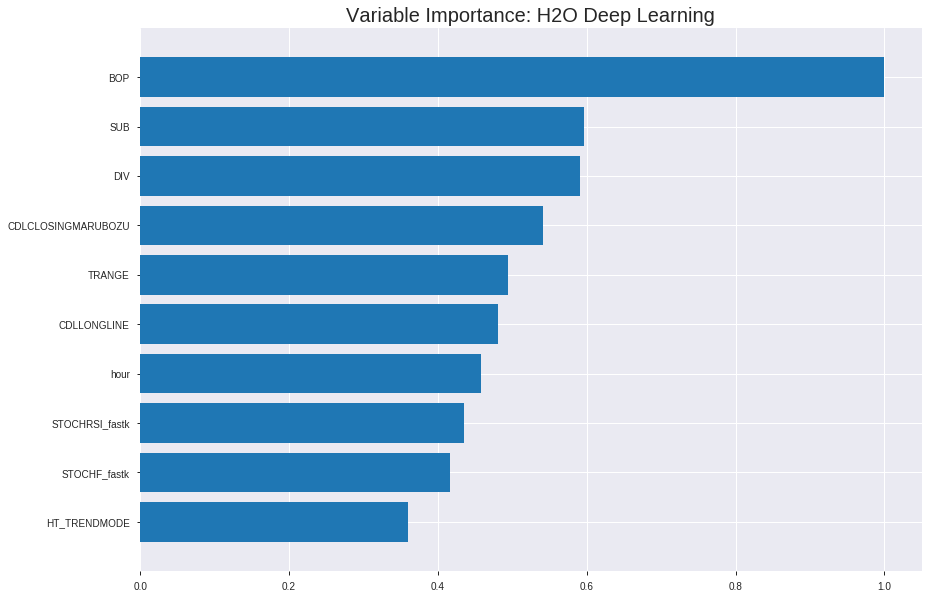

Model Details
H2ODeepLearningEstimator :  Deep Learning
Model Key:  DeepLearning_grid_1_AutoML_20190827_203823_model_2


ModelMetricsBinomial: deeplearning
** Reported on train data. **

MSE: 0.22981879269140348
RMSE: 0.4793941934268744
LogLoss: 0.6643868096069746
Mean Per-Class Error: 0.3127683615819209
AUC: 0.738185443668993
pr_auc: 0.6714983213964093
Gini: 0.47637088733798594
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4965531477393545: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      397  453   0.5329   (453.0/850.0)
1      87   621   0.1229   (87.0/708.0)
Total  484  1074  0.3466   (540.0/1558.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.496553     0.69697   232
max f2                       0.200704     0.824499  338
max f0point5                 0.659181     0.650212  157
max accuracy                 0.659181     0.683569  157
max precision                0.995058     1         0
max recall                   0.0400674    1         389
max specificity              0.995058     1         0
max absolute_mcc             0.628467     0.373585  172
max min_per_class_accuracy   0.664481     0.680791  154
max mean_per_class_accuracy  0.628467     0.687232  172

Gains/Lift Table: Avg response rate: 45.44 %, avg score: 60.48 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0102696                   0.967582           2.06303   2.06303            0.9375           0.977469  0.9375                      0.977469            0.0211864       0.0211864                  106.303   106.303
    2        0.0205392                   0.957811           1.78796   1.92549            0.8125           0.961639  0.875                       0.969554            0.0183616       0.039548                   78.7959   92.5494
    3        0.0301669                   0.951041           1.61375   1.826              0.733333         0.954752  0.829787                    0.96483             0.0155367       0.0550847                  61.3748   82.6001
    4        0.0404365                   0.939935           1.51289   1.74648            0.6875           0.944471  0.793651                    0.95966             0.0155367       0.0706215                  51.2888   74.648
    5        0.0500642                   0.933792           1.90716   1.77738            0.866667         0.937823  0.807692                    0.95546             0.0183616       0.0889831                  90.7156   77.7379
    6        0.100128                    0.899459           1.57989   1.67864            0.717949         0.916765  0.762821                    0.936112            0.079096        0.168079                   57.9893   67.8636
    7        0.150193                    0.874256           1.55168   1.63632            0.705128         0.885096  0.74359                     0.919107            0.0776836       0.245763                   55.168    63.6318
    8        0.200257                    0.845171           1.29777   1.55168            0.589744         0.859317  0.705128                    0.904159            0.0649718       0.310734                   29.7769   55.168
    9        0.300385                    0.788022           1.28366   1.46234            0.583333         0.817215  0.66453                     0.875178            0.128531        0.439266                   28.3663   46.2341
    10       0.399872                    0.716721           1.32034   1.42701            0.6              0.754286  0.648475                    0.845101            0.131356        0.570621                   32.0339   42.7012
    11       0.5                         0.64929            1.29777   1.40113            0.589744         0.684719  0.636714                    0.812983            0.129944        0.700565                   29.7769   40.113
    12       0.600128                    0.570864           0.88869   1.31563            0.403846         0.611705  0.597861                    0.779401            0.0889831       0.789548                   -11.131   31.5632
    13       0.699615                    0.484333           0.937015  1.26179            0.425806         0.527596  0.573394                    0.743594            0.0932203       0.882768                   -6.29852  26.1792
    14       0.799743                    0.372642           0.59246   1.17799            0.269231         0.427763  0.535313                    0.704052            0.059322        0.94209                    -40.754   17.7991
    15       0.899872                    0.214382           0.423186  1.094              0.192308         0.300506  0.497147                    0.659149            0.0423729       0.984463                   -57.6814  9.40041
    16       1                           0.000109945        0.155168  1                  0.0705128        0.116269  0.454429                    0.604791            



ModelMetricsBinomial: deeplearning
** Reported on validation data. **

MSE: 0.2039824740777512
RMSE: 0.45164418968669484
LogLoss: 0.6172892096856044
Mean Per-Class Error: 0.28587967664622016
AUC: 0.7651216638908072
pr_auc: 0.6962298450145066
Gini: 0.5302433277816143
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.3270523936093286: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      114  125  0.523    (125.0/239.0)
1      23   183  0.1117   (23.0/206.0)
Total  137  308  0.3326   (148.0/445.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.327052     0.712062  277
max f2                       0.242479     0.826125  301
max f0point5                 0.692526     0.694774  142
max accuracy                 0.540043     0.71236   205
max precision                0.991278     1         0
max recall                   0.0140514    1         385
max specificity              0.991278     1         0
max absolute_mcc             0.540043     0.427114  205
max min_per_class_accuracy   0.561125     0.698745  195
max mean_per_class_accuracy  0.540043     0.71412   205

Gains/Lift Table: Avg response rate: 46.29 %, avg score: 51.07 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.011236                    0.974612           1.72816   1.72816            0.8              0.979835   0.8                         0.979835            0.0194175       0.0194175                  72.8155   72.8155
    2        0.0202247                   0.966943           1.62015   1.68015            0.75             0.971309   0.777778                    0.976045            0.0145631       0.0339806                  62.0146   68.0151
    3        0.0314607                   0.955213           1.72816   1.6973             0.8              0.959876   0.785714                    0.970271            0.0194175       0.0533981                  72.8155   69.7295
    4        0.0404494                   0.95061            1.0801    1.56014            0.5              0.952919   0.722222                    0.966415            0.00970874      0.0631068                  8.00971   56.014
    5        0.0516854                   0.942868           2.16019   1.69059            1                0.948604   0.782609                    0.962543            0.0242718       0.0873786                  116.019   69.0587
    6        0.101124                    0.899117           1.37467   1.53614            0.636364         0.917125   0.711111                    0.940339            0.0679612       0.15534                    37.4669   53.6138
    7        0.150562                    0.865962           1.86562   1.64433            0.863636         0.886411   0.761194                    0.922631            0.092233        0.247573                   86.5622   64.4327
    8        0.2                         0.828503           1.66924   1.65049            0.772727         0.848991   0.764045                    0.904428            0.0825243       0.330097                   66.9241   65.0485
    9        0.301124                    0.743393           1.58414   1.62821            0.733333         0.781414   0.753731                    0.863117            0.160194        0.490291                   58.4142   62.8206
    10       0.4                         0.65568            1.22738   1.52913            0.568182         0.698851   0.707865                    0.822512            0.121359        0.61165                    22.7383   52.9126
    11       0.501124                    0.545088           1.1521    1.45305            0.533333         0.599187   0.672646                    0.777447            0.116505        0.728155                   15.2104   45.3045
    12       0.6                         0.42674            0.785525  1.34304            0.363636         0.479191   0.621723                    0.728296            0.0776699       0.805825                   -21.4475  34.3042
    13       0.698876                    0.321129           0.883716  1.27806            0.409091         0.373284   0.59164                     0.678069            0.0873786       0.893204                   -11.6284  27.8057
    14       0.8                         0.161236           0.480043  1.17718            0.222222         0.233935   0.544944                    0.621928            0.0485437       0.941748                   -51.9957  17.7184
    15       0.898876                    0.0562069          0.294572  1.0801             0.136364         0.110946   0.5                         0.56572             0.0291262       0.970874                   -70.5428  8.00971
    16       1                           6.13763e-06        0.288026  1                  0.133333         0.0221205  0.462921                    


Scoring History: 


timestamp            duration          training_speed    epochs    iterations    samples    training_rmse    training_logloss    training_r2    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_r2    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------------  ----------------  --------  ------------  ---------  ---------------  ------------------  -------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ---------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-08-27 20:40:13  0.000 sec                           0         0             0          nan              nan                 nan            nan             nan                nan              nan                              nan                nan                   nan              nan               nan                  nan                nan
    2019-08-27 20:40:15  1 min 43.710 sec  382 obs/sec       0.485237  1             756        0.615081         5.2038              -0.525974      0.671418        0.236184           1.67938          0.397304                         0.602592           5.12111               -0.460498        0.675661          0.373533             1.64175            0.413483
    2019-08-27 20:40:26  1 min 54.102 sec  404 obs/sec       2.97882   6             4641       0.494771         0.948799            0.0126049      0.752188        0.686082           1.78796          0.311938                         0.590534           2.27495               -0.402635        0.695881          0.660934             2.16019            0.397753
    2019-08-27 20:40:36  2 min  3.978 sec  414 obs/sec       5.42169   11            8447       0.445658         0.583593            0.198901       0.774136        0.71199            1.92549          0.327343                         0.477845           0.686851              0.0816042        0.742251          0.671472             1.72816            0.348315
    2019-08-27 20:40:47  2 min 15.241 sec  425 obs/sec       8.36393   17            13031      0.487723         0.692543            0.0405343      0.730063        0.657875           2.06303          0.345315                         0.552144           0.973598              -0.226196        0.758835          0.676232             1.29612            0.280899
    2019-08-27 20:40:58  2 min 26.343 sec  432 obs/sec       11.3434   23            17673      0.479394         0.664387            0.0730245      0.738185        0.671498           2.06303          0.346598                         0.451644           0.617289              0.179558         0.765122          0.69623              1.72816            0.332584
    2019-08-27 20:41:07  2 min 35.279 sec  438 obs/sec       13.7715   28            21456      0.452039         0.602406            0.175795       0.761474        0.712563           1.78796          0.311938                         0.54159            1.04329               -0.179768        0.716548          0.665008             1.72816            0.366292
    2019-08-27 20:41:16  2 min 44.069 sec  444 obs/sec       16.1906   33            25225      0.481059         0.696012            0.0665754      0.729234        0.639818           2.06303          0.353017                         0.648127           1.66358               -0.689568        0.723646          0.642935             1.29612            0.334831
    2019-08-27 20:41:26  2 min 54.347 sec  450 obs/sec       19.1194   39            29788      0.448497         0.587341            0.188663       0.77101         0.718428           2.20056          0.329268                         0.48445            0.709074              0.0560406        0.756469          0.696425             2.16019            0.341573
    2019-08-27 20:41:27

Variable Importances: 


variable                  relative_importance    scaled_importance    percentage
------------------------  ---------------------  -------------------  ---------------------
BOP                       1.0                    1.0                  0.005260479903775162
SUB                       0.5960022807121277     0.5960022807121277   0.003135258020290311
DIV                       0.5909035801887512     0.5909035801887512   0.003108436408651721
CDLCLOSINGMARUBOZU        0.541558563709259      0.541558563709259    0.002848857941109898
TRANGE                    0.4946315586566925     0.4946315586566925   0.0026019993740865163
---                       ---                    ---                  ---
BBANDS_middleband_12_4_2  0.14932183921337128    0.14932183921337128  0.0007855045343766856
MAVP_24_6                 0.14922896027565002    0.14922896027565002  0.0007850159465913189
BBANDS_upperband_14_1_5   0.14815197885036469    0.14815197885036469  0.0007793505074468663
BBANDS_upperband_8_1_3    0.14705468714237213    0.14705468714237213  0.0007735782264683924
BBANDS_middleband_12_4_4  0.14207737147808075    0.14207737147808075  0.0007473951574416422


See the whole table with table.as_data_frame()


('accuracy', 0.6860986547085202)

('F1', 0.6855123674911661)

('auc', 0.7358597285067874)

('logloss', 0.6523020070902058)

('mean_per_class_error', 0.3256302521008403)

('rmse', 0.47906642432043245)

('mse', 0.22950463891116463)

deeplearning prediction progress: |███████████████████████████████████████| 100%


/usr/local/lib/python3.6/dist-packages/pandas/plotting/_matplotlib/converter.py:102: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


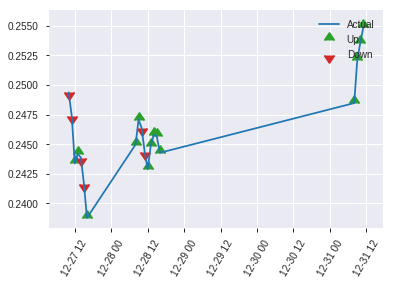


ModelMetricsBinomial: deeplearning
** Reported on test data. **

MSE: 0.22950463891116463
RMSE: 0.47906642432043245
LogLoss: 0.6523020070902058
Mean Per-Class Error: 0.3256302521008403
AUC: 0.7358597285067874
pr_auc: 0.7258225248127728
Gini: 0.47171945701357476
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.2918620412242268: 


0    1    Error    Rate
-----  ---  ---  -------  ------------
0      37   82   0.6891   (82.0/119.0)
1      7    97   0.0673   (7.0/104.0)
Total  44   179  0.3991   (89.0/223.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.291862     0.685512  178
max f2                       0.132022     0.834684  200
max f0point5                 0.785642     0.678191  67
max accuracy                 0.785642     0.686099  67
max precision                0.988053     1         0
max recall                   0.0663271    1         208
max specificity              0.988053     1         0
max absolute_mcc             0.785642     0.376582  67
max min_per_class_accuracy   0.647317     0.647059  109
max mean_per_class_accuracy  0.781474     0.67437   69

Gains/Lift Table: Avg response rate: 46.64 %, avg score: 57.32 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0134529                   0.972658           2.14423   2.14423            1                0.980679   1                           0.980679            0.0288462       0.0288462                  114.423   114.423
    2        0.0224215                   0.96637            2.14423   2.14423            1                0.968103   1                           0.975649            0.0192308       0.0480769                  114.423   114.423
    3        0.0313901                   0.964232           2.14423   2.14423            1                0.965173   1                           0.972656            0.0192308       0.0673077                  114.423   114.423
    4        0.0403587                   0.959981           2.14423   2.14423            1                0.963914   1                           0.970713            0.0192308       0.0865385                  114.423   114.423
    5        0.0538117                   0.953544           2.14423   2.14423            1                0.955765   1                           0.966976            0.0288462       0.115385                   114.423   114.423
    6        0.103139                    0.927249           1.75437   1.95778            0.818182         0.940082   0.913043                    0.954114            0.0865385       0.201923                   75.4371   95.7776
    7        0.152466                    0.90374            1.75437   1.89197            0.818182         0.914116   0.882353                    0.941173            0.0865385       0.288462                   75.4371   89.1968
    8        0.201794                    0.861065           0.97465   1.66774            0.454545         0.878523   0.777778                    0.925859            0.0480769       0.336538                   -2.53497  66.7735
    9        0.300448                    0.78758            1.46198   1.60017            0.681818         0.823451   0.746269                    0.892232            0.144231        0.480769                   46.1976   60.0172
    10       0.399103                    0.696096           0.877185  1.42146            0.409091         0.740584   0.662921                    0.854746            0.0865385       0.567308                   -12.2815  42.1456
    11       0.502242                    0.635761           0.932274  1.321              0.434783         0.668746   0.616071                    0.81655             0.0961538       0.663462                   -6.77258  32.0999
    12       0.600897                    0.508328           0.877185  1.24813            0.409091         0.57692    0.58209                     0.777208            0.0865385       0.75                       -12.2815  24.8134
    13       0.699552                    0.397841           0.97465   1.20957            0.454545         0.4547     0.564103                    0.731726            0.0961538       0.846154                   -2.53497  20.9566
    14       0.798206                    0.294754           0.77972   1.15644            0.363636         0.352698   0.539326                    0.68488             0.0769231       0.923077                   -22.028   15.6439
    15       0.896861                    0.13294            0.58479   1.09356            0.272727         0.206891   0.51                        0.632301            0.0576923       0.980769                   -41.521   9.35577
    16       1                           0.0048482          0.186455  1                  0.0869565        0.0589363  0.466368                   

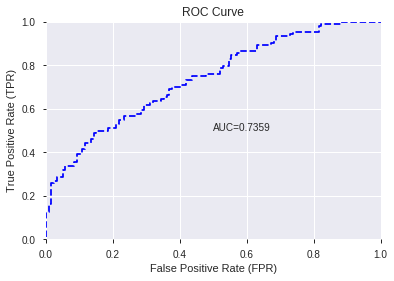

This function is available for GLM models only


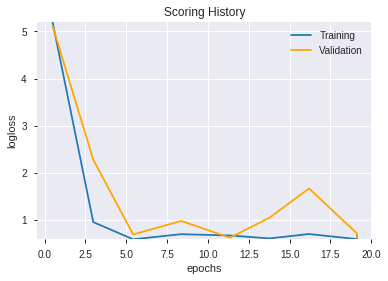

--2019-08-27 21:05:31--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.113.155
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.113.155|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 368257676 (351M) [application/zip]
Saving to: ‘h2o-3.24.0.5.zip’

h2o-3.24.0.5.zip    100%[===================>] 351.20M  36.4MB/s    in 11s     

2019-08-27 21:05:42 (32.2 MB/s) - ‘h2o-3.24.0.5.zip’ saved [368257676/368257676]

Archive:  h2o-3.24.0.5.zip
   creating: h2o-3.24.0.5/
   creating: h2o-3.24.0.5/bindings/
   creating: h2o-3.24.0.5/bindings/java/
 extracting: h2o-3.24.0.5/bindings/java/h2o-bindings-3.24.0.zip  
  inflating: h2o-3.24.0.5/h2o.jar    
   creating: h2o-3.24.0.5/python/
  inflating: h2o-3.24.0.5/python/h2o-3.24.0.5-py2.py3-none-any.whl  
   creating: h2o-3.24.0.5/R/
  inflating: h2o-3.24.0.5/R/h2o_3.24.0.5.tar.gz  
ERROR: U

[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/DeepLearning_grid_1_AutoML_20190827_203823_model_2',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'DeepLearning_grid_1_AutoML_20190827_203823_model_2',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_2_sid_82c1',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl

In [10]:
# DeepLearning
features_list = model_train(feature_name='All',model_algo="DeepLearning")

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  DeepLearning_grid_1_AutoML_20190827_210555_model_8  0.759050  0.631780              0.362597  0.462078  0.213516
1  DeepLearning_grid_1_AutoML_20190827_210555_model_9  0.758484  0.614700              0.350598  0.458622  0.210335
2  DeepLearning_grid_1_AutoML_20190827_210555_model_6  0.758161  0.613071              0.315853  0.453088  0.205289
3  DeepLearning_grid_1_AutoML_20190827_210555_model_2  0.751697  0.639277              0.337387  0.463417  0.214756
4  DeepLearning_grid_1_AutoML_20190827_210555_model_3  0.749030  0.714091              0.368576  0.469929  0.220833
5  DeepLearning_grid_1_AutoML_20190827_210555_model_7  0.741677  0.692732              0.366193  0.487107  0.237273
6  DeepLearning_grid_1_AutoML_20190827_210555_model_5  0.740950  0.597798              0.338599  0.454503  0.206573
7               DeepLearning_1_AutoML_20190827_210555  0.723739  0.617825              0.369788  0.464434  0.215699
8  DeepLearning_grid_1_AutoML_20190827_210555_model_4  0.717195  0.987040              0.377020  0.518263  0.268596
9  DeepLearning_grid_1_AutoML_20190827_210555_model_1  0.715902  0.932586              0.364981  0.511570  0.261704

variable  relative_importance  scaled_importance  percentage
0     CDLCLOSINGMARUBOZU             1.000000           1.000000    0.032110
1                    BOP             0.925714           0.925714    0.029724
2                    SUB             0.817500           0.817500    0.026250
3                    DIV             0.794903           0.794903    0.025524
4             aroonup_14             0.791951           0.791951    0.025429
5           weekday_name             0.768978           0.768978    0.024692
6                   hour             0.745551           0.745551    0.023939
7           HT_TRENDMODE             0.688671           0.688671    0.022113
8                 TRANGE             0.675875           0.675875    0.021702
9              CORREL_14             0.659977           0.659977    0.021192
10     CDLLONGLEGGEDDOJI             0.659049           0.659049    0.021162
11          CDLENGULFING             0.657190           0.657190    0.021102
12                ULTOSC             0.655014           0.655014    0.021032
13                SAREXT             0.647688           0.647688    0.020797
14                 ADOSC             0.647379           0.647379    0.020787
15         days_in_month             0.641875           0.641875    0.020610
16           CDLLONGLINE             0.634914           0.634914    0.020387
17             CDLHAMMER             0.633313           0.633313    0.020335
18          CDLSHORTLINE             0.616383           0.616383    0.019792
19         CDLHANGINGMAN             0.615565           0.615565    0.019765
20             dayofweek             0.611696           0.611696    0.019641
21        STOCHRSI_fastd             0.609729           0.609729    0.019578
22          aroondown_20             0.603725           0.603725    0.019385
23               ADXR_14             0.596709           0.596709    0.019160
24              WILLR_14             0.595279           0.595279    0.019114
25               BETA_30             0.590589           0.590589    0.018964
26  HT_PHASOR_quadrature             0.578452           0.578452    0.018574
27           aroondown_8             0.578005           0.578005    0.018559
28               CDLDOJI             0.575884           0.575884    0.018491
29           STOCH_slowd             0.575508           0.575508    0.018479
30          aroondown_12             0.574697           0.574697    0.018453
31             PLUS_DI_8             0.574093           0.574093    0.018434
32             CORREL_12             0.572222           0.572222    0.018374
33             aroonup_8             0.570681           0.570681    0.018324
34          STOCHF_fastk             0.569853           0.569853    0.018298
35                  DX_8             0.565559           0.565559    0.018160
36        STOCHRSI_fastk             0.564106           0.564106    0.018113
37            PLUS_DM_12             0.561147           0.561147    0.018018
38              CORREL_8             0.554914           0.554914    0.017818
39            PLUS_DI_12             0.554528           0.554528    0.017806
40        CDLSPINNINGTOP             0.552518           0.552518    0.017741
41              WILLR_12             0.551272           0.551272    0.017701
42                Volume             0.545159           0.545159    0.017505
43                BETA_8             0.541971           0.541971    0.017402
44               weekday             0.537458           0.537458    0.017258
45    CDLMORNINGDOJISTAR             0.529741           0.529741    0.017010
46               WILLR_8             0.527005           0.527005    0.016922
47   CDLGAPSIDESIDEWHITE             0.509821           0.509821    0.016370
48          STOCHF_fastd             0.501025           0.501025    0.016088
49     CDL3WHITESOLDIERS             0.492577           0.492577    0.015816

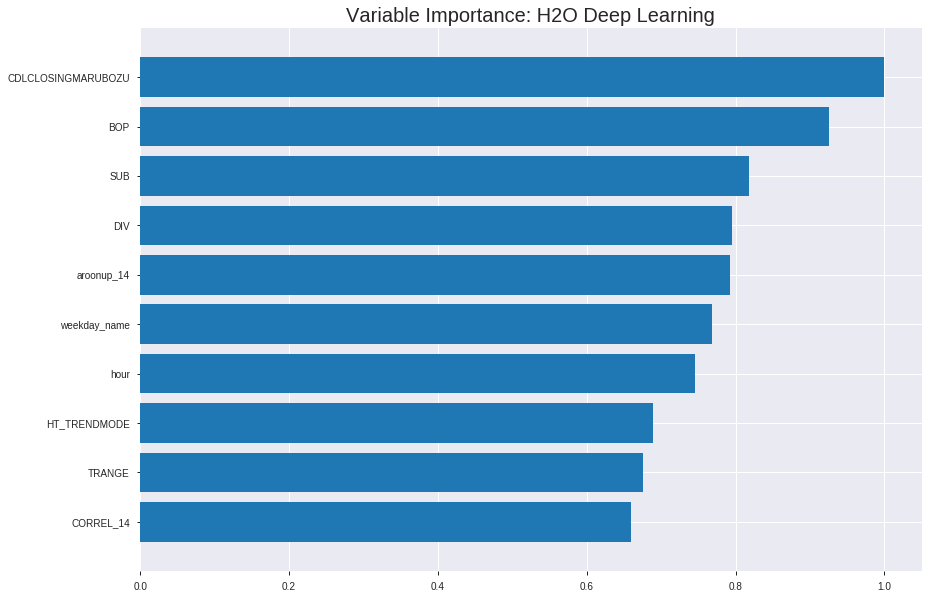

Model Details
H2ODeepLearningEstimator :  Deep Learning
Model Key:  DeepLearning_grid_1_AutoML_20190827_210555_model_8


ModelMetricsBinomial: deeplearning
** Reported on train data. **

MSE: 0.182838543560707
RMSE: 0.4275962389459325
LogLoss: 0.5366153516921353
Mean Per-Class Error: 0.2819209039548023
AUC: 0.8045995347291459
pr_auc: 0.77033545343143
Gini: 0.6091990694582918
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4205172082825512: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      440  410   0.4824   (410.0/850.0)
1      70   638   0.0989   (70.0/708.0)
Total  510  1048  0.3081   (480.0/1558.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.420517     0.726651  231
max f2                       0.170842     0.846921  322
max f0point5                 0.533425     0.70586   151
max accuracy                 0.528534     0.721438  158
max precision                0.942623     1         0
max recall                   0.0156124    1         388
max specificity              0.942623     1         0
max absolute_mcc             0.448355     0.444729  218
max min_per_class_accuracy   0.505522     0.70339   177
max mean_per_class_accuracy  0.46229      0.718079  209

Gains/Lift Table: Avg response rate: 45.44 %, avg score: 43.96 %



group    cumulative_data_fraction    lower_threshold    lift       cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  ---------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0102696                   0.861874           2.06303    2.06303            0.9375           0.888359   0.9375                      0.888359            0.0211864       0.0211864                  106.303   106.303
    2        0.0205392                   0.826231           2.06303    2.06303            0.9375           0.843631   0.9375                      0.865995            0.0211864       0.0423729                  106.303   106.303
    3        0.0301669                   0.811092           2.20056    2.10692            1                0.818512   0.957447                    0.850841            0.0211864       0.0635593                  120.056   110.692
    4        0.0404365                   0.798571           2.20056    2.13071            1                0.804311   0.968254                    0.839024            0.0225989       0.0861582                  120.056   113.071
    5        0.0500642                   0.785034           2.20056    2.14414            1                0.7919     0.974359                    0.829961            0.0211864       0.107345                   120.056   114.414
    6        0.100128                    0.704794           1.86202    2.00308            0.846154         0.742889   0.910256                    0.786425            0.0932203       0.200565                   86.2017   100.308
    7        0.150193                    0.629709           1.66453    1.89023            0.75641          0.661442   0.858974                    0.744764            0.0833333       0.283898                   66.453    89.0229
    8        0.200257                    0.583704           1.60811    1.8197             0.730769         0.60491    0.826923                    0.709801            0.0805085       0.364407                   60.8105   81.9698
    9        0.300385                    0.535852           1.49526    1.71155            0.679487         0.555746   0.777778                    0.658449            0.149718        0.514124                   49.5256   71.1551
    10       0.399872                    0.522665           1.14997    1.57183            0.522581         0.529593   0.714286                    0.62639             0.114407        0.628531                   14.9973   57.1832
    11       0.5                         0.500626           0.987433   1.4548             0.448718         0.511303   0.661104                    0.603343            0.0988701       0.727401                   -1.2567   45.4802
    12       0.600128                    0.461403           1.08618    1.3933             0.49359          0.483764   0.633155                    0.583392            0.108757        0.836158                   8.61763   39.3299
    13       0.699615                    0.39346            0.766648   1.30419            0.348387         0.432848   0.592661                    0.561984            0.0762712       0.912429                   -23.3352  30.4188
    14       0.799743                    0.21156            0.550141   1.20978            0.25             0.308663   0.549759                    0.530268            0.0550847       0.967514                   -44.9859  20.9781
    15       0.899872                    0.0643726          0.268018   1.10499            0.121795         0.128616   0.50214                     0.485577            0.0268362       0.99435                    -73.1982  10.4991
    16       1                           0.00116099         0.0564247  1                  0.025641         0.0265082  0.454429 



ModelMetricsBinomial: deeplearning
** Reported on validation data. **

MSE: 0.19903959517330655
RMSE: 0.44613853809473414
LogLoss: 0.5952292745497855
Mean Per-Class Error: 0.2844578949506439
AUC: 0.764055327619125
pr_auc: 0.6786849655834497
Gini: 0.52811065523825
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.31140766547961496: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      120  119  0.4979   (119.0/239.0)
1      18   188  0.0874   (18.0/206.0)
Total  138  307  0.3079   (137.0/445.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.311408     0.732943  273
max f2                       0.240692     0.846354  293
max f0point5                 0.510227     0.693018  161
max accuracy                 0.490931     0.714607  186
max precision                0.870718     1         0
max recall                   0.00480942   1         391
max specificity              0.870718     1         0
max absolute_mcc             0.311408     0.447066  273
max min_per_class_accuracy   0.492062     0.707113  183
max mean_per_class_accuracy  0.488895     0.715542  188

Gains/Lift Table: Avg response rate: 46.29 %, avg score: 39.48 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.011236                    0.802209           1.72816   1.72816            0.8              0.838493   0.8                         0.838493            0.0194175       0.0194175                  72.8155   72.8155
    2        0.0202247                   0.768657           1.62015   1.68015            0.75             0.791341   0.777778                    0.817536            0.0145631       0.0339806                  62.0146   68.0151
    3        0.0314607                   0.750189           1.29612   1.543              0.6              0.758854   0.714286                    0.796578            0.0145631       0.0485437                  29.6117   54.2996
    4        0.0404494                   0.736487           1.62015   1.56014            0.75             0.743676   0.722222                    0.784822            0.0145631       0.0631068                  62.0146   56.014
    5        0.0516854                   0.70987            2.16019   1.69059            1                0.721118   0.782609                    0.770973            0.0242718       0.0873786                  116.019   69.0587
    6        0.101124                    0.625445           1.37467   1.53614            0.636364         0.658669   0.711111                    0.716069            0.0679612       0.15534                    37.4669   53.6138
    7        0.150562                    0.571298           1.57105   1.5476             0.727273         0.598573   0.716418                    0.677488            0.0776699       0.23301                    57.105    54.7602
    8        0.2                         0.541485           1.27648   1.48058            0.590909         0.553887   0.685393                    0.646935            0.0631068       0.296117                   27.6478   48.0583
    9        0.301124                    0.52963            1.53614   1.49924            0.711111         0.532786   0.69403                     0.608601            0.15534         0.451456                   53.6138   49.9239
    10       0.4                         0.515716           1.52195   1.50485            0.704545         0.524772   0.696629                    0.58788             0.150485        0.601942                   52.1955   50.4854
    11       0.501124                    0.487766           1.24811   1.45305            0.577778         0.503107   0.672646                    0.570773            0.126214        0.728155                   24.8112   45.3045
    12       0.6                         0.412365           0.932811  1.36731            0.431818         0.454291   0.632959                    0.551577            0.092233        0.820388                   -6.71889  36.7314
    13       0.698876                    0.301285           0.932811  1.30584            0.431818         0.357761   0.604502                    0.524156            0.092233        0.912621                   -6.71889  30.5841
    14       0.8                         0.1195             0.480043  1.20146            0.222222         0.206774   0.55618                     0.484038            0.0485437       0.961165                   -51.9957  20.1456
    15       0.898876                    0.0319087          0.147286  1.0855             0.0681818        0.0645636  0.5025                      0.437896            0.0145631       0.975728                   -85.2714  8.54976
    16       1                           0.000937369        0.240022  1                  0.111111         0.0119986  0.462921                    


Scoring History: 


timestamp            duration          training_speed    epochs    iterations    samples    training_rmse    training_logloss    training_r2    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_r2    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------------  ----------------  --------  ------------  ---------  ---------------  ------------------  -------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ---------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-08-27 21:11:01  0.000 sec                           0         0             0          nan              nan                 nan            nan             nan                nan              nan                              nan                nan                   nan              nan               nan                  nan                nan
    2019-08-27 21:11:03  1 min  9.734 sec  624 obs/sec       0.602054  1             938        0.526956         0.813247            -0.120036      0.748346        0.698731           2.06303          0.336329                         0.490798           0.718106              0.0311396        0.759303          0.691506             1.72816            0.305618
    2019-08-27 21:11:12  1 min 19.154 sec  955 obs/sec       6.15083   10            9583       0.446354         0.578841            0.196398       0.793731        0.751408           1.92549          0.292683                         0.47904            0.670595              0.0770076        0.766818          0.695093             1.72816            0.314607
    2019-08-27 21:11:22  1 min 28.358 sec  1093 obs/sec      12.8537   21            20026      0.427596         0.536615            0.26252        0.8046          0.770335           2.06303          0.308087                         0.446139           0.595229              0.199439         0.764055          0.678685             1.72816            0.307865
    2019-08-27 21:11:31  1 min 37.603 sec  1177 obs/sec      20.1598   33            31409      0.418354         0.516775            0.294056       0.827385        0.794269           2.20056          0.280488                         0.462483           0.653904              0.139705         0.768798          0.687265             1.29612            0.294382
    2019-08-27 21:11:40  1 min 46.434 sec  1238 obs/sec      27.5366   45            42902      0.398349         0.473985            0.359955       0.846992        0.817877           2.20056          0.279204                         0.452411           0.619671              0.17677          0.774709          0.689508             1.29612            0.278652
    2019-08-27 21:11:49  1 min 55.581 sec  1289 obs/sec      35.4891   58            55292      0.395992         0.465141            0.367508       0.863972        0.838909           2.20056          0.251605                         0.46043            0.653722              0.147327         0.762979          0.677649             1.72816            0.283146
    2019-08-27 21:11:58  2 min  4.616 sec  1326 obs/sec      43.4358   71            67673      0.380923         0.439952            0.414728       0.886181        0.872242           2.20056          0.208601                         0.463173           0.673693              0.137139         0.75459           0.668826             2.16019            0.321348
    2019-08-27 21:12:07  2 min 14.081 sec  1360 obs/sec      52.0225   85            81051      0.35709          0.386787            0.485673       0.907636        0.88743            2.20056          0.20154                          0.48743            0.842859              0.0443919        0.740291          0.648857             1.29612            0.361798
    2019-08-27 21:12:08

Variable Importances: 


variable             relative_importance    scaled_importance    percentage
-------------------  ---------------------  -------------------  --------------------
CDLCLOSINGMARUBOZU   1.0                    1.0                  0.03210952068361198
BOP                  0.9257140755653381     0.9257140755653381   0.029724235256475974
SUB                  0.8174996376037598     0.8174996376037598   0.026249521522483225
DIV                  0.7949027419090271     0.7949027419090271   0.025523946032787785
aroonup_14           0.7919507026672363     0.7919507026672363   0.02542915746769467
---                  ---                    ---                  ---
CDLMORNINGDOJISTAR   0.529741108417511      0.529741108417511    0.01700973307769161
WILLR_8              0.5270050168037415     0.5270050168037415   0.016921878487427017
CDLGAPSIDESIDEWHITE  0.5098205804824829     0.5098205804824829   0.016370094473933353
STOCHF_fastd         0.501025378704071      0.501025378704071    0.016087684760512897
CDL3WHITESOLDIERS    0.492577463388443      0.492577463388443    0.015816426248952336


See the whole table with table.as_data_frame()


('accuracy', 0.726457399103139)

('F1', 0.6909090909090908)

('auc', 0.7590497737556562)

('logloss', 0.6317795090405046)

('mean_per_class_error', 0.28478506787330315)

('rmse', 0.46207778083095397)

('mse', 0.2135158755376591)

deeplearning prediction progress: |███████████████████████████████████████| 100%


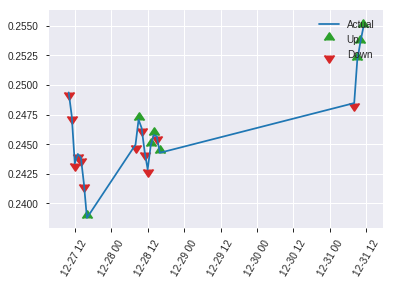


ModelMetricsBinomial: deeplearning
** Reported on test data. **

MSE: 0.2135158755376591
RMSE: 0.46207778083095397
LogLoss: 0.6317795090405046
Mean Per-Class Error: 0.28478506787330315
AUC: 0.7590497737556562
pr_auc: 0.7433419904260342
Gini: 0.5180995475113124
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.15422564415266762: 


0    1    Error    Rate
-----  ---  ---  -------  ------------
0      43   76   0.6387   (76.0/119.0)
1      9    95   0.0865   (9.0/104.0)
Total  52   171  0.3812   (85.0/223.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.154226     0.690909  170
max f2                       0.0414479    0.833333  195
max f0point5                 0.517378     0.736842  68
max accuracy                 0.517378     0.726457  68
max precision                0.832224     1         0
max recall                   0.0161047    1         209
max specificity              0.832224     1         0
max absolute_mcc             0.517378     0.463215  68
max min_per_class_accuracy   0.479397     0.673077  106
max mean_per_class_accuracy  0.516492     0.715215  70

Gains/Lift Table: Avg response rate: 46.64 %, avg score: 38.23 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0134529                   0.785402           2.14423   2.14423            1                0.81661    1                           0.81661             0.0288462       0.0288462                  114.423   114.423
    2        0.0224215                   0.763303           2.14423   2.14423            1                0.770628   1                           0.798217            0.0192308       0.0480769                  114.423   114.423
    3        0.0313901                   0.723943           2.14423   2.14423            1                0.739968   1                           0.781575            0.0192308       0.0673077                  114.423   114.423
    4        0.0403587                   0.714247           1.07212   1.90598            0.5              0.721951   0.888889                    0.768325            0.00961538      0.0769231                  7.21154   90.5983
    5        0.0538117                   0.702892           2.14423   1.96554            1                0.709583   0.916667                    0.753639            0.0288462       0.105769                   114.423   96.5545
    6        0.103139                    0.621977           1.75437   1.86455            0.818182         0.661367   0.869565                    0.709509            0.0865385       0.192308                   75.4371   86.4548
    7        0.152466                    0.563263           1.75437   1.8289             0.818182         0.594477   0.852941                    0.672293            0.0865385       0.278846                   75.4371   82.8903
    8        0.201794                    0.532404           1.75437   1.81068            0.818182         0.542666   0.844444                    0.640606            0.0865385       0.365385                   75.4371   81.0684
    9        0.300448                    0.521962           1.55944   1.72819            0.727273         0.527867   0.80597                     0.603587            0.153846        0.519231                   55.9441   72.8186
    10       0.399103                    0.496733           0.877185  1.51783            0.409091         0.506747   0.707865                    0.579649            0.0865385       0.605769                   -12.2815  51.7826
    11       0.502242                    0.470313           0.652592  1.34014            0.304348         0.487484   0.625                       0.560723            0.0673077       0.673077                   -34.7408  34.0144
    12       0.600897                    0.403972           0.877185  1.26414            0.409091         0.445029   0.589552                    0.541728            0.0865385       0.759615                   -12.2815  26.4136
    13       0.699552                    0.256299           0.77972   1.19582            0.363636         0.325642   0.557692                    0.511255            0.0769231       0.836538                   -22.028   19.5821
    14       0.798206                    0.104931           0.877185  1.15644            0.409091         0.174489   0.539326                    0.469632            0.0865385       0.923077                   -12.2815  15.6439
    15       0.896861                    0.0291413          0.58479   1.09356            0.272727         0.0609994  0.51                        0.424682            0.0576923       0.980769                   -41.521   9.35577
    16       1                           0.00112655         0.186455  1                  0.0869565        0.013351   0.466368                   

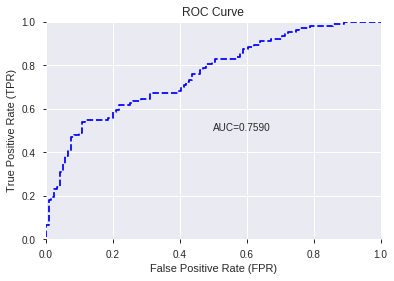

This function is available for GLM models only


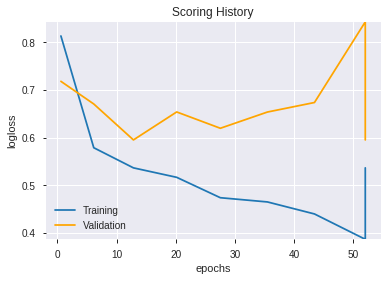

--2019-08-27 21:13:26--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.138.83
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.138.83|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/DeepLearning_grid_1_AutoML_20190827_210555_model_8',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'DeepLearning_grid_1_AutoML_20190827_210555_model_8',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_10_sid_82c1',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'autom

['CDLCLOSINGMARUBOZU',
 'BOP',
 'SUB',
 'DIV',
 'aroonup_14',
 'weekday_name',
 'hour',
 'HT_TRENDMODE',
 'TRANGE',
 'CORREL_14',
 'CDLLONGLEGGEDDOJI',
 'CDLENGULFING',
 'ULTOSC',
 'SAREXT',
 'ADOSC',
 'days_in_month',
 'CDLLONGLINE',
 'CDLHAMMER',
 'CDLSHORTLINE',
 'CDLHANGINGMAN',
 'dayofweek',
 'STOCHRSI_fastd',
 'aroondown_20',
 'ADXR_14',
 'WILLR_14',
 'BETA_30',
 'HT_PHASOR_quadrature',
 'aroondown_8',
 'CDLDOJI',
 'STOCH_slowd',
 'aroondown_12',
 'PLUS_DI_8',
 'CORREL_12',
 'aroonup_8',
 'STOCHF_fastk',
 'DX_8',
 'STOCHRSI_fastk',
 'PLUS_DM_12',
 'CORREL_8',
 'PLUS_DI_12',
 'CDLSPINNINGTOP',
 'WILLR_12',
 'Volume',
 'BETA_8',
 'weekday',
 'CDLMORNINGDOJISTAR',
 'WILLR_8',
 'CDLGAPSIDESIDEWHITE',
 'STOCHF_fastd',
 'CDL3WHITESOLDIERS']

In [11]:
# DeepLearning with top DeepLearning features
model_train(feature_name='DLF',model_algo="DeepLearning",features_list = features_list[:model_selected_features])

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  GLM_grid_1_AutoML_20190827_211335_model_1  0.751454  0.597226              0.367405  0.453811  0.205944

variable  relative_importance  scaled_importance  percentage
0                    BOP             0.307835           1.000000    0.091165
1     CDLCLOSINGMARUBOZU             0.208818           0.678342    0.061841
2                    SUB             0.138473           0.449828    0.041009
3              CDLHAMMER             0.137692           0.447290    0.040777
4                    DIV             0.137297           0.446008    0.040660
5           STOCHF_fastk             0.126337           0.410405    0.037415
6            CDLLONGLINE             0.125978           0.409239    0.037308
7                 ULTOSC             0.125344           0.407179    0.037121
8                   hour             0.120211           0.390506    0.035601
9           CDLENGULFING             0.112937           0.366875    0.033446
10         CDLHANGINGMAN             0.097408           0.316429    0.028847
11                 ADOSC             0.088744           0.288285    0.026282
12           STOCH_slowd             0.083758           0.272087    0.024805
13                SAREXT             0.082808           0.269001    0.024524
14            aroonup_14             0.081651           0.265242    0.024181
15              WILLR_14             0.078593           0.255307    0.023275
16                TRANGE             0.075355           0.244789    0.022316
17             PLUS_DI_8             0.070126           0.227803    0.020768
18   CDLGAPSIDESIDEWHITE             0.069729           0.226515    0.020650
19                Volume             0.068505           0.222537    0.020288
20          CDLSHORTLINE             0.063519           0.206341    0.018811
21        STOCHRSI_fastk             0.055941           0.181722    0.016567
22          aroondown_20             0.053667           0.174336    0.015893
23              WILLR_12             0.053224           0.172899    0.015762
24                BETA_8             0.050236           0.163190    0.014877
25               CDLDOJI             0.047183           0.153274    0.013973
26     CDLLONGLEGGEDDOJI             0.047151           0.153170    0.013964
27  HT_PHASOR_quadrature             0.043021           0.139752    0.012741
28               WILLR_8             0.040743           0.132353    0.012066
29          HT_TRENDMODE             0.040125           0.130346    0.011883
30            PLUS_DM_12             0.039663           0.128844    0.011746
31           aroondown_8             0.039606           0.128661    0.011729
32             CORREL_12             0.036712           0.119257    0.010872
33             aroonup_8             0.036029           0.117040    0.010670
34             dayofweek             0.036023           0.117019    0.010668
35               weekday             0.035985           0.116898    0.010657
36            PLUS_DI_12             0.035838           0.116419    0.010613
37              CORREL_8             0.028644           0.093050    0.008483
38               BETA_30             0.028618           0.092966    0.008475
39        STOCHRSI_fastd             0.028612           0.092945    0.008473
40    CDLMORNINGDOJISTAR             0.028050           0.091121    0.008307
41     CDL3WHITESOLDIERS             0.027430           0.089107    0.008123
42          STOCHF_fastd             0.025163           0.081742    0.007452
43                  DX_8             0.023440           0.076144    0.006942
44         days_in_month             0.021575           0.070085    0.006389
45        CDLSPINNINGTOP             0.020413           0.066312    0.006045
46          aroondown_12             0.020254           0.065794    0.005998
47               ADXR_14             0.014580           0.047361    0.004318
48          weekday_name             0.011778           0.038262    0.003488
49             CORREL_14             0.005853           0.019012    0.001733

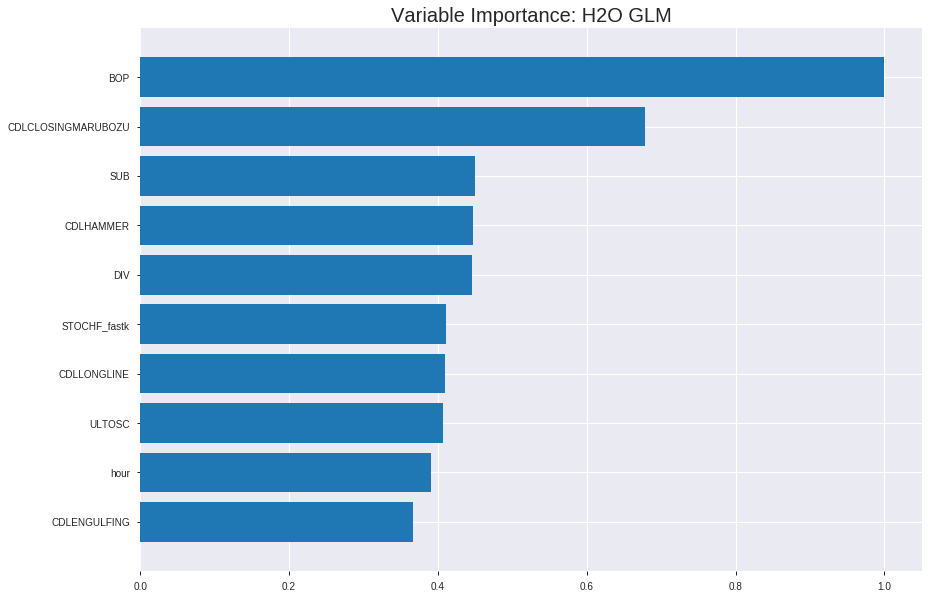

Model Details
H2OGeneralizedLinearEstimator :  Generalized Linear Modeling
Model Key:  GLM_grid_1_AutoML_20190827_211335_model_1


ModelMetricsBinomialGLM: glm
** Reported on train data. **

MSE: 0.1916227404067991
RMSE: 0.4377473476867668
LogLoss: 0.5643907614552544
Null degrees of freedom: 1557
Residual degrees of freedom: 1507
Null deviance: 2146.8864027643094
Residual deviance: 1758.6416126945728
AIC: 1860.6416126945728
AUC: 0.7804710867397806
pr_auc: 0.7361537005601774
Gini: 0.5609421734795612
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.37147396365512286: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      445  405   0.4765   (405.0/850.0)
1      97   611   0.137    (97.0/708.0)
Total  542  1016  0.3222   (502.0/1558.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.371474     0.708817  253
max f2                       0.236353     0.829315  324
max f0point5                 0.47678      0.685853  189
max accuracy                 0.466493     0.715019  195
max precision                0.949634     1         0
max recall                   0.052133     1         394
max specificity              0.949634     1         0
max absolute_mcc             0.462353     0.42676   197
max min_per_class_accuracy   0.454419     0.711765  201
max mean_per_class_accuracy  0.447558     0.714171  205

Gains/Lift Table: Avg response rate: 45.44 %, avg score: 45.44 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0102696                   0.875958           2.06303   2.06303            0.9375           0.898645  0.9375                      0.898645            0.0211864       0.0211864                  106.303   106.303
    2        0.0205392                   0.840919           1.65042   1.85673            0.75             0.859902  0.84375                     0.879273            0.0169492       0.0381356                  65.0424   85.6727
    3        0.0301669                   0.814329           2.05386   1.91964            0.933333         0.826017  0.87234                     0.862277            0.019774        0.0579096                  105.386   91.9642
    4        0.0404365                   0.794716           2.20056   1.99099            1                0.805824  0.904762                    0.84794             0.0225989       0.0805085                  120.056   99.0987
    5        0.0500642                   0.784307           2.20056   2.03129            1                0.790522  0.923077                    0.836898            0.0211864       0.101695                   120.056   103.129
    6        0.100128                    0.72552            1.80559   1.91844            0.820513         0.752508  0.871795                    0.794703            0.0903955       0.19209                    80.5592   91.8441
    7        0.150193                    0.679174           1.63632   1.8244             0.74359          0.7016    0.82906                     0.763669            0.0819209       0.274011                   63.6318   82.44
    8        0.200257                    0.641583           1.60811   1.77033            0.730769         0.657338  0.804487                    0.737086            0.0805085       0.35452                    60.8105   77.0326
    9        0.300385                    0.573278           1.38241   1.64102            0.628205         0.606568  0.745726                    0.69358             0.138418        0.492938                   38.2406   64.102
    10       0.399872                    0.507734           1.14997   1.51885            0.522581         0.538929  0.690209                    0.655104            0.114407        0.607345                   14.9973   51.8849
    11       0.5                         0.443789           1.24134   1.46328            0.564103         0.473358  0.664955                    0.618708            0.124294        0.731638                   24.1344   46.3277
    12       0.600128                    0.39926            0.818159  1.35564            0.371795         0.42073   0.616043                    0.585676            0.0819209       0.813559                   -18.1841  35.5642
    13       0.699615                    0.342901           0.780846  1.27391            0.354839         0.372114  0.578899                    0.555307            0.0776836       0.891243                   -21.9154  27.3905
    14       0.799743                    0.277603           0.550141  1.18329            0.25             0.312525  0.537721                    0.524911            0.0550847       0.946328                   -44.9859  18.3289
    15       0.899872                    0.177071           0.409079  1.09714            0.185897         0.227943  0.498573                    0.491867            0.0409605       0.987288                   -59.0921  9.71433
    16       1                           0.00324987         0.126956  1                  0.0576923        0.117964  0.454429                    0.454429            



ModelMetricsBinomialGLM: glm
** Reported on validation data. **

MSE: 0.20068522399360247
RMSE: 0.4479790441455967
LogLoss: 0.5837344415671307
Null degrees of freedom: 444
Residual degrees of freedom: 394
Null deviance: 614.5808798679772
Residual deviance: 519.5236529947464
AIC: 621.5236529947464
AUC: 0.7737234431490433
pr_auc: 0.7026060116967295
Gini: 0.5474468862980866
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.283643143348436: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      124  115  0.4812   (115.0/239.0)
1      24   182  0.1165   (24.0/206.0)
Total  148  297  0.3124   (139.0/445.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.283643     0.723658  263
max f2                       0.156833     0.834718  339
max f0point5                 0.466742     0.711845  155
max accuracy                 0.466742     0.721348  155
max precision                0.855864     1         0
max recall                   0.0654749    1         376
max specificity              0.855864     1         0
max absolute_mcc             0.466742     0.43908   155
max min_per_class_accuracy   0.389796     0.707113  198
max mean_per_class_accuracy  0.347229     0.715715  224

Gains/Lift Table: Avg response rate: 46.29 %, avg score: 39.02 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.011236                    0.82614            2.16019   2.16019            1                0.838983   1                           0.838983            0.0242718       0.0242718                  116.019   116.019
    2        0.0202247                   0.784387           2.16019   2.16019            1                0.809625   1                           0.825935            0.0194175       0.0436893                  116.019   116.019
    3        0.0314607                   0.752392           0.864078  1.6973             0.4              0.766057   0.785714                    0.80455             0.00970874      0.0533981                  -13.5922  69.7295
    4        0.0404494                   0.735552           1.0801    1.56014            0.5              0.745392   0.722222                    0.791404            0.00970874      0.0631068                  8.00971   56.014
    5        0.0516854                   0.716281           1.72816   1.59667            0.8              0.727889   0.73913                     0.777596            0.0194175       0.0825243                  72.8155   59.6665
    6        0.101124                    0.678798           1.27648   1.44013            0.590909         0.692125   0.666667                    0.73581             0.0631068       0.145631                   27.6478   44.0129
    7        0.150562                    0.626515           1.86562   1.57984            0.863636         0.651157   0.731343                    0.708014            0.092233        0.237864                   86.5622   57.9844
    8        0.2                         0.577314           1.76743   1.62621            0.818182         0.605452   0.752809                    0.682662            0.0873786       0.325243                   76.7432   62.6214
    9        0.301124                    0.515013           1.68015   1.64433            0.777778         0.542032   0.761194                    0.635435            0.169903        0.495146                   68.0151   64.4327
    10       0.4                         0.446373           1.27648   1.5534             0.590909         0.482177   0.719101                    0.597551            0.126214        0.621359                   27.6478   55.3398
    11       0.501124                    0.382179           1.05609   1.45305            0.488889         0.412363   0.672646                    0.560181            0.106796        0.728155                   5.60949   45.3045
    12       0.6                         0.321865           0.883716  1.35922            0.409091         0.351236   0.629213                    0.525748            0.0873786       0.815534                   -11.6284  35.9223
    13       0.698876                    0.26874            0.785525  1.27806            0.363636         0.293999   0.59164                     0.492961            0.0776699       0.893204                   -21.4475  27.8057
    14       0.8                         0.196574           0.576052  1.18932            0.266667         0.236851   0.550562                    0.460587            0.0582524       0.951456                   -42.3948  18.932
    15       0.898876                    0.101192           0.245477  1.0855             0.113636         0.155499   0.5025                      0.427028            0.0242718       0.975728                   -75.4523  8.54976
    16       1                           0.00423836         0.240022  1                  0.111111         0.0632338  0.462921                    0


Scoring History: 


timestamp            duration    iteration    lambda    predictors    deviance_train    deviance_test
--  -------------------  ----------  -----------  --------  ------------  ----------------  ---------------
    2019-08-27 21:13:36  0.000 sec   2            19        51            1.35782           1.35573
    2019-08-27 21:13:36  0.092 sec   4            12        51            1.3475            1.34312
    2019-08-27 21:13:36  0.155 sec   6            7.3       51            1.33311           1.32604
    2019-08-27 21:13:36  0.190 sec   8            4.6       51            1.31417           1.30444
    2019-08-27 21:13:36  0.220 sec   10           2.8       51            1.2907            1.27913
    2019-08-27 21:13:36  0.249 sec   12           1.8       51            1.26362           1.25199
    2019-08-27 21:13:36  0.280 sec   14           1.1       51            1.23466           1.2256
    2019-08-27 21:13:36  0.309 sec   16           0.68      51            1.20614           1.20265
    2019-08-27 21:13:36  0.330 sec   18           0.42      51            1.18027           1.18513
    2019-08-27 21:13:36  0.351 sec   20           0.26      51            1.15853           1.17385
    2019-08-27 21:13:36  0.370 sec   22           0.16      51            1.14147           1.16838
    2019-08-27 21:13:36  0.401 sec   24           0.1       51            1.12878           1.16747
    2019-08-27 21:13:36  0.431 sec   26           0.063     51            1.11964           1.16963
    2019-08-27 21:13:36  0.468 sec   28           0.039     51            1.11305           1.17359
    2019-08-27 21:13:36  0.495 sec   30           0.024     51            1.10813           1.17863
    2019-08-27 21:13:36  0.513 sec   32           0.015     51            1.10428           1.18432
    2019-08-27 21:13:36  0.531 sec   34           0.0093    51            1.10123           1.18984

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.7174887892376681)

('F1', 0.6861313868613139)

('auc', 0.7514544279250162)

('logloss', 0.597225514959851)

('mean_per_class_error', 0.29318842921784094)

('rmse', 0.4538110695363594)

('mse', 0.20594448683373442)

glm prediction progress: |████████████████████████████████████████████████| 100%


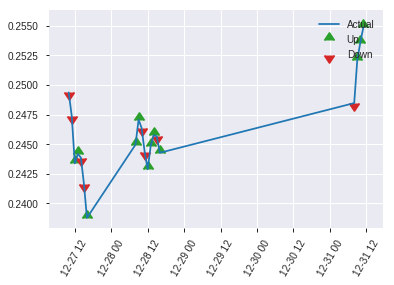


ModelMetricsBinomialGLM: glm
** Reported on test data. **

MSE: 0.20594448683373442
RMSE: 0.4538110695363594
LogLoss: 0.597225514959851
Null degrees of freedom: 222
Residual degrees of freedom: 172
Null deviance: 308.2619463225164
Residual deviance: 266.36257967209355
AIC: 368.36257967209355
AUC: 0.7514544279250162
pr_auc: 0.7371009149306508
Gini: 0.5029088558500323
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.23570185826213058: 


0    1    Error    Rate
-----  ---  ---  -------  ------------
0      43   76   0.6387   (76.0/119.0)
1      10   94   0.0962   (10.0/104.0)
Total  53   170  0.3857   (86.0/223.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.235702     0.686131  169
max f2                       0.132547     0.831987  202
max f0point5                 0.470047     0.719697  72
max accuracy                 0.470047     0.717489  72
max precision                0.865311     1         0
max recall                   0.085971     1         216
max specificity              0.865311     1         0
max absolute_mcc             0.470047     0.439732  72
max min_per_class_accuracy   0.408708     0.672269  108
max mean_per_class_accuracy  0.470047     0.706812  72

Gains/Lift Table: Avg response rate: 46.64 %, avg score: 39.69 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0134529                   0.797882           2.14423   2.14423            1                0.82493    1                           0.82493             0.0288462       0.0288462                  114.423   114.423
    2        0.0224215                   0.751279           2.14423   2.14423            1                0.766226   1                           0.801449            0.0192308       0.0480769                  114.423   114.423
    3        0.0313901                   0.744864           2.14423   2.14423            1                0.745954   1                           0.785593            0.0192308       0.0673077                  114.423   114.423
    4        0.0403587                   0.728471           2.14423   2.14423            1                0.738272   1                           0.775077            0.0192308       0.0865385                  114.423   114.423
    5        0.0538117                   0.719958           1.42949   1.96554            0.666667         0.723742   0.916667                    0.762244            0.0192308       0.105769                   42.9487   96.5545
    6        0.103139                    0.669931           1.9493    1.95778            0.909091         0.700117   0.913043                    0.732531            0.0961538       0.201923                   94.9301   95.7776
    7        0.152466                    0.623492           1.75437   1.89197            0.818182         0.648885   0.882353                    0.705469            0.0865385       0.288462                   75.4371   89.1968
    8        0.201794                    0.554757           1.36451   1.76303            0.636364         0.586201   0.822222                    0.676314            0.0673077       0.355769                   36.451    76.3034
    9        0.300448                    0.478358           1.46198   1.66418            0.681818         0.518601   0.776119                    0.624528            0.144231        0.5                        46.1976   66.4179
    10       0.399103                    0.435936           1.07212   1.51783            0.5              0.459106   0.707865                    0.583637            0.105769        0.605769                   7.21154   51.7826
    11       0.502242                    0.403679           0.652592  1.34014            0.304348         0.419326   0.625                       0.549895            0.0673077       0.673077                   -34.7408  34.0144
    12       0.600897                    0.350587           0.77972   1.24813            0.363636         0.377013   0.58209                     0.521511            0.0769231       0.75                       -22.028   24.8134
    13       0.699552                    0.291039           0.877185  1.19582            0.409091         0.319525   0.557692                    0.493026            0.0865385       0.836538                   -12.2815  19.5821
    14       0.798206                    0.214661           0.77972   1.14439            0.363636         0.248718   0.533708                    0.46283             0.0769231       0.913462                   -22.028   14.4393
    15       0.896861                    0.136072           0.682255  1.09356            0.318182         0.18353    0.51                        0.432107            0.0673077       0.980769                   -31.7745  9.35577
    16       1                           0.0268169          0.186455  1                  0.0869565        0.0911852  0.466368                   

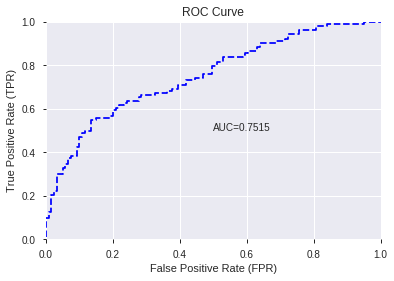

/usr/local/lib/python3.6/dist-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


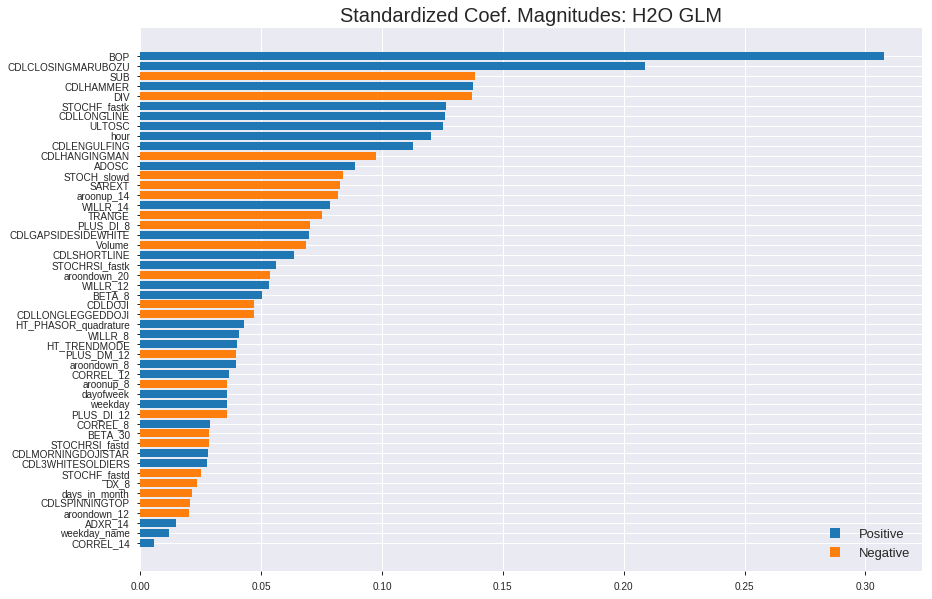

'log_likelihood'
--2019-08-27 21:13:43--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.17.216
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.17.216|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/GLM_grid_1_AutoML_20190827_211335_model_1',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'GLM_grid_1_AutoML_20190827_211335_model_1',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_18_sid_82c1',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training_py_18_s

['BOP',
 'CDLCLOSINGMARUBOZU',
 'SUB',
 'CDLHAMMER',
 'DIV',
 'STOCHF_fastk',
 'CDLLONGLINE',
 'ULTOSC',
 'hour',
 'CDLENGULFING',
 'CDLHANGINGMAN',
 'ADOSC',
 'STOCH_slowd',
 'SAREXT',
 'aroonup_14',
 'WILLR_14',
 'TRANGE',
 'PLUS_DI_8',
 'CDLGAPSIDESIDEWHITE',
 'Volume',
 'CDLSHORTLINE',
 'STOCHRSI_fastk',
 'aroondown_20',
 'WILLR_12',
 'BETA_8',
 'CDLDOJI',
 'CDLLONGLEGGEDDOJI',
 'HT_PHASOR_quadrature',
 'WILLR_8',
 'HT_TRENDMODE',
 'PLUS_DM_12',
 'aroondown_8',
 'CORREL_12',
 'aroonup_8',
 'dayofweek',
 'weekday',
 'PLUS_DI_12',
 'CORREL_8',
 'BETA_30',
 'STOCHRSI_fastd',
 'CDLMORNINGDOJISTAR',
 'CDL3WHITESOLDIERS',
 'STOCHF_fastd',
 'DX_8',
 'days_in_month',
 'CDLSPINNINGTOP',
 'aroondown_12',
 'ADXR_14',
 'weekday_name',
 'CORREL_14']

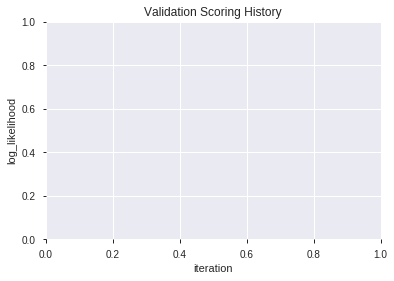

In [12]:
# GLM with top DeepLearning features
model_train(feature_name='DLF',model_algo="GLM",features_list = features_list[:model_selected_features])

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  XGBoost_grid_1_AutoML_20190827_211352_model_2  0.770362  0.595977              0.323610  0.452875  0.205096
1  XGBoost_grid_1_AutoML_20190827_211352_model_6  0.763090  0.596196              0.290037  0.452541  0.204793
2  XGBoost_grid_1_AutoML_20190827_211352_model_1  0.762201  0.592228              0.324863  0.450825  0.203243
3  XGBoost_grid_1_AutoML_20190827_211352_model_4  0.761635  0.603643              0.278079  0.456281  0.208192
4  XGBoost_grid_1_AutoML_20190827_211352_model_3  0.759939  0.592933              0.305672  0.451498  0.203850
5               XGBoost_3_AutoML_20190827_211352  0.759292  0.600985              0.381181  0.456091  0.208019
6               XGBoost_2_AutoML_20190827_211352  0.752101  0.600488              0.284098  0.455315  0.207311
7               XGBoost_1_AutoML_20190827_211352  0.748546  0.606856              0.287048  0.457965  0.209732
8  XGBoost_grid_1_AutoML_20190827_211352_model_5  0.739011  0.615912              0.313429  0.462492  0.213899
9  XGBoost_grid_1_AutoML_20190827_211352_model_7  0.734405  0.627042              0.347043  0.466174  0.217319

variable  relative_importance  scaled_importance  percentage
0                    BOP          2108.247314           1.000000    0.265677
1                    DIV           605.855530           0.287374    0.076349
2                 TRANGE           457.993256           0.217239    0.057715
3           STOCHF_fastk           417.025177           0.197807    0.052553
4   HT_PHASOR_quadrature           301.533936           0.143026    0.037999
5                   hour           294.640167           0.139756    0.037130
6                 SAREXT           267.526794           0.126895    0.033713
7                 Volume           219.309006           0.104024    0.027637
8                 ULTOSC           216.545135           0.102713    0.027289
9                  ADOSC           195.270798           0.092622    0.024608
10                BETA_8           163.318481           0.077466    0.020581
11               ADXR_14           160.318359           0.076043    0.020203
12               BETA_30           159.524490           0.075667    0.020103
13             PLUS_DI_8           152.898849           0.072524    0.019268
14                  DX_8           149.968094           0.071134    0.018899
15        STOCHRSI_fastk           148.815201           0.070587    0.018753
16    CDLCLOSINGMARUBOZU           145.445770           0.068989    0.018329
17               WILLR_8           137.257431           0.065105    0.017297
18                   SUB           134.823578           0.063951    0.016990
19             CDLHAMMER           129.504852           0.061428    0.016320
20        STOCHRSI_fastd           125.848969           0.059694    0.015859
21          aroondown_20           115.730988           0.054894    0.014584
22            PLUS_DM_12           109.978340           0.052166    0.013859
23            aroonup_14           109.047440           0.051724    0.013742
24           STOCH_slowd            93.647522           0.044420    0.011801
25          aroondown_12            87.438858           0.041475    0.011019
26           aroondown_8            75.250351           0.035693    0.009483
27             dayofweek            66.998634           0.031779    0.008443
28            PLUS_DI_12            66.154945           0.031379    0.008337
29          HT_TRENDMODE            59.744770           0.028339    0.007529
30              WILLR_12            58.990204           0.027981    0.007434
31             CORREL_14            58.572811           0.027783    0.007381
32             aroonup_8            55.545750           0.026347    0.007000
33          STOCHF_fastd            48.147446           0.022838    0.006067
34             CORREL_12            44.245125           0.020987    0.005576
35          CDLSHORTLINE            36.510269           0.017318    0.004601
36              WILLR_14            32.287609           0.015315    0.004069
37          weekday_name            27.160114           0.012883    0.003423
38           CDLLONGLINE            19.829510           0.009406    0.002499
39         days_in_month            18.348366           0.008703    0.002312
40              CORREL_8            17.465000           0.008284    0.002201
41               CDLDOJI            17.130312           0.008125    0.002159
42        CDLSPINNINGTOP            12.325080           0.005846    0.001553
43          CDLENGULFING            11.159836           0.005293    0.001406
44               weekday             1.989111           0.000943    0.000251

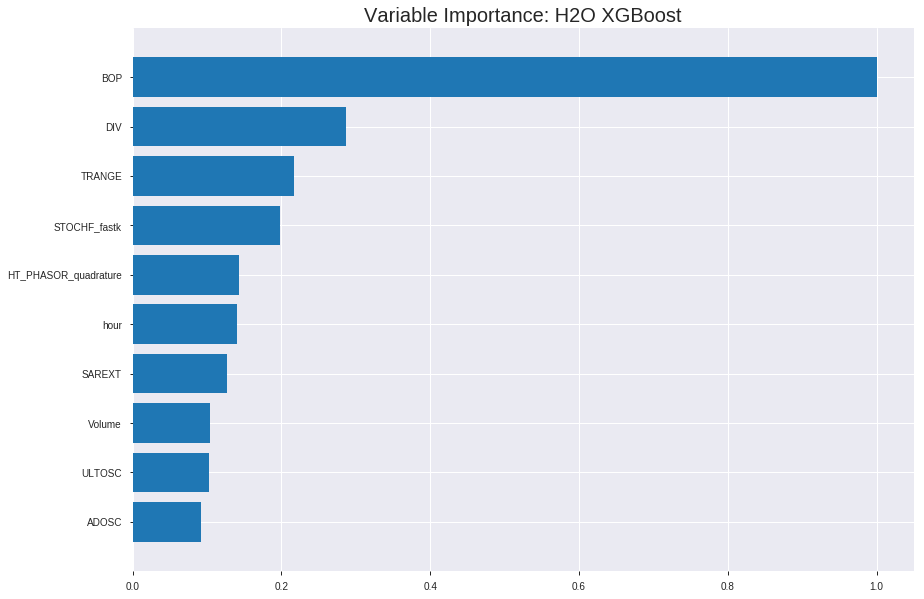

Model Details
H2OXGBoostEstimator :  XGBoost
Model Key:  XGBoost_grid_1_AutoML_20190827_211352_model_2


ModelMetricsBinomial: xgboost
** Reported on train data. **

MSE: 0.14687699223587167
RMSE: 0.3832453420928579
LogLoss: 0.46487412117515015
Mean Per-Class Error: 0.1856862745098039
AUC: 0.8965603190428714
pr_auc: 0.8826083311083437
Gini: 0.7931206380857427
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.46378560066223146: 


0    1    Error    Rate
-----  ---  ---  -------  --------------
0      676  174  0.2047   (174.0/850.0)
1      118  590  0.1667   (118.0/708.0)
Total  794  764  0.1874   (292.0/1558.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.463786     0.80163   199
max f2                       0.282073     0.865457  297
max f0point5                 0.564731     0.822011  145
max accuracy                 0.530478     0.819641  165
max precision                0.877479     1         0
max recall                   0.179573     1         350
max specificity              0.877479     1         0
max absolute_mcc             0.530478     0.636071  165
max min_per_class_accuracy   0.484336     0.809322  189
max mean_per_class_accuracy  0.463786     0.814314  199

Gains/Lift Table: Avg response rate: 45.44 %, avg score: 45.56 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0102696                   0.845839           2.20056   2.20056            1                0.859325  1                           0.859325            0.0225989       0.0225989                  120.056   120.056
    2        0.0205392                   0.830274           2.20056   2.20056            1                0.839428  1                           0.849376            0.0225989       0.0451977                  120.056   120.056
    3        0.0301669                   0.813935           2.20056   2.20056            1                0.822098  1                           0.84067             0.0211864       0.0663842                  120.056   120.056
    4        0.0404365                   0.80499            2.20056   2.20056            1                0.808438  1                           0.832485            0.0225989       0.0889831                  120.056   120.056
    5        0.0500642                   0.79672            2.20056   2.20056            1                0.800854  1                           0.826402            0.0211864       0.110169                   120.056   120.056
    6        0.100128                    0.746337           2.14414   2.17235            0.974359         0.769233  0.987179                    0.797817            0.107345        0.217514                   114.414   117.235
    7        0.150193                    0.713564           2.00308   2.11593            0.910256         0.730763  0.961538                    0.775466            0.100282        0.317797                   100.308   111.593
    8        0.200257                    0.680208           2.00308   2.08772            0.910256         0.698951  0.948718                    0.756337            0.100282        0.418079                   100.308   108.772
    9        0.300385                    0.610937           1.72095   1.96546            0.782051         0.645703  0.893162                    0.719459            0.172316        0.590395                   72.0955   96.5462
    10       0.399872                    0.534048           1.49071   1.84734            0.677419         0.573019  0.839486                    0.683025            0.148305        0.738701                   49.0705   84.7344
    11       0.5                         0.45474            0.987433  1.67514            0.448718         0.496817  0.761232                    0.645736            0.0988701       0.837571                   -1.2567   67.5141
    12       0.600128                    0.368471           0.705309  1.51333            0.320513         0.409752  0.687701                    0.606363            0.0706215       0.908192                   -29.4691  51.333
    13       0.699615                    0.300325           0.45431   1.36274            0.206452         0.332646  0.619266                    0.56744             0.0451977       0.95339                    -54.569   36.2735
    14       0.799743                    0.229599           0.324442  1.23274            0.147436         0.267399  0.560193                    0.529875            0.0324859       0.985876                   -67.5558  23.274
    15       0.899872                    0.158129           0.141062  1.11127            0.0641026        0.191975  0.504993                    0.492277            0.0141243       1                          -85.8938  11.127
    16       1                           0.0857364          0         1                  0                0.126299  0.454429                    0.455632            



ModelMetricsBinomial: xgboost
** Reported on validation data. **

MSE: 0.1978275941991974
RMSE: 0.44477814042418656
LogLoss: 0.5775547713482122
Mean Per-Class Error: 0.2534833651541618
AUC: 0.791983182353658
pr_auc: 0.7349479607738196
Gini: 0.5839663647073161
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.3063267767429352: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      148  91   0.3808   (91.0/239.0)
1      26   180  0.1262   (26.0/206.0)
Total  174  271  0.2629   (117.0/445.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.306327     0.754717  244
max f2                       0.216209     0.844212  294
max f0point5                 0.473743     0.70802   131
max accuracy                 0.306327     0.737079  244
max precision                0.865235     1         0
max recall                   0.0971457    1         396
max specificity              0.865235     1         0
max absolute_mcc             0.306327     0.50379   244
max min_per_class_accuracy   0.377395     0.711297  192
max mean_per_class_accuracy  0.306327     0.746517  244

Gains/Lift Table: Avg response rate: 46.29 %, avg score: 37.58 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.011236                    0.782665           1.72816   1.72816            0.8              0.818763  0.8                         0.818763            0.0194175       0.0194175                  72.8155   72.8155
    2        0.0202247                   0.748592           2.16019   1.92017            1                0.763314  0.888889                    0.794119            0.0194175       0.038835                   116.019   92.0173
    3        0.0314607                   0.730242           2.16019   2.00589            1                0.737501  0.928571                    0.773898            0.0242718       0.0631068                  116.019   100.589
    4        0.0404494                   0.724271           1.62015   1.92017            0.75             0.726298  0.888889                    0.76332             0.0145631       0.0776699                  62.0146   92.0173
    5        0.0516854                   0.695232           2.16019   1.97235            1                0.705108  0.913043                    0.750665            0.0242718       0.101942                   116.019   97.2351
    6        0.101124                    0.642101           1.47286   1.72816            0.681818         0.66462   0.8                         0.708599            0.0728155       0.174757                   47.286    72.8155
    7        0.150562                    0.595872           1.47286   1.64433            0.681818         0.618891  0.761194                    0.679143            0.0728155       0.247573                   47.286    64.4327
    8        0.2                         0.542924           1.66924   1.65049            0.772727         0.565181  0.764045                    0.650972            0.0825243       0.330097                   66.9241   65.0485
    9        0.301124                    0.48344            1.72816   1.67657            0.8              0.514003  0.776119                    0.604975            0.174757        0.504854                   72.8155   67.6569
    10       0.4                         0.426543           1.031     1.51699            0.477273         0.457803  0.702247                    0.568596            0.101942        0.606796                   3.10018   51.699
    11       0.501124                    0.369818           1.34412   1.48211            0.622222         0.398227  0.686099                    0.534216            0.135922        0.742718                   34.4121   48.2106
    12       0.6                         0.310867           1.12919   1.42395            0.522727         0.342161  0.659176                    0.502567            0.11165         0.854369                   12.9192   42.3948
    13       0.698876                    0.229101           0.687335  1.31973            0.318182         0.273832  0.610932                    0.470205            0.0679612       0.92233                    -31.2665  31.9733
    14       0.8                         0.177398           0.288026  1.18932            0.133333         0.20516   0.550562                    0.436702            0.0291262       0.951456                   -71.1974  18.932
    15       0.898876                    0.128162           0.245477  1.0855             0.113636         0.153173  0.5025                      0.405514            0.0242718       0.975728                   -75.4523  8.54976
    16       1                           0.0875609          0.240022  1                  0.111111         0.111839  0.462921                    0.375817           


Scoring History: 


timestamp            duration    number_of_trees    training_rmse    training_logloss    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------  -----------------  ---------------  ------------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-08-27 21:14:01  1.338 sec   0                  0.5              0.693147            0.5             0                  1                0.545571                         0.5                0.693147              0.5               0                    1                  0.537079
    2019-08-27 21:14:01  1.460 sec   5                  0.476703         0.647447            0.829401        0.756824           2.00051          0.235558                         0.480872           0.655422              0.792653          0.722979             1.72816            0.267416
    2019-08-27 21:14:01  1.556 sec   10                 0.458684         0.61285             0.832178        0.7713             2.10054          0.234917                         0.466749           0.627753              0.798574          0.722294             2.16019            0.258427
    2019-08-27 21:14:02  1.641 sec   15                 0.444938         0.5865              0.837625        0.807533           2.20056          0.231707                         0.459318           0.612659              0.796766          0.720986             2.16019            0.27191
    2019-08-27 21:14:02  1.726 sec   20                 0.43421          0.56572             0.84304         0.81495            2.20056          0.238768                         0.454508           0.602387              0.795924          0.72376              1.72816            0.269663
    2019-08-27 21:14:02  1.818 sec   25                 0.425141         0.548064            0.852717        0.829529           2.20056          0.217587                         0.450856           0.594083              0.796909          0.733088             1.72816            0.249438
    2019-08-27 21:14:02  1.907 sec   30                 0.417893         0.533697            0.859515        0.840069           2.20056          0.221438                         0.44876            0.588986              0.795883          0.735253             2.16019            0.260674
    2019-08-27 21:14:02  2.004 sec   35                 0.411175         0.520502            0.866804        0.846459           2.20056          0.216303                         0.447062           0.584869              0.79635           0.736066             1.72816            0.25618
    2019-08-27 21:14:02  2.107 sec   40                 0.406213         0.510377            0.870914        0.850564           2.20056          0.207317                         0.447008           0.583756              0.794481          0.734898             1.72816            0.260674
    2019-08-27 21:14:02  2.219 sec   45                 0.400299         0.498738            0.877695        0.8602             2.20056          0.20154                          0.445944           0.581007              0.793466          0.734984             1.72816            0.27191
    2019-08-27 21:14:02  2.317 sec   50                 0.395674         0.489479            0.882386        0.866385           2.20056          0.204108                         0.445749           0.580051              0.79305           0.733652             1.72816            0.27191
    2019-08-27 21:14:02  2.417 sec   55                 0.391286         0.480762            0.88736         0.870578           2.20056          0.198973                         0.445534           0.579251              0.791465          0.731

Variable Importances: 


variable              relative_importance    scaled_importance      percentage
--------------------  ---------------------  ---------------------  ---------------------
BOP                   2108.247314453125      1.0                    0.2656772685383562
DIV                   605.8555297851562      0.28737403132531153    0.07634874769136478
TRANGE                457.9932556152344      0.21723886589369942    0.05771542851100834
STOCHF_fastk          417.0251770019531      0.19780657332895907    0.052552710100969915
HT_PHASOR_quadrature  301.533935546875       0.1430258838608279     0.037998726154428925
---                   ---                    ---                    ---
CORREL_8              17.46500015258789      0.008284132526984045   0.0022009057019788713
CDLDOJI               17.130311965942383     0.008125380665022192   0.0021587289409174685
CDLSPINNINGTOP        12.325079917907715     0.005846126226943547   0.0015531828475048083
CDLENGULFING          11.159835815429688     0.005293418726979157   0.0014063410286136052
weekday               1.989111065864563      0.0009434903828541265  0.0002506639478088923


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.7130044843049327)

('F1', 0.7058823529411766)

('auc', 0.7703619909502262)

('logloss', 0.5959768382721506)

('mean_per_class_error', 0.2900775694893343)

('rmse', 0.45287537724671817)

('mse', 0.20509610731635727)

xgboost prediction progress: |████████████████████████████████████████████| 100%


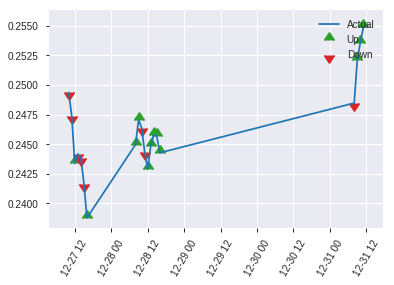


ModelMetricsBinomial: xgboost
** Reported on test data. **

MSE: 0.20509610731635727
RMSE: 0.45287537724671817
LogLoss: 0.5959768382721506
Mean Per-Class Error: 0.2900775694893343
AUC: 0.7703619909502262
pr_auc: 0.7506883031684346
Gini: 0.5407239819004523
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.2838468849658966: 


0    1    Error    Rate
-----  ---  ---  -------  ------------
0      58   61   0.5126   (61.0/119.0)
1      14   90   0.1346   (14.0/104.0)
Total  72   151  0.3363   (75.0/223.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.283847     0.705882  150
max f2                       0.135857     0.837359  204
max f0point5                 0.482616     0.714286  71
max accuracy                 0.482616     0.713004  71
max precision                0.788443     1         0
max recall                   0.135857     1         204
max specificity              0.788443     1         0
max absolute_mcc             0.482616     0.431048  71
max min_per_class_accuracy   0.386243     0.705882  108
max mean_per_class_accuracy  0.378204     0.709922  112

Gains/Lift Table: Avg response rate: 46.64 %, avg score: 38.23 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0134529                   0.754548           2.14423   2.14423            1                0.772912  1                           0.772912            0.0288462       0.0288462                  114.423   114.423
    2        0.0224215                   0.73773            2.14423   2.14423            1                0.747324  1                           0.762677            0.0192308       0.0480769                  114.423   114.423
    3        0.0313901                   0.729799           1.07212   1.83791            0.5              0.731286  0.857143                    0.753708            0.00961538      0.0576923                  7.21154   83.7912
    4        0.0403587                   0.691905           2.14423   1.90598            1                0.716201  0.888889                    0.745373            0.0192308       0.0769231                  114.423   90.5983
    5        0.0538117                   0.673217           2.14423   1.96554            1                0.682546  0.916667                    0.729666            0.0288462       0.105769                   114.423   96.5545
    6        0.103139                    0.603462           2.14423   2.051              1                0.635449  0.956522                    0.684606            0.105769        0.211538                   114.423   105.1
    7        0.152466                    0.566767           1.55944   1.89197            0.727273         0.587396  0.882353                    0.653156            0.0769231       0.288462                   55.9441   89.1968
    8        0.201794                    0.540691           1.36451   1.76303            0.636364         0.555371  0.822222                    0.629253            0.0673077       0.355769                   36.451    76.3034
    9        0.300448                    0.487256           1.46198   1.66418            0.681818         0.506884  0.776119                    0.589072            0.144231        0.5                        46.1976   66.4179
    10       0.399103                    0.419618           0.77972   1.44555            0.363636         0.454952  0.674157                    0.555919            0.0769231       0.576923                   -22.028   44.5549
    11       0.502242                    0.379348           1.39841   1.43587            0.652174         0.400851  0.669643                    0.524074            0.144231        0.721154                   39.8411   43.5869
    12       0.600897                    0.346949           0.682255  1.31214            0.318182         0.366348  0.61194                     0.498179            0.0673077       0.788462                   -31.7745  31.2141
    13       0.699552                    0.267486           0.77972   1.23706            0.363636         0.304887  0.576923                    0.47092             0.0769231       0.865385                   -22.028   23.7056
    14       0.798206                    0.198127           0.682255  1.16849            0.318182         0.237106  0.544944                    0.442022            0.0673077       0.932692                   -31.7745  16.8485
    15       0.896861                    0.154002           0.487325  1.09356            0.227273         0.172126  0.51                        0.412333            0.0480769       0.980769                   -51.2675  9.35577
    16       1                           0.0944787          0.186455  1                  0.0869565        0.12132   0.466368                    0.382318           

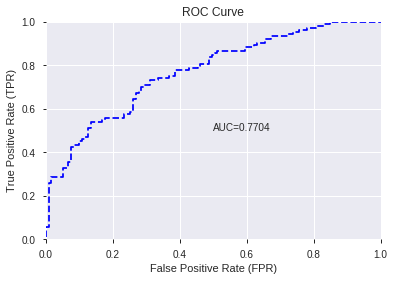

This function is available for GLM models only


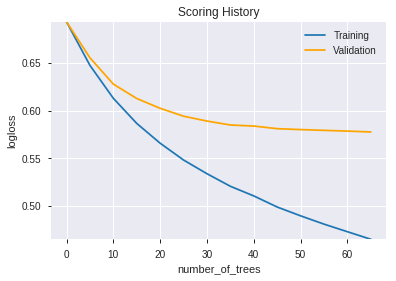

--2019-08-27 21:14:19--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.217.39.4
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.217.39.4|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
Exception in thread "main" java.lang.StackOverflowError
	at java.base/java.lang.String.indexOf(String.java:1578)
	at java.base/java.lang.String.indexOf(String.java:1535)
	at java.base/java.lang.String.split(String.java:2274)
	at java.base/java.lang.String.split(String.java:2364)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:101)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:106)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:

[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/XGBoost_grid_1_AutoML_20190827_211352_model_2',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'XGBoost_grid_1_AutoML_20190827_211352_model_2',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_26_sid_82c1',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training

['BOP',
 'DIV',
 'TRANGE',
 'STOCHF_fastk',
 'HT_PHASOR_quadrature',
 'hour',
 'SAREXT',
 'Volume',
 'ULTOSC',
 'ADOSC',
 'BETA_8',
 'ADXR_14',
 'BETA_30',
 'PLUS_DI_8',
 'DX_8',
 'STOCHRSI_fastk',
 'CDLCLOSINGMARUBOZU',
 'WILLR_8',
 'SUB',
 'CDLHAMMER',
 'STOCHRSI_fastd',
 'aroondown_20',
 'PLUS_DM_12',
 'aroonup_14',
 'STOCH_slowd',
 'aroondown_12',
 'aroondown_8',
 'dayofweek',
 'PLUS_DI_12',
 'HT_TRENDMODE',
 'WILLR_12',
 'CORREL_14',
 'aroonup_8',
 'STOCHF_fastd',
 'CORREL_12',
 'CDLSHORTLINE',
 'WILLR_14',
 'weekday_name',
 'CDLLONGLINE',
 'days_in_month',
 'CORREL_8',
 'CDLDOJI',
 'CDLSPINNINGTOP',
 'CDLENGULFING',
 'weekday']

In [13]:
# XGBoost with top DeepLearning features
model_train(feature_name='DLF',model_algo="XGBoost",features_list = features_list[:model_selected_features])

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  GLM_grid_1_AutoML_20190827_211427_model_1  0.722447  0.620094              0.357224  0.465289  0.216493

variable  relative_importance  scaled_importance    percentage
0                          BOP             0.182489           1.000000  3.737396e-02
1           CDLCLOSINGMARUBOZU             0.131244           0.719189  2.687896e-02
2                  CDLLONGLINE             0.101245           0.554798  2.073500e-02
3                          SUB             0.086240           0.472575  1.766200e-02
4                          DIV             0.081128           0.444565  1.661514e-02
...                        ...                  ...                ...           ...
1028                   MA_14_2             0.000006           0.000031  1.166329e-06
1029  BBANDS_middleband_14_2_4             0.000004           0.000020  7.583232e-07
1030   BBANDS_lowerband_14_3_3             0.000003           0.000018  6.727705e-07
1031    BBANDS_upperband_8_8_5             0.000002           0.000011  3.954712e-07
1032  BBANDS_middleband_14_2_5             0.000001           0.000008  3.029324e-07

[1033 rows x 4 columns]

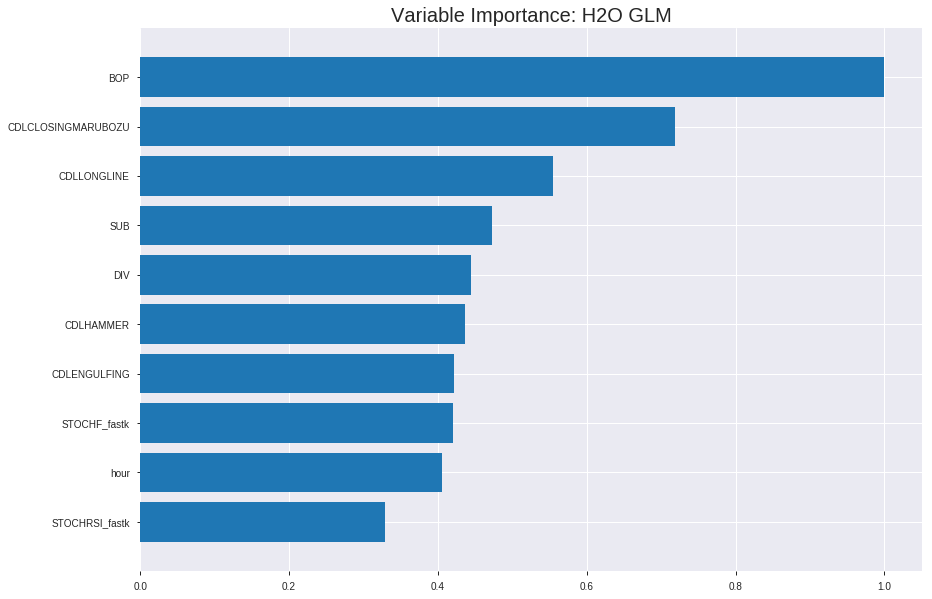

Model Details
H2OGeneralizedLinearEstimator :  Generalized Linear Modeling
Model Key:  GLM_grid_1_AutoML_20190827_211427_model_1


ModelMetricsBinomialGLM: glm
** Reported on train data. **

MSE: 0.1939370664004321
RMSE: 0.4403828634273047
LogLoss: 0.5714371195499811
Null degrees of freedom: 1557
Residual degrees of freedom: 524
Null deviance: 2146.8864027643094
Residual deviance: 1780.598064517741
AIC: 3848.598064517741
AUC: 0.7845471917580592
pr_auc: 0.7373913982603604
Gini: 0.5690943835161184
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.37600255613516953: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      425  425   0.5      (425.0/850.0)
1      86   622   0.1215   (86.0/708.0)
Total  511  1047  0.328    (511.0/1558.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.376003     0.708832  251
max f2                       0.242851     0.831941  326
max f0point5                 0.51777      0.6917    159
max accuracy                 0.457841     0.712452  197
max precision                0.893738     1         0
max recall                   0.100167     1         386
max specificity              0.893738     1         0
max absolute_mcc             0.446082     0.428146  204
max min_per_class_accuracy   0.465092     0.705882  193
max mean_per_class_accuracy  0.446082     0.714882  204

Gains/Lift Table: Avg response rate: 45.44 %, avg score: 45.44 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0102696                   0.829522           2.06303   2.06303            0.9375           0.851357  0.9375                      0.851357            0.0211864       0.0211864                  106.303   106.303
    2        0.0205392                   0.797227           1.65042   1.85673            0.75             0.814641  0.84375                     0.832999            0.0169492       0.0381356                  65.0424   85.6727
    3        0.0301669                   0.773171           2.05386   1.91964            0.933333         0.783741  0.87234                     0.817279            0.019774        0.0579096                  105.386   91.9642
    4        0.0404365                   0.746731           2.06303   1.95606            0.9375           0.759659  0.888889                    0.802645            0.0211864       0.079096                   106.303   95.6058
    5        0.0500642                   0.730194           1.76045   1.91844            0.8              0.739376  0.871795                    0.790478            0.0169492       0.0960452                  76.0452   91.8441
    6        0.100128                    0.675307           1.86202   1.89023            0.846154         0.699896  0.858974                    0.745187            0.0932203       0.189266                   86.2017   89.0229
    7        0.150193                    0.63908            1.77738   1.85261            0.807692         0.656759  0.84188                     0.715711            0.0889831       0.278249                   77.7379   85.2612
    8        0.200257                    0.606641           1.52347   1.77033            0.692308         0.622583  0.804487                    0.692429            0.0762712       0.35452                    52.3468   77.0326
    9        0.300385                    0.559331           1.42472   1.65513            0.647436         0.58248   0.752137                    0.655779            0.142655        0.497175                   42.4725   65.5126
    10       0.399872                    0.502731           1.24935   1.55417            0.567742         0.529492  0.70626                     0.62436             0.124294        0.621469                   24.9353   55.4171
    11       0.5                         0.452464           1.11439   1.4661             0.50641          0.478353  0.666239                    0.595121            0.111582        0.733051                   11.4389   46.6102
    12       0.600128                    0.405584           0.846371  1.3627             0.384615         0.426864  0.619251                    0.567048            0.0847458       0.817797                   -15.3629  36.2703
    13       0.699615                    0.363939           0.795043  1.28198            0.36129          0.384159  0.582569                    0.541041            0.079096        0.896893                   -20.4957  28.1981
    14       0.799743                    0.304001           0.521929  1.18682            0.237179         0.335105  0.539326                    0.515257            0.0522599       0.949153                   -47.8071  18.6822
    15       0.899872                    0.219052           0.380867  1.09714            0.173077         0.263255  0.498573                    0.487217            0.0381356       0.987288                   -61.9133  9.71433
    16       1                           0.00835691         0.126956  1                  0.0576923        0.159754  0.454429                    0.454429         



ModelMetricsBinomialGLM: glm
** Reported on validation data. **

MSE: 0.21109998808981648
RMSE: 0.4594561873452315
LogLoss: 0.6093923212740281
Null degrees of freedom: 444
Residual degrees of freedom: -589
Null deviance: 614.5808798679772
Residual deviance: 542.359165933885
AIC: 2610.359165933885
AUC: 0.7583275785026607
pr_auc: 0.7051914106208108
Gini: 0.5166551570053215
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.2901999775413768: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      123  116  0.4854   (116.0/239.0)
1      24   182  0.1165   (24.0/206.0)
Total  147  298  0.3146   (140.0/445.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.2902       0.722222  264
max f2                       0.0770286    0.82466   381
max f0point5                 0.465285     0.7       124
max accuracy                 0.465285     0.703371  124
max precision                0.817177     1         0
max recall                   0.0770286    1         381
max specificity              0.817177     1         0
max absolute_mcc             0.2902       0.422086  264
max min_per_class_accuracy   0.376945     0.684466  191
max mean_per_class_accuracy  0.318845     0.700989  240

Gains/Lift Table: Avg response rate: 46.29 %, avg score: 36.84 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.011236                    0.772245           2.16019   2.16019            1                0.796451   1                           0.796451            0.0242718       0.0242718                  116.019   116.019
    2        0.0202247                   0.722991           1.62015   1.92017            0.75             0.75577    0.888889                    0.778371            0.0145631       0.038835                   62.0146   92.0173
    3        0.0314607                   0.687675           2.16019   2.00589            1                0.703689   0.928571                    0.751699            0.0242718       0.0631068                  116.019   100.589
    4        0.0404494                   0.673021           2.16019   2.04018            1                0.679354   0.944444                    0.735622            0.0194175       0.0825243                  116.019   104.018
    5        0.0516854                   0.659368           0.864078  1.78451            0.4              0.66484    0.826087                    0.720235            0.00970874      0.092233                   -13.5922  78.4508
    6        0.101124                    0.609658           1.47286   1.63215            0.681818         0.633523   0.755556                    0.677842            0.0728155       0.165049                   47.286    63.2147
    7        0.150562                    0.56951            1.47286   1.57984            0.681818         0.591698   0.731343                    0.649556            0.0728155       0.237864                   47.286    57.9844
    8        0.2                         0.527879           1.66924   1.60194            0.772727         0.549177   0.741573                    0.624743            0.0825243       0.320388                   66.9241   60.1942
    9        0.301124                    0.465565           1.77616   1.66045            0.822222         0.492867   0.768657                    0.580456            0.179612        0.5                        77.616    66.0448
    10       0.4                         0.416036           1.0801    1.51699            0.5              0.44067    0.702247                    0.545902            0.106796        0.606796                   8.00971   51.699
    11       0.501124                    0.365018           0.960086  1.40461            0.444444         0.390208   0.650224                    0.514484            0.0970874       0.703883                   -3.99137  40.4611
    12       0.6                         0.320261           1.0801    1.35113            0.5              0.342838   0.625468                    0.486198            0.106796        0.81068                    8.00971   35.1133
    13       0.698876                    0.273232           0.785525  1.27111            0.363636         0.297421   0.588424                    0.45949             0.0776699       0.88835                    -21.4475  27.1111
    14       0.8                         0.195611           0.528047  1.17718            0.244444         0.235078   0.544944                    0.431123            0.0533981       0.941748                   -47.1953  17.7184
    15       0.898876                    0.11969            0.196381  1.0693             0.0909091        0.161999   0.495                       0.401519            0.0194175       0.961165                   -80.3619  6.92961
    16       1                           0.00189146         0.384035  1                  0.177778         0.0741537  0.462921                    


Scoring History: 


timestamp            duration    iteration    lambda    predictors    deviance_train    deviance_test
--  -------------------  ----------  -----------  --------  ------------  ----------------  ---------------
    2019-08-27 21:14:30  0.000 sec   2            19        1033          1.3466            1.35153
    2019-08-27 21:14:32  2.123 sec   4            14        1034          1.33887           1.34324
    2019-08-27 21:14:34  4.181 sec   6            10        1034          1.32954           1.33438
    2019-08-27 21:14:37  6.318 sec   8            7.3       1034          1.31837           1.32405
    2019-08-27 21:14:39  8.636 sec   10           5.3       1034          1.3052            1.31247
    2019-08-27 21:14:41  10.705 sec  12           3.9       1034          1.29006           1.29965
    2019-08-27 21:14:43  12.827 sec  14           2.8       1034          1.27308           1.28592
    2019-08-27 21:14:45  15.035 sec  16           2.1       1034          1.25465           1.27188
    2019-08-27 21:14:47  17.158 sec  18           1.5       1034          1.23526           1.25809
    2019-08-27 21:14:49  19.232 sec  20           1.1       1034          1.21548           1.24521
    2019-08-27 21:14:52  21.347 sec  22           0.79      1034          1.19587           1.23435
    2019-08-27 21:14:54  23.610 sec  24           0.58      1034          1.177             1.22584
    2019-08-27 21:14:56  25.705 sec  26           0.42      1034          1.15925           1.22048
    2019-08-27 21:14:58  27.777 sec  28           0.31      1034          1.14287           1.21878
    2019-08-27 21:15:00  29.843 sec  30           0.22      1034          1.12798           1.21997
    2019-08-27 21:15:02  32.013 sec  32           0.16      1034          1.11455           1.22454
    2019-08-27 21:15:04  34.095 sec  34           0.12      1034          1.10246           1.23333
    2019-08-27 21:15:06  36.176 sec  36           0.086     1034          1.09157           1.24588
    2019-08-27 21:15:09  38.267 sec  38           0.063     1034          1.0817            1.26181

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.6636771300448431)

('F1', 0.6844106463878328)

('auc', 0.7224466709760827)

('logloss', 0.6200938311091817)

('mean_per_class_error', 0.3453862314156432)

('rmse', 0.46528856701974547)

('mse', 0.21649345059928815)

glm prediction progress: |████████████████████████████████████████████████| 100%


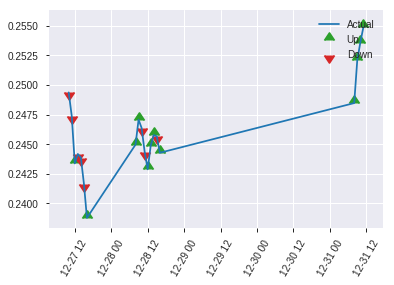


ModelMetricsBinomialGLM: glm
** Reported on test data. **

MSE: 0.21649345059928815
RMSE: 0.46528856701974547
LogLoss: 0.6200938311091817
Null degrees of freedom: 222
Residual degrees of freedom: -811
Null deviance: 308.2619463225164
Residual deviance: 276.5618486746951
AIC: 2344.5618486746953
AUC: 0.7224466709760827
pr_auc: 0.7184480133729636
Gini: 0.44489334195216546
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.27983346509986184: 


0    1    Error    Rate
-----  ---  ---  -------  ------------
0      50   69   0.5798   (69.0/119.0)
1      14   90   0.1346   (14.0/104.0)
Total  64   159  0.3722   (83.0/223.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.279833     0.684411  158
max f2                       0.170602     0.834684  200
max f0point5                 0.447983     0.643564  74
max accuracy                 0.447983     0.663677  74
max precision                0.79088      1         0
max recall                   0.113333     1         211
max specificity              0.79088      1         0
max absolute_mcc             0.566505     0.362696  34
max min_per_class_accuracy   0.385106     0.644231  108
max mean_per_class_accuracy  0.411833     0.654614  93

Gains/Lift Table: Avg response rate: 46.64 %, avg score: 38.09 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0134529                   0.719403           2.14423   2.14423            1                0.748502  1                           0.748502            0.0288462       0.0288462                  114.423   114.423
    2        0.0224215                   0.706749           2.14423   2.14423            1                0.711352  1                           0.733642            0.0192308       0.0480769                  114.423   114.423
    3        0.0313901                   0.670535           2.14423   2.14423            1                0.694819  1                           0.72255             0.0192308       0.0673077                  114.423   114.423
    4        0.0403587                   0.661628           2.14423   2.14423            1                0.662633  1                           0.709235            0.0192308       0.0865385                  114.423   114.423
    5        0.0538117                   0.659579           2.14423   2.14423            1                0.660446  1                           0.697038            0.0288462       0.115385                   114.423   114.423
    6        0.103139                    0.613871           1.9493    2.051              0.909091         0.642096  0.956522                    0.670761            0.0961538       0.211538                   94.9301   105.1
    7        0.152466                    0.56711            1.55944   1.89197            0.727273         0.587826  0.882353                    0.643929            0.0769231       0.288462                   55.9441   89.1968
    8        0.201794                    0.525595           0.97465   1.66774            0.454545         0.549423  0.777778                    0.620828            0.0480769       0.336538                   -2.53497  66.7735
    9        0.300448                    0.464906           1.16958   1.50416            0.545455         0.493625  0.701493                    0.57906             0.115385        0.451923                   16.958    50.4162
    10       0.399103                    0.421513           1.07212   1.39736            0.5              0.441932  0.651685                    0.545163            0.105769        0.557692                   7.21154   39.7364
    11       0.502242                    0.377535           1.0255    1.321              0.478261         0.396427  0.616071                    0.514619            0.105769        0.663462                   2.55017   32.0999
    12       0.600897                    0.317944           0.77972   1.23213            0.363636         0.354672  0.574627                    0.488359            0.0769231       0.740385                   -22.028   23.2133
    13       0.699552                    0.283646           1.07212   1.20957            0.5              0.300333  0.564103                    0.461843            0.105769        0.846154                   7.21154   20.9566
    14       0.798206                    0.238442           0.77972   1.15644            0.363636         0.26383   0.539326                    0.437369            0.0769231       0.923077                   -22.028   15.6439
    15       0.896861                    0.171379           0.58479   1.09356            0.272727         0.20197   0.51                        0.411475            0.0576923       0.980769                   -41.521   9.35577
    16       1                           0.050929           0.186455  1                  0.0869565        0.11495   0.466368                    0.380892           

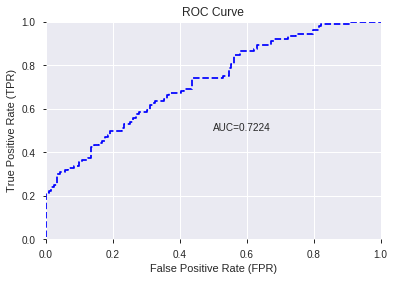

/usr/local/lib/python3.6/dist-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


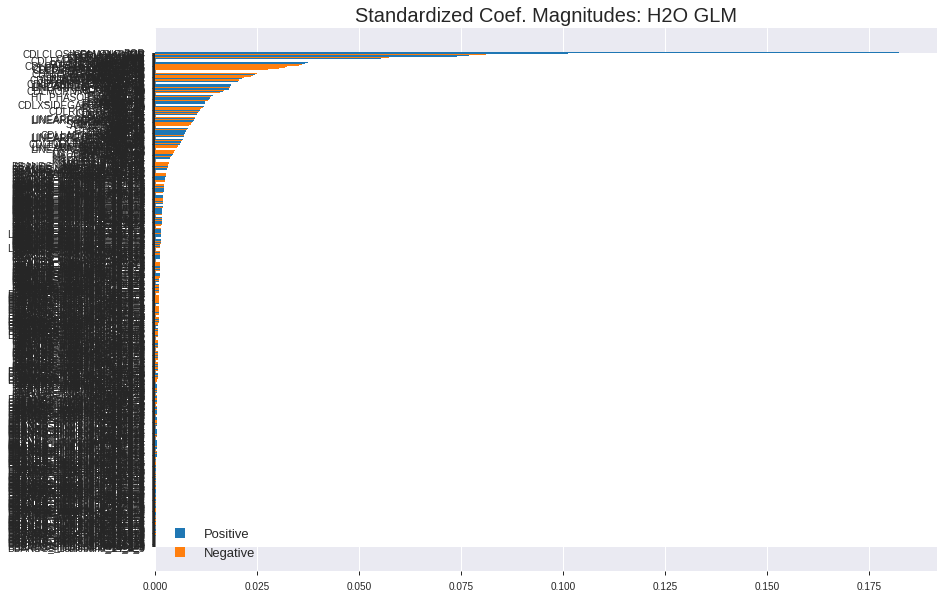

'log_likelihood'
--2019-08-27 21:15:34--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.176.195
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.176.195|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/GLM_grid_1_AutoML_20190827_211427_model_1',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'GLM_grid_1_AutoML_20190827_211427_model_1',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_34_sid_82c1',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training_py_34_s

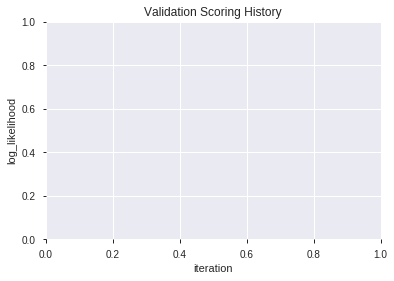

In [14]:
# GLM
glm_features = model_train(feature_name='All',model_algo="GLM")

In [15]:
# DeepLearning with top GLM features
model_train(feature_name='GLMF',model_algo="DeepLearning",features_list = features_list[:model_selected_features])

[]

In [16]:
# GLM with top GLM features
model_train(feature_name='GLMF',model_algo="GLM",features_list = features_list[:model_selected_features])

[]

In [17]:
# XGBoost with top GLM features
model_train(feature_name='GLMF',model_algo="XGBoost",features_list = features_list[:model_selected_features])

[]

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  XGBoost_grid_1_AutoML_20190827_211541_model_4  0.773028  0.601447              0.275654  0.454898  0.206932
1  XGBoost_grid_1_AutoML_20190827_211541_model_1  0.765029  0.586877              0.296663  0.448862  0.201477
2  XGBoost_grid_1_AutoML_20190827_211541_model_3  0.763413  0.584405              0.339811  0.447680  0.200417
3               XGBoost_3_AutoML_20190827_211541  0.763090  0.587503              0.275048  0.448133  0.200823
4  XGBoost_grid_1_AutoML_20190827_211541_model_6  0.759777  0.593278              0.302077  0.451408  0.203769
5  XGBoost_grid_1_AutoML_20190827_211541_model_2  0.756383  0.608414              0.297875  0.458437  0.210165
6               XGBoost_2_AutoML_20190827_211541  0.753313  0.608566              0.345225  0.459085  0.210759
7  XGBoost_grid_1_AutoML_20190827_211541_model_5  0.750808  0.601680              0.343407  0.454382  0.206463
8               XGBoost_1_AutoML_20190827_211541  0.742566  0.613356              0.333832  0.460511  0.212071
9  XGBoost_grid_1_AutoML_20190827_211541_model_7  0.742081  0.616723              0.329670  0.461891  0.213343

variable  relative_importance  scaled_importance  percentage
0                        BOP          1689.267822           1.000000    0.338419
1                        DIV           438.194641           0.259399    0.087786
2                     TRANGE           296.532043           0.175539    0.059406
3               STOCHF_fastk           212.825562           0.125987    0.042636
4                       hour           178.035751           0.105392    0.035667
..                       ...                  ...                ...         ...
127                 SAR_0.14             4.531925           0.002683    0.000908
128                CORREL_12             4.139762           0.002451    0.000829
129   BBANDS_upperband_8_2_3             3.312893           0.001961    0.000664
130  BBANDS_upperband_30_1_5             2.883831           0.001707    0.000578
131  BBANDS_upperband_20_0_3             2.105368           0.001246    0.000422

[132 rows x 4 columns]

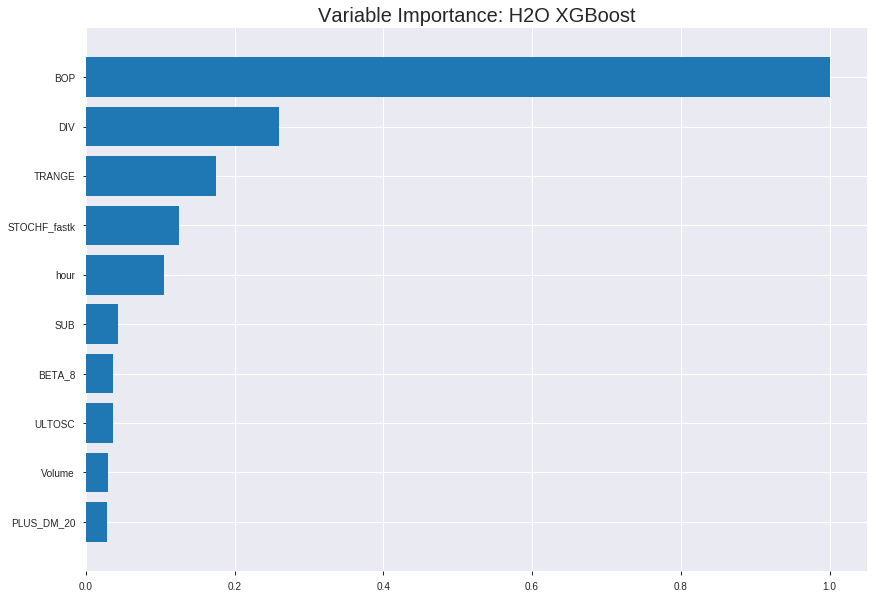

Model Details
H2OXGBoostEstimator :  XGBoost
Model Key:  XGBoost_grid_1_AutoML_20190827_211541_model_4


ModelMetricsBinomial: xgboost
** Reported on train data. **

MSE: 0.16964691498484083
RMSE: 0.41188216152783413
LogLoss: 0.5161423955655785
Mean Per-Class Error: 0.2412445995347292
AUC: 0.843084911930874
pr_auc: 0.8186215926487092
Gini: 0.686169823861748
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4056084811687469: 


0    1    Error    Rate
-----  ---  ---  -------  --------------
0      555  295  0.3471   (295.0/850.0)
1      105  603  0.1483   (105.0/708.0)
Total  660  898  0.2567   (400.0/1558.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.405608     0.750934  231
max f2                       0.309082     0.844928  280
max f0point5                 0.544369     0.75487   155
max accuracy                 0.521605     0.764442  168
max precision                0.8797       1         0
max recall                   0.148568     1         368
max specificity              0.8797       1         0
max absolute_mcc             0.521605     0.523163  168
max min_per_class_accuracy   0.474391     0.752825  195
max mean_per_class_accuracy  0.509048     0.758755  175

Gains/Lift Table: Avg response rate: 45.44 %, avg score: 45.65 %



group    cumulative_data_fraction    lower_threshold    lift       cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  ---------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0102696                   0.824898           2.20056    2.20056            1                0.84172   1                           0.84172             0.0225989       0.0225989                  120.056   120.056
    2        0.0205392                   0.808457           2.20056    2.20056            1                0.816172  1                           0.828946            0.0225989       0.0451977                  120.056   120.056
    3        0.0301669                   0.796186           1.90716    2.10692            0.866667         0.800758  0.957447                    0.81995             0.0183616       0.0635593                  90.7156   110.692
    4        0.0404365                   0.785894           2.20056    2.13071            1                0.791165  0.968254                    0.812639            0.0225989       0.0861582                  120.056   113.071
    5        0.0500642                   0.775397           2.20056    2.14414            1                0.781526  0.974359                    0.806656            0.0211864       0.107345                   120.056   114.414
    6        0.100128                    0.729506           2.0595     2.10182            0.935897         0.754094  0.955128                    0.780375            0.103107        0.210452                   105.95    110.182
    7        0.150193                    0.694701           1.8338     2.01248            0.833333         0.710805  0.91453                     0.757185            0.0918079       0.30226                    83.3804   101.248
    8        0.200257                    0.658276           1.74917    1.94665            0.794872         0.676369  0.884615                    0.736981            0.0875706       0.389831                   74.9167   94.6654
    9        0.300385                    0.59336            1.57989    1.8244             0.717949         0.625587  0.82906                     0.69985             0.158192        0.548023                   57.9893   82.44
    10       0.399872                    0.528699           1.29194    1.69193            0.587097         0.562836  0.76886                     0.665761            0.128531        0.676554                   29.1945   69.1927
    11       0.5                         0.458379           0.945114   1.54237            0.429487         0.492709  0.700899                    0.631106            0.0946328       0.771186                   -5.48856  54.2373
    12       0.600128                    0.387451           0.945114   1.44272            0.429487         0.421963  0.655615                    0.596212            0.0946328       0.865819                   -5.48856  44.2723
    13       0.699615                    0.318758           0.624677   1.3264             0.283871         0.355353  0.602752                    0.561961            0.0621469       0.927966                   -37.5323  32.6396
    14       0.799743                    0.250962           0.352655   1.20448            0.160256         0.284614  0.547352                    0.527237            0.0353107       0.963277                   -64.7345  20.4483
    15       0.899872                    0.175252           0.324442   1.10656            0.147436         0.212407  0.502853                    0.492206            0.0324859       0.995763                   -67.5558  10.6561
    16       1                           0.0739993          0.0423186  1                  0.0192308        0.135513  0.454429                    0



ModelMetricsBinomial: xgboost
** Reported on validation data. **

MSE: 0.20134152893015744
RMSE: 0.4487109636839259
LogLoss: 0.5856416511055654
Mean Per-Class Error: 0.2411849534874274
AUC: 0.7841024495267498
pr_auc: 0.6966430529940656
Gini: 0.5682048990534996
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.3447742760181427: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      162  77   0.3222   (77.0/239.0)
1      33   173  0.1602   (33.0/206.0)
Total  195  250  0.2472   (110.0/445.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.344774     0.758772  223
max f2                       0.247458     0.838482  278
max f0point5                 0.365521     0.718039  209
max accuracy                 0.345919     0.752809  221
max precision                0.723917     0.857143  6
max recall                   0.0942248    1         396
max specificity              0.79598      0.995816  0
max absolute_mcc             0.344774     0.520193  223
max min_per_class_accuracy   0.384247     0.732218  192
max mean_per_class_accuracy  0.344774     0.758815  223

Gains/Lift Table: Avg response rate: 46.29 %, avg score: 37.78 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.011236                    0.731505           1.72816   1.72816            0.8              0.760274  0.8                         0.760274            0.0194175       0.0194175                  72.8155   72.8155
    2        0.0202247                   0.713577           1.62015   1.68015            0.75             0.721924  0.777778                    0.74323             0.0145631       0.0339806                  62.0146   68.0151
    3        0.0314607                   0.691687           1.72816   1.6973             0.8              0.701783  0.785714                    0.728427            0.0194175       0.0533981                  72.8155   69.7295
    4        0.0404494                   0.688497           1.0801    1.56014            0.5              0.690221  0.722222                    0.719937            0.00970874      0.0631068                  8.00971   56.014
    5        0.0516854                   0.673266           1.29612   1.50274            0.6              0.680105  0.695652                    0.711278            0.0145631       0.0776699                  29.6117   50.2744
    6        0.101124                    0.621533           1.76743   1.63215            0.818182         0.646069  0.755556                    0.679398            0.0873786       0.165049                   76.7432   63.2147
    7        0.150562                    0.590778           1.47286   1.57984            0.681818         0.605141  0.731343                    0.655015            0.0728155       0.237864                   47.286    57.9844
    8        0.2                         0.548277           1.47286   1.5534             0.681818         0.569801  0.719101                    0.633951            0.0728155       0.31068                    47.286    55.3398
    9        0.301124                    0.490962           1.53614   1.5476             0.711111         0.516959  0.716418                    0.594663            0.15534         0.466019                   53.6138   54.7602
    10       0.4                         0.438681           1.52195   1.54126            0.704545         0.460314  0.713483                    0.561453            0.150485        0.616505                   52.1955   54.1262
    11       0.501124                    0.378592           1.44013   1.52085            0.666667         0.406003  0.704036                    0.530084            0.145631        0.762136                   44.0129   52.0854
    12       0.6                         0.315025           1.031     1.44013            0.477273         0.347296  0.666667                    0.499962            0.101942        0.864078                   3.10018   44.0129
    13       0.698876                    0.24312            0.589144  1.31973            0.272727         0.277685  0.610932                    0.468514            0.0582524       0.92233                    -41.0856  31.9733
    14       0.8                         0.192678           0.288026  1.18932            0.133333         0.221655  0.550562                    0.43731             0.0291262       0.951456                   -71.1974  18.932
    15       0.898876                    0.141178           0.245477  1.0855             0.113636         0.161517  0.5025                      0.406973            0.0242718       0.975728                   -75.4523  8.54976
    16       1                           0.0878704          0.240022  1                  0.111111         0.11804   0.462921                    0.377755           


Scoring History: 


timestamp            duration    number_of_trees    training_rmse    training_logloss    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------  -----------------  ---------------  ------------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-08-27 21:16:14  14.664 sec  0                  0.5              0.693147            0.5             0                  1                0.545571                         0.5                0.693147              0.5               0                    1                  0.537079
    2019-08-27 21:16:16  15.885 sec  5                  0.479044         0.65186             0.781146        0.734321           2.20056          0.356226                         0.480574           0.654819              0.789119          0.728543             1.87217            0.244944
    2019-08-27 21:16:16  16.254 sec  10                 0.464216         0.622898            0.79181         0.753453           2.20056          0.310013                         0.465361           0.625057              0.797559          0.73821              2.16019            0.253933
    2019-08-27 21:16:16  16.625 sec  15                 0.45369          0.601973            0.795773        0.761996           2.20056          0.310655                         0.458054           0.610009              0.793364          0.725759             2.16019            0.253933
    2019-08-27 21:16:17  16.989 sec  20                 0.445687         0.58586             0.801206        0.766566           2.20056          0.301669                         0.452706           0.59865               0.793019          0.725234             2.16019            0.244944
    2019-08-27 21:16:17  17.369 sec  25                 0.439202         0.572524            0.806383        0.775614           2.20056          0.297176                         0.448727           0.589452              0.796502          0.730665             2.16019            0.242697
    2019-08-27 21:16:18  17.883 sec  30                 0.433857         0.561435            0.811907        0.781839           2.20056          0.280488                         0.447563           0.586036              0.793578          0.72483              2.16019            0.253933
    2019-08-27 21:16:18  18.414 sec  35                 0.4295           0.552335            0.817802        0.790123           2.20056          0.283055                         0.447386           0.584874              0.790267          0.716557             1.72816            0.233708
    2019-08-27 21:16:19  18.951 sec  40                 0.425374         0.543716            0.822874        0.795421           2.20056          0.275353                         0.447569           0.584463              0.788754          0.707166             1.72816            0.235955
    2019-08-27 21:16:19  19.321 sec  45                 0.421416         0.535675            0.829459        0.803624           2.20056          0.267651                         0.447407           0.583947              0.7885            0.708539             1.72816            0.240449
    2019-08-27 21:16:20  19.692 sec  50                 0.41771          0.528082            0.834341        0.80866            2.20056          0.265083                         0.446427           0.5816                0.788713          0.707518             1.72816            0.247191
    2019-08-27 21:16:20  20.079 sec  55                 0.414753         0.52194             0.838333        0.811257           2.20056          0.256098                         0.448751           0.585664              0.785687          0

Variable Importances: 


variable                 relative_importance    scaled_importance      percentage
-----------------------  ---------------------  ---------------------  ---------------------
BOP                      1689.267822265625      1.0                    0.33841940165331486
DIV                      438.19464111328125     0.2593991523058671     0.08778570591272862
TRANGE                   296.53204345703125     0.17553879825836388    0.05940573507353745
STOCHF_fastk             212.8255615234375      0.12598686763475936    0.04263640036113064
hour                     178.03575134277344     0.10539225870294155    0.03566678512914084
---                      ---                    ---                    ---
SAR_0.14                 4.531925201416016      0.002682774833973842   0.0009079030540839986
CORREL_12                4.1397624015808105     0.002450625263215286   0.0008293391352538143
BBANDS_upperband_8_2_3   3.3128929138183594     0.0019611413123202387  0.0006636882694730118
BBANDS_upperband_30_1_5  2.8838307857513428     0.00170714835607511    0.0005777321251963787
BBANDS_upperband_20_0_3  2.105367660522461      0.0012463196378764666  0.0004217787461189298


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.7399103139013453)

('F1', 0.7181818181818181)

('auc', 0.7730284421460892)

('logloss', 0.6014474496827809)

('mean_per_class_error', 0.2679379444085326)

('rmse', 0.4548977182454086)

('mse', 0.20693193406487911)

xgboost prediction progress: |████████████████████████████████████████████| 100%


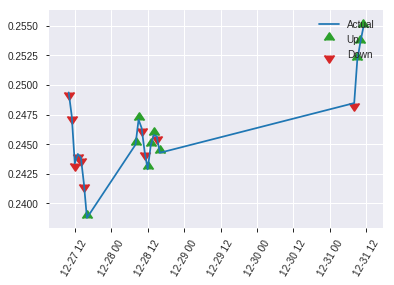


ModelMetricsBinomial: xgboost
** Reported on test data. **

MSE: 0.20693193406487911
RMSE: 0.4548977182454086
LogLoss: 0.6014474496827809
Mean Per-Class Error: 0.2679379444085326
AUC: 0.7730284421460892
pr_auc: 0.7484727209639669
Gini: 0.5460568842921785
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.3807811737060547: 


0    1    Error    Rate
-----  ---  ---  -------  ------------
0      82   37   0.3109   (37.0/119.0)
1      25   79   0.2404   (25.0/104.0)
Total  107  116  0.278    (62.0/223.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.380781     0.718182  115
max f2                       0.188765     0.834697  194
max f0point5                 0.443595     0.742925  79
max accuracy                 0.443595     0.73991   79
max precision                0.798953     1         0
max recall                   0.135278     1         207
max specificity              0.798953     1         0
max absolute_mcc             0.443595     0.481477  79
max min_per_class_accuracy   0.392371     0.705882  108
max mean_per_class_accuracy  0.437291     0.732062  81

Gains/Lift Table: Avg response rate: 46.64 %, avg score: 37.91 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0134529                   0.730952           2.14423   2.14423            1                0.767124  1                           0.767124            0.0288462       0.0288462                  114.423   114.423
    2        0.0224215                   0.719163           1.07212   1.71538            0.5              0.721202  0.8                         0.748755            0.00961538      0.0384615                  7.21154   71.5385
    3        0.0313901                   0.712427           2.14423   1.83791            1                0.717138  0.857143                    0.739722            0.0192308       0.0576923                  114.423   83.7912
    4        0.0403587                   0.677736           2.14423   1.90598            1                0.706822  0.888889                    0.732411            0.0192308       0.0769231                  114.423   90.5983
    5        0.0538117                   0.669287           2.14423   1.96554            1                0.671816  0.916667                    0.717262            0.0288462       0.105769                   114.423   96.5545
    6        0.103139                    0.600961           1.75437   1.86455            0.818182         0.628317  0.869565                    0.674723            0.0865385       0.192308                   75.4371   86.4548
    7        0.152466                    0.564513           1.9493    1.89197            0.909091         0.582986  0.882353                    0.645043            0.0961538       0.288462                   94.9301   89.1968
    8        0.201794                    0.51154            2.14423   1.95363            1                0.53329   0.911111                    0.617726            0.105769        0.394231                   114.423   95.3632
    9        0.300448                    0.464108           1.16958   1.69618            0.545455         0.482975  0.791045                    0.573479            0.115385        0.509615                   16.958    69.6183
    10       0.399103                    0.423896           1.16958   1.56601            0.545455         0.445741  0.730337                    0.541904            0.115385        0.625                      16.958    56.6011
    11       0.502242                    0.386551           0.932274  1.43587            0.434783         0.402164  0.669643                    0.513207            0.0961538       0.721154                   -6.77258  43.5869
    12       0.600897                    0.335106           0.682255  1.31214            0.318182         0.363974  0.61194                     0.488706            0.0673077       0.788462                   -31.7745  31.2141
    13       0.699552                    0.27063            0.38986   1.18208            0.181818         0.300676  0.551282                    0.462189            0.0384615       0.826923                   -61.014   18.2076
    14       0.798206                    0.208387           0.877185  1.14439            0.409091         0.237599  0.533708                    0.434431            0.0865385       0.913462                   -12.2815  14.4393
    15       0.896861                    0.169089           0.682255  1.09356            0.318182         0.19281   0.51                        0.407852            0.0673077       0.980769                   -31.7745  9.35577
    16       1                           0.0832254          0.186455  1                  0.0869565        0.129097  0.466368                    0.379102         

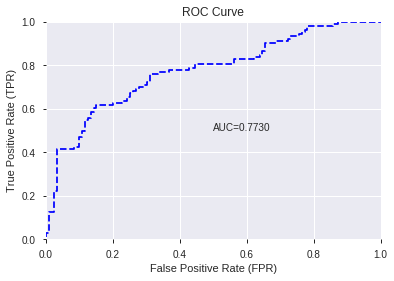

This function is available for GLM models only


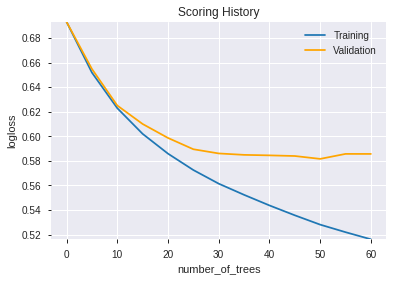

--2019-08-27 21:16:46--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.200.251
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.200.251|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
log4j:WARN No appenders could be found for logger (ml.dmlc.xgboost4j.java.Booster).
log4j:WARN Please initialize the log4j system properly.
log4j:WARN See http://logging.apache.org/log4j/1.2/faq.html#noconfig for more info.
Exception in thread "main" java.lang.StackOverflowError
	at java.base/java.lang.String.substring(String.java:1874)
	at java.base/java.lang.String.split(String.java:2289)
	at java.base/java.lang.String.split(String.java:2364)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:101)
	at he

[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/XGBoost_grid_1_AutoML_20190827_211541_model_4',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'XGBoost_grid_1_AutoML_20190827_211541_model_4',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_42_sid_82c1',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training

In [18]:
# XGBoost
xgb_features = model_train(feature_name='All',model_algo="XGBoost")

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  DeepLearning_grid_1_AutoML_20190827_211654_model_6  0.757272  0.614423              0.364981  0.454010  0.206125
1  DeepLearning_grid_1_AutoML_20190827_211654_model_9  0.751697  0.601231              0.359001  0.453528  0.205687
2  DeepLearning_grid_1_AutoML_20190827_211654_model_8  0.746930  0.603344              0.350598  0.457022  0.208869
3  DeepLearning_grid_1_AutoML_20190827_211654_model_4  0.744425  0.787902              0.326034  0.490824  0.240908
4  DeepLearning_grid_1_AutoML_20190827_211654_model_3  0.742889  0.777025              0.362597  0.478570  0.229029
5  DeepLearning_grid_1_AutoML_20190827_211654_model_2  0.739173  0.807214              0.358355  0.493358  0.243402
6  DeepLearning_grid_1_AutoML_20190827_211654_model_7  0.738122  0.810445              0.374596  0.509577  0.259669
7  DeepLearning_grid_1_AutoML_20190827_211654_model_5  0.734082  0.636960              0.363163  0.468559  0.219548
8               DeepLearning_1_AutoML_20190827_211654  0.729719  0.604397              0.350032  0.457381  0.209198
9  DeepLearning_grid_1_AutoML_20190827_211654_model_1  0.715175  1.080942              0.373384  0.525074  0.275703

variable  relative_importance  scaled_importance  percentage
0     CDLCLOSINGMARUBOZU             1.000000           1.000000    0.037498
1                    BOP             0.987438           0.987438    0.037027
2            CDLLONGLINE             0.855534           0.855534    0.032081
3                 TRANGE             0.700168           0.700168    0.026255
4                    DIV             0.684412           0.684412    0.025664
5          days_in_month             0.673701           0.673701    0.025263
6                    SUB             0.665599           0.665599    0.024959
7      CDLLONGLEGGEDDOJI             0.597694           0.597694    0.022413
8           CDLSHORTLINE             0.595370           0.595370    0.022325
9           CDLENGULFING             0.590679           0.590679    0.022149
10          HT_TRENDMODE             0.587188           0.587188    0.022019
11                  hour             0.579056           0.579056    0.021714
12             CDLHAMMER             0.575878           0.575878    0.021594
13               CDLDOJI             0.571578           0.571578    0.021433
14   CDLGAPSIDESIDEWHITE             0.558487           0.558487    0.020942
15            aroonup_14             0.551474           0.551474    0.020679
16  HT_PHASOR_quadrature             0.550177           0.550177    0.020631
17          weekday_name             0.539942           0.539942    0.020247
18    CDLMORNINGDOJISTAR             0.533461           0.533461    0.020004
19                ULTOSC             0.530456           0.530456    0.019891
20         CDLHANGINGMAN             0.525865           0.525865    0.019719
21             CORREL_14             0.525776           0.525776    0.019716
22              CORREL_8             0.521411           0.521411    0.019552
23          STOCHF_fastk             0.516550           0.516550    0.019370
24     CDL3WHITESOLDIERS             0.508613           0.508613    0.019072
25                SAREXT             0.503384           0.503384    0.018876
26               ADXR_14             0.496573           0.496573    0.018621
27        STOCHRSI_fastk             0.495853           0.495853    0.018594
28                 ADOSC             0.489169           0.489169    0.018343
29             aroonup_8             0.477228           0.477228    0.017895
30        STOCHRSI_fastd             0.467358           0.467358    0.017525
31               BETA_30             0.461219           0.461219    0.017295
32                Volume             0.459188           0.459188    0.017219
33                BETA_8             0.458827           0.458827    0.017205
34             dayofweek             0.455424           0.455424    0.017078
35            PLUS_DM_12             0.455322           0.455322    0.017074
36           STOCH_slowd             0.451961           0.451961    0.016948
37          aroondown_20             0.440368           0.440368    0.016513
38             PLUS_DI_8             0.440311           0.440311    0.016511
39             CORREL_12             0.439086           0.439086    0.016465
40               weekday             0.434837           0.434837    0.016306
41          aroondown_12             0.432249           0.432249    0.016209
42                  DX_8             0.431042           0.431042    0.016163
43            PLUS_DI_12             0.424859           0.424859    0.015931
44          STOCHF_fastd             0.412910           0.412910    0.015483
45               WILLR_8             0.412075           0.412075    0.015452
46           aroondown_8             0.405256           0.405256    0.015196
47              WILLR_12             0.405227           0.405227    0.015195
48              WILLR_14             0.402504           0.402504    0.015093
49        CDLSPINNINGTOP             0.389149           0.389149    0.014592

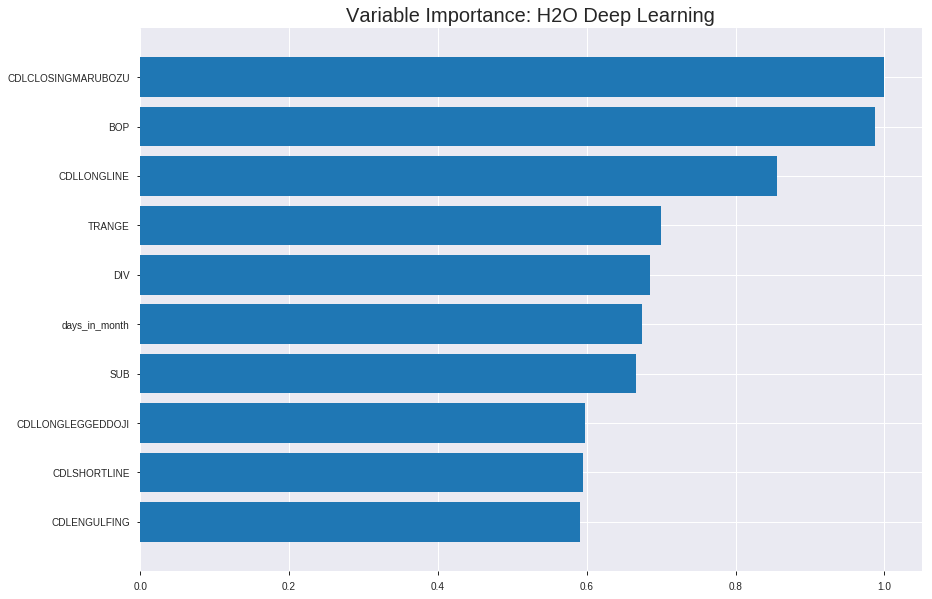

Model Details
H2ODeepLearningEstimator :  Deep Learning
Model Key:  DeepLearning_grid_1_AutoML_20190827_211654_model_6


ModelMetricsBinomial: deeplearning
** Reported on train data. **

MSE: 0.16100648184648175
RMSE: 0.40125612997994403
LogLoss: 0.4859897561329467
Mean Per-Class Error: 0.23227816550348956
AUC: 0.846714024592888
pr_auc: 0.817532686517322
Gini: 0.693428049185776
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.3819183013139929: 


0    1    Error    Rate
-----  ---  ---  -------  --------------
0      576  274  0.3224   (274.0/850.0)
1      106  602  0.1497   (106.0/708.0)
Total  682  876  0.2439   (380.0/1558.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.381918     0.760101  236
max f2                       0.14819      0.848411  335
max f0point5                 0.540233     0.756489  160
max accuracy                 0.423056     0.763158  217
max precision                0.974129     1         0
max recall                   0.0712892    1         370
max specificity              0.974129     1         0
max absolute_mcc             0.414019     0.533919  221
max min_per_class_accuracy   0.452457     0.757647  203
max mean_per_class_accuracy  0.414019     0.767722  221

Gains/Lift Table: Avg response rate: 45.44 %, avg score: 43.65 %



group    cumulative_data_fraction    lower_threshold    lift       cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  ---------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0102696                   0.932289           2.20056    2.20056            1                0.951075   1                           0.951075            0.0225989       0.0225989                  120.056   120.056
    2        0.0205392                   0.918939           2.06303    2.1318             0.9375           0.924875   0.96875                     0.937975            0.0211864       0.0437853                  106.303   113.18
    3        0.0301669                   0.902165           2.20056    2.15374            1                0.910588   0.978723                    0.929234            0.0211864       0.0649718                  120.056   115.374
    4        0.0404365                   0.893477           1.92549    2.09578            0.875            0.897557   0.952381                    0.921189            0.019774        0.0847458                  92.5494   109.578
    5        0.0500642                   0.878348           2.20056    2.11593            1                0.88595    0.961538                    0.914413            0.0211864       0.105932                   120.056   111.593
    6        0.100128                    0.816324           1.97487    2.0454             0.897436         0.850845   0.929487                    0.882629            0.0988701       0.204802                   97.4866   104.54
    7        0.150193                    0.751932           1.89023    1.99367            0.858974         0.781572   0.905983                    0.848943            0.0946328       0.299435                   89.0229   99.3674
    8        0.200257                    0.68847            1.8338     1.95371            0.833333         0.71792    0.887821                    0.816187            0.0918079       0.391243                   83.3804   95.3707
    9        0.300385                    0.601217           1.53757    1.815              0.698718         0.643423   0.824786                    0.758599            0.153955        0.545198                   53.7574   81.4996
    10       0.399872                    0.502852           1.30614    1.68839            0.593548         0.550218   0.767255                    0.706755            0.129944        0.675141                   30.6142   68.8395
    11       0.5                         0.432904           1.11439    1.57345            0.50641          0.469233   0.715019                    0.659189            0.111582        0.786723                   11.4389   57.3446
    12       0.600128                    0.353747           0.832265   1.44978            0.378205         0.39209    0.658824                    0.614625            0.0833333       0.870056                   -16.7735  44.9784
    13       0.699615                    0.26234            0.638874   1.33447            0.290323         0.30844    0.606422                    0.571085            0.0635593       0.933616                   -36.1126  33.4471
    14       0.799743                    0.154127           0.423186   1.22038            0.192308         0.2142     0.554575                    0.526403            0.0423729       0.975989                   -57.6814  22.0378
    15       0.899872                    0.0755726          0.197487   1.10656            0.0897436        0.11068    0.502853                    0.480145            0.019774        0.995763                   -80.2513  10.6561
    16       1                           0.00117698         0.0423186  1                  0.0192308        0.0439678  0.454429   



ModelMetricsBinomial: deeplearning
** Reported on validation data. **

MSE: 0.2017654658601995
RMSE: 0.449183109500123
LogLoss: 0.5932675568138613
Mean Per-Class Error: 0.2782528334078076
AUC: 0.7690924970548808
pr_auc: 0.6872074722934551
Gini: 0.5381849941097616
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.24838778605007006: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      130  109  0.4561   (109.0/239.0)
1      22   184  0.1068   (22.0/206.0)
Total  152  293  0.2944   (131.0/445.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.248388     0.737475  267
max f2                       0.125598     0.841924  310
max f0point5                 0.493773     0.688235  148
max accuracy                 0.373265     0.710112  217
max precision                0.964755     1         0
max recall                   0.0249066    1         391
max specificity              0.964755     1         0
max absolute_mcc             0.280693     0.460827  260
max min_per_class_accuracy   0.404364     0.694561  199
max mean_per_class_accuracy  0.280693     0.721747  260

Gains/Lift Table: Avg response rate: 46.29 %, avg score: 39.43 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.011236                    0.916936           1.29612   1.29612            0.6              0.943862   0.6                         0.943862            0.0145631       0.0145631                  29.6117   29.6117
    2        0.0202247                   0.887526           2.16019   1.68015            1                0.897451   0.777778                    0.923235            0.0194175       0.0339806                  116.019   68.0151
    3        0.0314607                   0.870585           1.29612   1.543              0.6              0.877141   0.714286                    0.906773            0.0145631       0.0485437                  29.6117   54.2996
    4        0.0404494                   0.865359           2.16019   1.68015            1                0.868037   0.777778                    0.898165            0.0194175       0.0679612                  116.019   68.0151
    5        0.0516854                   0.840565           1.29612   1.59667            0.6              0.854314   0.73913                     0.888632            0.0145631       0.0825243                  29.6117   59.6665
    6        0.101124                    0.751312           1.47286   1.53614            0.681818         0.795913   0.711111                    0.843303            0.0728155       0.15534                    47.286    53.6138
    7        0.150562                    0.693392           1.76743   1.61209            0.818182         0.719404   0.746269                    0.80262             0.0873786       0.242718                   76.7432   61.2085
    8        0.2                         0.650587           1.66924   1.62621            0.772727         0.675991   0.752809                    0.771318            0.0825243       0.325243                   66.9241   62.6214
    9        0.301124                    0.533482           1.44013   1.56372            0.666667         0.590882   0.723881                    0.710724            0.145631        0.470874                   44.0129   56.3723
    10       0.4                         0.474927           1.27648   1.49272            0.590909         0.501792   0.691011                    0.659078            0.126214        0.597087                   27.6478   49.2718
    11       0.501124                    0.396416           1.1041    1.4143             0.511111         0.434124   0.654709                    0.613684            0.11165         0.708738                   10.4099   41.4298
    12       0.6                         0.313194           1.22738   1.3835             0.568182         0.359301   0.640449                    0.571763            0.121359        0.830097                   22.7383   38.3495
    13       0.698876                    0.195732           0.83462   1.30584            0.386364         0.258703   0.604502                    0.527471            0.0825243       0.912621                   -16.538   30.5841
    14       0.8                         0.0997635          0.432039  1.19539            0.2              0.144203   0.553371                    0.479024            0.0436893       0.956311                   -56.7961  19.5388
    15       0.898876                    0.0522942          0.196381  1.0855             0.0909091        0.0779344  0.5025                      0.434905            0.0194175       0.975728                   -80.3619  8.54976
    16       1                           0.00799334         0.240022  1                  0.111111         0.0332537  0.462921                   


Scoring History: 


timestamp            duration          training_speed    epochs    iterations    samples    training_rmse    training_logloss    training_r2    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_r2    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------------  ----------------  --------  ------------  ---------  ---------------  ------------------  -------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ---------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-08-27 21:20:53  0.000 sec                           0         0             0          nan              nan                 nan            nan             nan                nan              nan                              nan                nan                   nan              nan               nan                  nan                nan
    2019-08-27 21:20:54  1 min 54.787 sec  833 obs/sec       1         1             1558       0.495434         0.849018            0.00995442     0.766658        0.693963           1.92549          0.320282                         0.483459           0.803356              0.0598981        0.758094          0.710317             2.16019            0.334831
    2019-08-27 21:21:00  2 min  0.223 sec  1376 obs/sec      6         6             9348       0.433885         0.551218            0.240668       0.784           0.737179           2.06303          0.311297                         0.449398           0.601541              0.187699         0.770697          0.707861             2.16019            0.294382
    2019-08-27 21:21:06  2 min  5.815 sec  1965 obs/sec      15        15            23370      0.424756         0.531212            0.272285       0.80874         0.770311           2.20056          0.285623                         0.463241           0.63308               0.136884         0.75981           0.682513             1.29612            0.296629
    2019-08-27 21:21:11  2 min 10.986 sec  2258 obs/sec      24        24            37392      0.413262         0.508871            0.311137       0.828116        0.794535           2.20056          0.249679                         0.453485           0.605155              0.172856         0.761202          0.678177             1.72816            0.28764
    2019-08-27 21:21:16  2 min 16.501 sec  2460 obs/sec      34        34            52972      0.401256         0.48599             0.350579       0.846714        0.817533           2.20056          0.243902                         0.449183           0.593268              0.188475         0.769092          0.687207             1.29612            0.294382
    2019-08-27 21:21:22  2 min 22.398 sec  2603 obs/sec      45        45            70110      0.390163         0.461458            0.385992       0.864276        0.840522           2.20056          0.223363                         0.455316           0.622636              0.166165         0.758074          0.665789             1.72816            0.310112
    2019-08-27 21:21:27  2 min 27.717 sec  2699 obs/sec      55        55            85690      0.381206         0.443257            0.413858       0.874842        0.852891           2.20056          0.209884                         0.458764           0.645153              0.153486         0.761191          0.681372             2.16019            0.332584
    2019-08-27 21:21:29  2 min 29.059 sec  2633 obs/sec      55        55            85690      0.401256         0.48599             0.350579       0.846714        0.817533           2.20056          0.243902                         0.449183           0.593268              0.188475         0.769092          0.687207             1.29612            0.294382

Variable Importances: 


variable            relative_importance    scaled_importance    percentage
------------------  ---------------------  -------------------  --------------------
CDLCLOSINGMARUBOZU  1.0                    1.0                  0.03749829001606287
BOP                 0.9874384999275208     0.9874384999275208   0.03702725524330825
CDLLONGLINE         0.8555335998535156     0.8555335998535156   0.03208104704579341
TRANGE              0.7001683115959167     0.7001683115959167   0.026255114408280763
DIV                 0.6844115853309631     0.6844115853309631   0.025664264117093816
---                 ---                    ---                  ---
WILLR_8             0.4120751619338989     0.4120751619338989   0.015452113930613413
aroondown_8         0.4052555561065674     0.4052555561065674   0.015196390373504903
WILLR_12            0.40522685647010803    0.40522685647010803  0.015195314186213595
WILLR_14            0.4025042653083801     0.4025042653083801   0.015093221673235952
CDLSPINNINGTOP      0.38914942741394043    0.38914942741394043  0.014592438088752746


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.7174887892376681)

('F1', 0.6950354609929078)

('auc', 0.7572721396250808)

('logloss', 0.6144229595627752)

('mean_per_class_error', 0.29379444085326445)

('rmse', 0.4540097431451508)

('mse', 0.20612484687072583)

deeplearning prediction progress: |███████████████████████████████████████| 100%


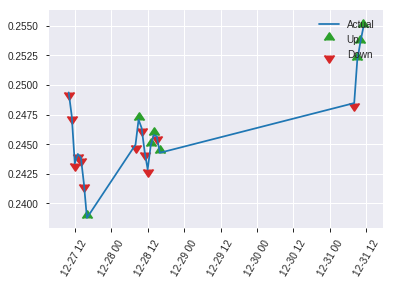


ModelMetricsBinomial: deeplearning
** Reported on test data. **

MSE: 0.20612484687072583
RMSE: 0.4540097431451508
LogLoss: 0.6144229595627752
Mean Per-Class Error: 0.29379444085326445
AUC: 0.7572721396250808
pr_auc: 0.758156101611656
Gini: 0.5145442792501616
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.11174709002246676: 


0    1    Error    Rate
-----  ---  ---  -------  ------------
0      39   80   0.6723   (80.0/119.0)
1      6    98   0.0577   (6.0/104.0)
Total  45   178  0.3857   (86.0/223.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.111747     0.695035  177
max f2                       0.0340937    0.828025  211
max f0point5                 0.504084     0.723684  68
max accuracy                 0.504084     0.717489  68
max precision                0.964095     1         0
max recall                   0.0340937    1         211
max specificity              0.964095     1         0
max absolute_mcc             0.504084     0.443769  68
max min_per_class_accuracy   0.42225      0.663462  103
max mean_per_class_accuracy  0.499758     0.706206  70

Gains/Lift Table: Avg response rate: 46.64 %, avg score: 38.38 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0134529                   0.900864           2.14423   2.14423            1                0.926574   1                           0.926574            0.0288462       0.0288462                  114.423   114.423
    2        0.0224215                   0.885431           2.14423   2.14423            1                0.896478   1                           0.914536            0.0192308       0.0480769                  114.423   114.423
    3        0.0313901                   0.857921           2.14423   2.14423            1                0.873165   1                           0.902716            0.0192308       0.0673077                  114.423   114.423
    4        0.0403587                   0.84448            2.14423   2.14423            1                0.848492   1                           0.890666            0.0192308       0.0865385                  114.423   114.423
    5        0.0538117                   0.833852           1.42949   1.96554            0.666667         0.838575   0.916667                    0.877643            0.0192308       0.105769                   42.9487   96.5545
    6        0.103139                    0.753319           2.14423   2.051              1                0.78752    0.956522                    0.834541            0.105769        0.211538                   114.423   105.1
    7        0.152466                    0.681792           1.75437   1.95503            0.818182         0.721873   0.911765                    0.798089            0.0865385       0.298077                   75.4371   95.5034
    8        0.201794                    0.601777           1.55944   1.85833            0.727273         0.651426   0.866667                    0.762238            0.0769231       0.375                      55.9441   85.8333
    9        0.300448                    0.506636           1.36451   1.69618            0.636364         0.547931   0.791045                    0.691869            0.134615        0.509615                   36.451    69.6183
    10       0.399103                    0.452013           0.97465   1.51783            0.454545         0.482219   0.707865                    0.640045            0.0961538       0.605769                   -2.53497  51.7826
    11       0.502242                    0.40211            0.652592  1.34014            0.304348         0.425646   0.625                       0.596017            0.0673077       0.673077                   -34.7408  34.0144
    12       0.600897                    0.308678           0.877185  1.26414            0.409091         0.348933   0.589552                    0.555451            0.0865385       0.759615                   -12.2815  26.4136
    13       0.699552                    0.190182           0.682255  1.18208            0.318182         0.253905   0.551282                    0.512925            0.0673077       0.826923                   -31.7745  18.2076
    14       0.798206                    0.111509           1.16958   1.18053            0.545455         0.142957   0.550562                    0.467199            0.115385        0.942308                   16.958    18.0532
    15       0.896861                    0.0534426          0.19493   1.07212            0.0909091        0.0784276  0.5                         0.424434            0.0192308       0.961538                   -80.507   7.21154
    16       1                           0.00251097         0.37291   1                  0.173913         0.0302575  0.466368                    0

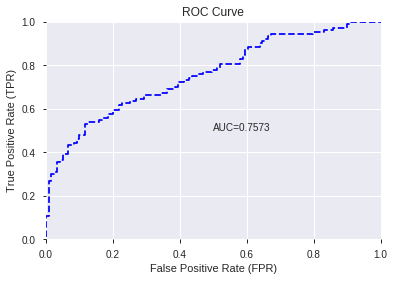

This function is available for GLM models only


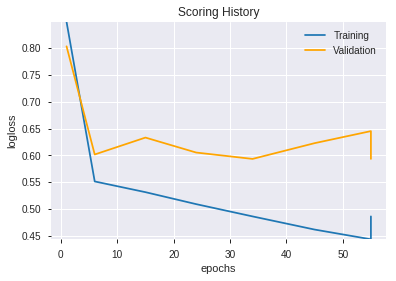

--2019-08-27 21:24:40--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.113.27
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.113.27|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/DeepLearning_grid_1_AutoML_20190827_211654_model_6',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'DeepLearning_grid_1_AutoML_20190827_211654_model_6',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_50_sid_82c1',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'autom

['CDLCLOSINGMARUBOZU',
 'BOP',
 'CDLLONGLINE',
 'TRANGE',
 'DIV',
 'days_in_month',
 'SUB',
 'CDLLONGLEGGEDDOJI',
 'CDLSHORTLINE',
 'CDLENGULFING',
 'HT_TRENDMODE',
 'hour',
 'CDLHAMMER',
 'CDLDOJI',
 'CDLGAPSIDESIDEWHITE',
 'aroonup_14',
 'HT_PHASOR_quadrature',
 'weekday_name',
 'CDLMORNINGDOJISTAR',
 'ULTOSC',
 'CDLHANGINGMAN',
 'CORREL_14',
 'CORREL_8',
 'STOCHF_fastk',
 'CDL3WHITESOLDIERS',
 'SAREXT',
 'ADXR_14',
 'STOCHRSI_fastk',
 'ADOSC',
 'aroonup_8',
 'STOCHRSI_fastd',
 'BETA_30',
 'Volume',
 'BETA_8',
 'dayofweek',
 'PLUS_DM_12',
 'STOCH_slowd',
 'aroondown_20',
 'PLUS_DI_8',
 'CORREL_12',
 'weekday',
 'aroondown_12',
 'DX_8',
 'PLUS_DI_12',
 'STOCHF_fastd',
 'WILLR_8',
 'aroondown_8',
 'WILLR_12',
 'WILLR_14',
 'CDLSPINNINGTOP']

In [19]:
# DeepLearning with top XGBoost features
model_train(feature_name='XGBF',model_algo="DeepLearning",features_list = features_list[:model_selected_features])

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  GLM_grid_1_AutoML_20190827_212449_model_1  0.751454  0.597226              0.367405  0.453811  0.205944

variable  relative_importance  scaled_importance  percentage
0                    BOP             0.307835           1.000000    0.091165
1     CDLCLOSINGMARUBOZU             0.208818           0.678342    0.061841
2                    SUB             0.138473           0.449828    0.041009
3              CDLHAMMER             0.137692           0.447290    0.040777
4                    DIV             0.137297           0.446008    0.040660
5           STOCHF_fastk             0.126337           0.410405    0.037415
6            CDLLONGLINE             0.125978           0.409239    0.037308
7                 ULTOSC             0.125344           0.407179    0.037121
8                   hour             0.120211           0.390506    0.035601
9           CDLENGULFING             0.112937           0.366875    0.033446
10         CDLHANGINGMAN             0.097408           0.316429    0.028847
11                 ADOSC             0.088744           0.288285    0.026282
12           STOCH_slowd             0.083758           0.272087    0.024805
13                SAREXT             0.082808           0.269001    0.024524
14            aroonup_14             0.081651           0.265242    0.024181
15              WILLR_14             0.078593           0.255307    0.023275
16                TRANGE             0.075355           0.244789    0.022316
17             PLUS_DI_8             0.070126           0.227803    0.020768
18   CDLGAPSIDESIDEWHITE             0.069729           0.226515    0.020650
19                Volume             0.068505           0.222537    0.020288
20          CDLSHORTLINE             0.063519           0.206341    0.018811
21        STOCHRSI_fastk             0.055941           0.181722    0.016567
22          aroondown_20             0.053667           0.174336    0.015893
23              WILLR_12             0.053224           0.172899    0.015762
24                BETA_8             0.050236           0.163190    0.014877
25               CDLDOJI             0.047183           0.153274    0.013973
26     CDLLONGLEGGEDDOJI             0.047151           0.153170    0.013964
27  HT_PHASOR_quadrature             0.043021           0.139752    0.012741
28               WILLR_8             0.040743           0.132353    0.012066
29          HT_TRENDMODE             0.040125           0.130346    0.011883
30            PLUS_DM_12             0.039663           0.128844    0.011746
31           aroondown_8             0.039606           0.128661    0.011729
32             CORREL_12             0.036712           0.119257    0.010872
33             aroonup_8             0.036029           0.117040    0.010670
34             dayofweek             0.036023           0.117019    0.010668
35               weekday             0.035985           0.116898    0.010657
36            PLUS_DI_12             0.035838           0.116419    0.010613
37              CORREL_8             0.028644           0.093050    0.008483
38               BETA_30             0.028618           0.092966    0.008475
39        STOCHRSI_fastd             0.028612           0.092945    0.008473
40    CDLMORNINGDOJISTAR             0.028050           0.091121    0.008307
41     CDL3WHITESOLDIERS             0.027430           0.089107    0.008123
42          STOCHF_fastd             0.025163           0.081742    0.007452
43                  DX_8             0.023440           0.076144    0.006942
44         days_in_month             0.021575           0.070085    0.006389
45        CDLSPINNINGTOP             0.020413           0.066312    0.006045
46          aroondown_12             0.020254           0.065794    0.005998
47               ADXR_14             0.014580           0.047361    0.004318
48          weekday_name             0.011778           0.038262    0.003488
49             CORREL_14             0.005853           0.019012    0.001733

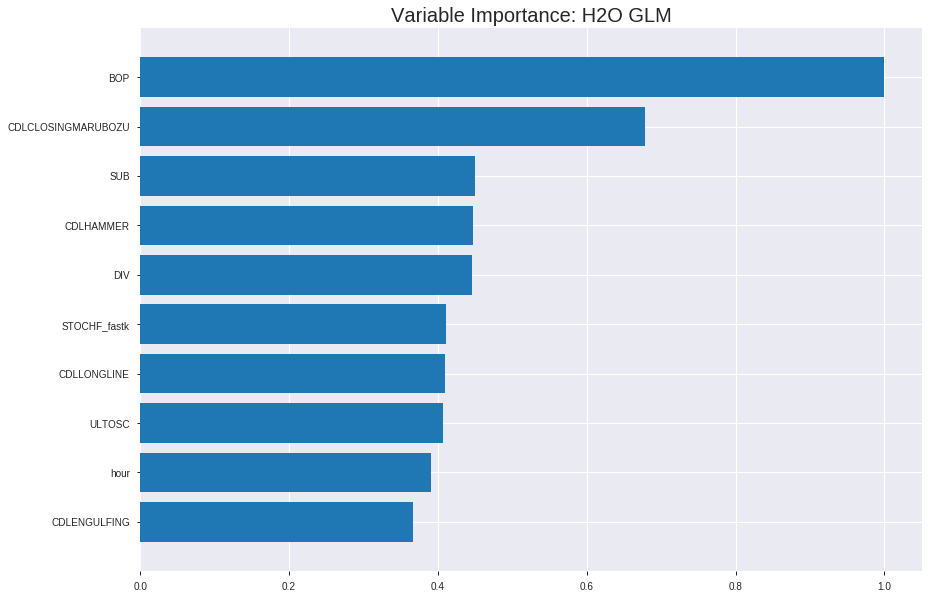

Model Details
H2OGeneralizedLinearEstimator :  Generalized Linear Modeling
Model Key:  GLM_grid_1_AutoML_20190827_212449_model_1


ModelMetricsBinomialGLM: glm
** Reported on train data. **

MSE: 0.1916227404067991
RMSE: 0.4377473476867668
LogLoss: 0.5643907614552544
Null degrees of freedom: 1557
Residual degrees of freedom: 1507
Null deviance: 2146.8864027643094
Residual deviance: 1758.6416126945728
AIC: 1860.6416126945728
AUC: 0.7804710867397806
pr_auc: 0.7361537005601774
Gini: 0.5609421734795612
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.37147396365512286: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      445  405   0.4765   (405.0/850.0)
1      97   611   0.137    (97.0/708.0)
Total  542  1016  0.3222   (502.0/1558.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.371474     0.708817  253
max f2                       0.236353     0.829315  324
max f0point5                 0.47678      0.685853  189
max accuracy                 0.466493     0.715019  195
max precision                0.949634     1         0
max recall                   0.052133     1         394
max specificity              0.949634     1         0
max absolute_mcc             0.462353     0.42676   197
max min_per_class_accuracy   0.454419     0.711765  201
max mean_per_class_accuracy  0.447558     0.714171  205

Gains/Lift Table: Avg response rate: 45.44 %, avg score: 45.44 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0102696                   0.875958           2.06303   2.06303            0.9375           0.898645  0.9375                      0.898645            0.0211864       0.0211864                  106.303   106.303
    2        0.0205392                   0.840919           1.65042   1.85673            0.75             0.859902  0.84375                     0.879273            0.0169492       0.0381356                  65.0424   85.6727
    3        0.0301669                   0.814329           2.05386   1.91964            0.933333         0.826017  0.87234                     0.862277            0.019774        0.0579096                  105.386   91.9642
    4        0.0404365                   0.794716           2.20056   1.99099            1                0.805824  0.904762                    0.84794             0.0225989       0.0805085                  120.056   99.0987
    5        0.0500642                   0.784307           2.20056   2.03129            1                0.790522  0.923077                    0.836898            0.0211864       0.101695                   120.056   103.129
    6        0.100128                    0.72552            1.80559   1.91844            0.820513         0.752508  0.871795                    0.794703            0.0903955       0.19209                    80.5592   91.8441
    7        0.150193                    0.679174           1.63632   1.8244             0.74359          0.7016    0.82906                     0.763669            0.0819209       0.274011                   63.6318   82.44
    8        0.200257                    0.641583           1.60811   1.77033            0.730769         0.657338  0.804487                    0.737086            0.0805085       0.35452                    60.8105   77.0326
    9        0.300385                    0.573278           1.38241   1.64102            0.628205         0.606568  0.745726                    0.69358             0.138418        0.492938                   38.2406   64.102
    10       0.399872                    0.507734           1.14997   1.51885            0.522581         0.538929  0.690209                    0.655104            0.114407        0.607345                   14.9973   51.8849
    11       0.5                         0.443789           1.24134   1.46328            0.564103         0.473358  0.664955                    0.618708            0.124294        0.731638                   24.1344   46.3277
    12       0.600128                    0.39926            0.818159  1.35564            0.371795         0.42073   0.616043                    0.585676            0.0819209       0.813559                   -18.1841  35.5642
    13       0.699615                    0.342901           0.780846  1.27391            0.354839         0.372114  0.578899                    0.555307            0.0776836       0.891243                   -21.9154  27.3905
    14       0.799743                    0.277603           0.550141  1.18329            0.25             0.312525  0.537721                    0.524911            0.0550847       0.946328                   -44.9859  18.3289
    15       0.899872                    0.177071           0.409079  1.09714            0.185897         0.227943  0.498573                    0.491867            0.0409605       0.987288                   -59.0921  9.71433
    16       1                           0.00324987         0.126956  1                  0.0576923        0.117964  0.454429                    0.454429            



ModelMetricsBinomialGLM: glm
** Reported on validation data. **

MSE: 0.20068522399360247
RMSE: 0.4479790441455967
LogLoss: 0.5837344415671307
Null degrees of freedom: 444
Residual degrees of freedom: 394
Null deviance: 614.5808798679772
Residual deviance: 519.5236529947464
AIC: 621.5236529947464
AUC: 0.7737234431490433
pr_auc: 0.7026060116967295
Gini: 0.5474468862980866
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.283643143348436: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      124  115  0.4812   (115.0/239.0)
1      24   182  0.1165   (24.0/206.0)
Total  148  297  0.3124   (139.0/445.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.283643     0.723658  263
max f2                       0.156833     0.834718  339
max f0point5                 0.466742     0.711845  155
max accuracy                 0.466742     0.721348  155
max precision                0.855864     1         0
max recall                   0.0654749    1         376
max specificity              0.855864     1         0
max absolute_mcc             0.466742     0.43908   155
max min_per_class_accuracy   0.389796     0.707113  198
max mean_per_class_accuracy  0.347229     0.715715  224

Gains/Lift Table: Avg response rate: 46.29 %, avg score: 39.02 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.011236                    0.82614            2.16019   2.16019            1                0.838983   1                           0.838983            0.0242718       0.0242718                  116.019   116.019
    2        0.0202247                   0.784387           2.16019   2.16019            1                0.809625   1                           0.825935            0.0194175       0.0436893                  116.019   116.019
    3        0.0314607                   0.752392           0.864078  1.6973             0.4              0.766057   0.785714                    0.80455             0.00970874      0.0533981                  -13.5922  69.7295
    4        0.0404494                   0.735552           1.0801    1.56014            0.5              0.745392   0.722222                    0.791404            0.00970874      0.0631068                  8.00971   56.014
    5        0.0516854                   0.716281           1.72816   1.59667            0.8              0.727889   0.73913                     0.777596            0.0194175       0.0825243                  72.8155   59.6665
    6        0.101124                    0.678798           1.27648   1.44013            0.590909         0.692125   0.666667                    0.73581             0.0631068       0.145631                   27.6478   44.0129
    7        0.150562                    0.626515           1.86562   1.57984            0.863636         0.651157   0.731343                    0.708014            0.092233        0.237864                   86.5622   57.9844
    8        0.2                         0.577314           1.76743   1.62621            0.818182         0.605452   0.752809                    0.682662            0.0873786       0.325243                   76.7432   62.6214
    9        0.301124                    0.515013           1.68015   1.64433            0.777778         0.542032   0.761194                    0.635435            0.169903        0.495146                   68.0151   64.4327
    10       0.4                         0.446373           1.27648   1.5534             0.590909         0.482177   0.719101                    0.597551            0.126214        0.621359                   27.6478   55.3398
    11       0.501124                    0.382179           1.05609   1.45305            0.488889         0.412363   0.672646                    0.560181            0.106796        0.728155                   5.60949   45.3045
    12       0.6                         0.321865           0.883716  1.35922            0.409091         0.351236   0.629213                    0.525748            0.0873786       0.815534                   -11.6284  35.9223
    13       0.698876                    0.26874            0.785525  1.27806            0.363636         0.293999   0.59164                     0.492961            0.0776699       0.893204                   -21.4475  27.8057
    14       0.8                         0.196574           0.576052  1.18932            0.266667         0.236851   0.550562                    0.460587            0.0582524       0.951456                   -42.3948  18.932
    15       0.898876                    0.101192           0.245477  1.0855             0.113636         0.155499   0.5025                      0.427028            0.0242718       0.975728                   -75.4523  8.54976
    16       1                           0.00423836         0.240022  1                  0.111111         0.0632338  0.462921                    0


Scoring History: 


timestamp            duration    iteration    lambda    predictors    deviance_train    deviance_test
--  -------------------  ----------  -----------  --------  ------------  ----------------  ---------------
    2019-08-27 21:24:50  0.000 sec   2            19        51            1.35782           1.35573
    2019-08-27 21:24:50  0.013 sec   4            12        51            1.3475            1.34312
    2019-08-27 21:24:50  0.026 sec   6            7.3       51            1.33311           1.32604
    2019-08-27 21:24:50  0.040 sec   8            4.6       51            1.31417           1.30444
    2019-08-27 21:24:50  0.054 sec   10           2.8       51            1.2907            1.27913
    2019-08-27 21:24:50  0.067 sec   12           1.8       51            1.26362           1.25199
    2019-08-27 21:24:50  0.079 sec   14           1.1       51            1.23466           1.2256
    2019-08-27 21:24:50  0.092 sec   16           0.68      51            1.20614           1.20265
    2019-08-27 21:24:50  0.104 sec   18           0.42      51            1.18027           1.18513
    2019-08-27 21:24:50  0.120 sec   20           0.26      51            1.15853           1.17385
    2019-08-27 21:24:50  0.134 sec   22           0.16      51            1.14147           1.16838
    2019-08-27 21:24:50  0.147 sec   24           0.1       51            1.12878           1.16747
    2019-08-27 21:24:50  0.161 sec   26           0.063     51            1.11964           1.16963
    2019-08-27 21:24:50  0.176 sec   28           0.039     51            1.11305           1.17359
    2019-08-27 21:24:50  0.189 sec   30           0.024     51            1.10813           1.17863
    2019-08-27 21:24:50  0.202 sec   32           0.015     51            1.10428           1.18432
    2019-08-27 21:24:50  0.214 sec   34           0.0093    51            1.10123           1.18984

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.7174887892376681)

('F1', 0.6861313868613139)

('auc', 0.7514544279250162)

('logloss', 0.597225514959851)

('mean_per_class_error', 0.29318842921784094)

('rmse', 0.4538110695363594)

('mse', 0.20594448683373442)

glm prediction progress: |████████████████████████████████████████████████| 100%


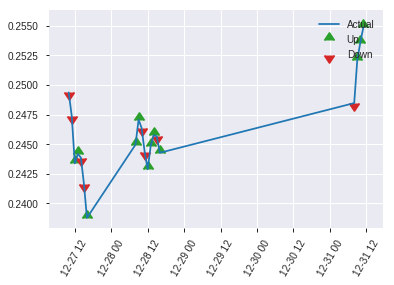


ModelMetricsBinomialGLM: glm
** Reported on test data. **

MSE: 0.20594448683373442
RMSE: 0.4538110695363594
LogLoss: 0.597225514959851
Null degrees of freedom: 222
Residual degrees of freedom: 172
Null deviance: 308.2619463225164
Residual deviance: 266.36257967209355
AIC: 368.36257967209355
AUC: 0.7514544279250162
pr_auc: 0.7371009149306508
Gini: 0.5029088558500323
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.23570185826213058: 


0    1    Error    Rate
-----  ---  ---  -------  ------------
0      43   76   0.6387   (76.0/119.0)
1      10   94   0.0962   (10.0/104.0)
Total  53   170  0.3857   (86.0/223.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.235702     0.686131  169
max f2                       0.132547     0.831987  202
max f0point5                 0.470047     0.719697  72
max accuracy                 0.470047     0.717489  72
max precision                0.865311     1         0
max recall                   0.085971     1         216
max specificity              0.865311     1         0
max absolute_mcc             0.470047     0.439732  72
max min_per_class_accuracy   0.408708     0.672269  108
max mean_per_class_accuracy  0.470047     0.706812  72

Gains/Lift Table: Avg response rate: 46.64 %, avg score: 39.69 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0134529                   0.797882           2.14423   2.14423            1                0.82493    1                           0.82493             0.0288462       0.0288462                  114.423   114.423
    2        0.0224215                   0.751279           2.14423   2.14423            1                0.766226   1                           0.801449            0.0192308       0.0480769                  114.423   114.423
    3        0.0313901                   0.744864           2.14423   2.14423            1                0.745954   1                           0.785593            0.0192308       0.0673077                  114.423   114.423
    4        0.0403587                   0.728471           2.14423   2.14423            1                0.738272   1                           0.775077            0.0192308       0.0865385                  114.423   114.423
    5        0.0538117                   0.719958           1.42949   1.96554            0.666667         0.723742   0.916667                    0.762244            0.0192308       0.105769                   42.9487   96.5545
    6        0.103139                    0.669931           1.9493    1.95778            0.909091         0.700117   0.913043                    0.732531            0.0961538       0.201923                   94.9301   95.7776
    7        0.152466                    0.623492           1.75437   1.89197            0.818182         0.648885   0.882353                    0.705469            0.0865385       0.288462                   75.4371   89.1968
    8        0.201794                    0.554757           1.36451   1.76303            0.636364         0.586201   0.822222                    0.676314            0.0673077       0.355769                   36.451    76.3034
    9        0.300448                    0.478358           1.46198   1.66418            0.681818         0.518601   0.776119                    0.624528            0.144231        0.5                        46.1976   66.4179
    10       0.399103                    0.435936           1.07212   1.51783            0.5              0.459106   0.707865                    0.583637            0.105769        0.605769                   7.21154   51.7826
    11       0.502242                    0.403679           0.652592  1.34014            0.304348         0.419326   0.625                       0.549895            0.0673077       0.673077                   -34.7408  34.0144
    12       0.600897                    0.350587           0.77972   1.24813            0.363636         0.377013   0.58209                     0.521511            0.0769231       0.75                       -22.028   24.8134
    13       0.699552                    0.291039           0.877185  1.19582            0.409091         0.319525   0.557692                    0.493026            0.0865385       0.836538                   -12.2815  19.5821
    14       0.798206                    0.214661           0.77972   1.14439            0.363636         0.248718   0.533708                    0.46283             0.0769231       0.913462                   -22.028   14.4393
    15       0.896861                    0.136072           0.682255  1.09356            0.318182         0.18353    0.51                        0.432107            0.0673077       0.980769                   -31.7745  9.35577
    16       1                           0.0268169          0.186455  1                  0.0869565        0.0911852  0.466368                   

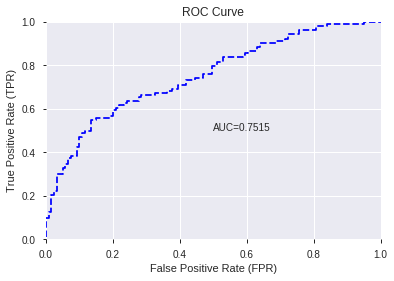

/usr/local/lib/python3.6/dist-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


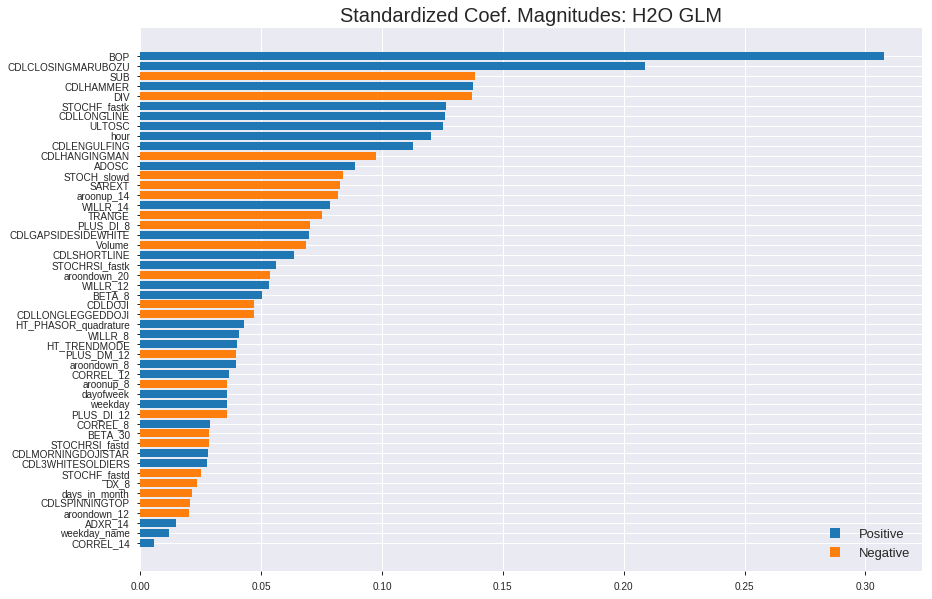

'log_likelihood'
--2019-08-27 21:24:56--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.1.96
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.1.96|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/GLM_grid_1_AutoML_20190827_212449_model_1',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'GLM_grid_1_AutoML_20190827_212449_model_1',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_58_sid_82c1',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training_py_58_s

['BOP',
 'CDLCLOSINGMARUBOZU',
 'SUB',
 'CDLHAMMER',
 'DIV',
 'STOCHF_fastk',
 'CDLLONGLINE',
 'ULTOSC',
 'hour',
 'CDLENGULFING',
 'CDLHANGINGMAN',
 'ADOSC',
 'STOCH_slowd',
 'SAREXT',
 'aroonup_14',
 'WILLR_14',
 'TRANGE',
 'PLUS_DI_8',
 'CDLGAPSIDESIDEWHITE',
 'Volume',
 'CDLSHORTLINE',
 'STOCHRSI_fastk',
 'aroondown_20',
 'WILLR_12',
 'BETA_8',
 'CDLDOJI',
 'CDLLONGLEGGEDDOJI',
 'HT_PHASOR_quadrature',
 'WILLR_8',
 'HT_TRENDMODE',
 'PLUS_DM_12',
 'aroondown_8',
 'CORREL_12',
 'aroonup_8',
 'dayofweek',
 'weekday',
 'PLUS_DI_12',
 'CORREL_8',
 'BETA_30',
 'STOCHRSI_fastd',
 'CDLMORNINGDOJISTAR',
 'CDL3WHITESOLDIERS',
 'STOCHF_fastd',
 'DX_8',
 'days_in_month',
 'CDLSPINNINGTOP',
 'aroondown_12',
 'ADXR_14',
 'weekday_name',
 'CORREL_14']

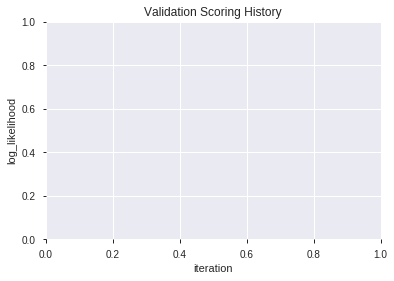

In [20]:
# GLM with top XGBoost features
model_train(feature_name='XGBF',model_algo="GLM",features_list = features_list[:model_selected_features])

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  XGBoost_grid_1_AutoML_20190827_212504_model_2  0.770362  0.595977              0.323610  0.452875  0.205096
1  XGBoost_grid_1_AutoML_20190827_212504_model_6  0.763090  0.596196              0.290037  0.452541  0.204793
2  XGBoost_grid_1_AutoML_20190827_212504_model_1  0.762201  0.592228              0.324863  0.450825  0.203243
3  XGBoost_grid_1_AutoML_20190827_212504_model_4  0.761635  0.603643              0.278079  0.456281  0.208192
4  XGBoost_grid_1_AutoML_20190827_212504_model_3  0.759939  0.592933              0.305672  0.451498  0.203850
5               XGBoost_3_AutoML_20190827_212504  0.759292  0.600985              0.381181  0.456091  0.208019
6               XGBoost_2_AutoML_20190827_212504  0.752101  0.600488              0.284098  0.455315  0.207311
7               XGBoost_1_AutoML_20190827_212504  0.748546  0.606856              0.287048  0.457965  0.209732
8  XGBoost_grid_1_AutoML_20190827_212504_model_5  0.739011  0.615912              0.313429  0.462492  0.213899
9  XGBoost_grid_1_AutoML_20190827_212504_model_7  0.734405  0.627042              0.347043  0.466174  0.217319

variable  relative_importance  scaled_importance  percentage
0                    BOP          2108.247314           1.000000    0.265677
1                    DIV           605.855530           0.287374    0.076349
2                 TRANGE           457.993256           0.217239    0.057715
3           STOCHF_fastk           417.025177           0.197807    0.052553
4   HT_PHASOR_quadrature           301.533936           0.143026    0.037999
5                   hour           294.640167           0.139756    0.037130
6                 SAREXT           267.526794           0.126895    0.033713
7                 Volume           219.309006           0.104024    0.027637
8                 ULTOSC           216.545135           0.102713    0.027289
9                  ADOSC           195.270798           0.092622    0.024608
10                BETA_8           163.318481           0.077466    0.020581
11               ADXR_14           160.318359           0.076043    0.020203
12               BETA_30           159.524490           0.075667    0.020103
13             PLUS_DI_8           152.898849           0.072524    0.019268
14                  DX_8           149.968094           0.071134    0.018899
15        STOCHRSI_fastk           148.815201           0.070587    0.018753
16    CDLCLOSINGMARUBOZU           145.445770           0.068989    0.018329
17               WILLR_8           137.257431           0.065105    0.017297
18                   SUB           134.823578           0.063951    0.016990
19             CDLHAMMER           129.504852           0.061428    0.016320
20        STOCHRSI_fastd           125.848969           0.059694    0.015859
21          aroondown_20           115.730988           0.054894    0.014584
22            PLUS_DM_12           109.978340           0.052166    0.013859
23            aroonup_14           109.047440           0.051724    0.013742
24           STOCH_slowd            93.647522           0.044420    0.011801
25          aroondown_12            87.438858           0.041475    0.011019
26           aroondown_8            75.250351           0.035693    0.009483
27             dayofweek            66.998634           0.031779    0.008443
28            PLUS_DI_12            66.154945           0.031379    0.008337
29          HT_TRENDMODE            59.744770           0.028339    0.007529
30              WILLR_12            58.990204           0.027981    0.007434
31             CORREL_14            58.572811           0.027783    0.007381
32             aroonup_8            55.545750           0.026347    0.007000
33          STOCHF_fastd            48.147446           0.022838    0.006067
34             CORREL_12            44.245125           0.020987    0.005576
35          CDLSHORTLINE            36.510269           0.017318    0.004601
36              WILLR_14            32.287609           0.015315    0.004069
37          weekday_name            27.160114           0.012883    0.003423
38           CDLLONGLINE            19.829510           0.009406    0.002499
39         days_in_month            18.348366           0.008703    0.002312
40              CORREL_8            17.465000           0.008284    0.002201
41               CDLDOJI            17.130312           0.008125    0.002159
42        CDLSPINNINGTOP            12.325080           0.005846    0.001553
43          CDLENGULFING            11.159836           0.005293    0.001406
44               weekday             1.989111           0.000943    0.000251

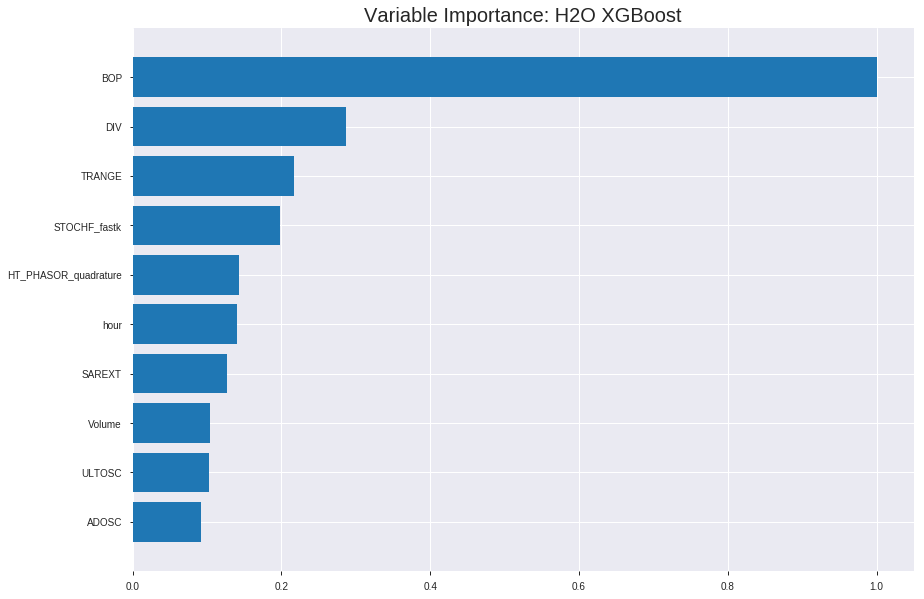

Model Details
H2OXGBoostEstimator :  XGBoost
Model Key:  XGBoost_grid_1_AutoML_20190827_212504_model_2


ModelMetricsBinomial: xgboost
** Reported on train data. **

MSE: 0.14687699223587167
RMSE: 0.3832453420928579
LogLoss: 0.46487412117515015
Mean Per-Class Error: 0.1856862745098039
AUC: 0.8965603190428714
pr_auc: 0.8826083311083437
Gini: 0.7931206380857427
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.46378560066223146: 


0    1    Error    Rate
-----  ---  ---  -------  --------------
0      676  174  0.2047   (174.0/850.0)
1      118  590  0.1667   (118.0/708.0)
Total  794  764  0.1874   (292.0/1558.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.463786     0.80163   199
max f2                       0.282073     0.865457  297
max f0point5                 0.564731     0.822011  145
max accuracy                 0.530478     0.819641  165
max precision                0.877479     1         0
max recall                   0.179573     1         350
max specificity              0.877479     1         0
max absolute_mcc             0.530478     0.636071  165
max min_per_class_accuracy   0.484336     0.809322  189
max mean_per_class_accuracy  0.463786     0.814314  199

Gains/Lift Table: Avg response rate: 45.44 %, avg score: 45.56 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0102696                   0.845839           2.20056   2.20056            1                0.859325  1                           0.859325            0.0225989       0.0225989                  120.056   120.056
    2        0.0205392                   0.830274           2.20056   2.20056            1                0.839428  1                           0.849376            0.0225989       0.0451977                  120.056   120.056
    3        0.0301669                   0.813935           2.20056   2.20056            1                0.822098  1                           0.84067             0.0211864       0.0663842                  120.056   120.056
    4        0.0404365                   0.80499            2.20056   2.20056            1                0.808438  1                           0.832485            0.0225989       0.0889831                  120.056   120.056
    5        0.0500642                   0.79672            2.20056   2.20056            1                0.800854  1                           0.826402            0.0211864       0.110169                   120.056   120.056
    6        0.100128                    0.746337           2.14414   2.17235            0.974359         0.769233  0.987179                    0.797817            0.107345        0.217514                   114.414   117.235
    7        0.150193                    0.713564           2.00308   2.11593            0.910256         0.730763  0.961538                    0.775466            0.100282        0.317797                   100.308   111.593
    8        0.200257                    0.680208           2.00308   2.08772            0.910256         0.698951  0.948718                    0.756337            0.100282        0.418079                   100.308   108.772
    9        0.300385                    0.610937           1.72095   1.96546            0.782051         0.645703  0.893162                    0.719459            0.172316        0.590395                   72.0955   96.5462
    10       0.399872                    0.534048           1.49071   1.84734            0.677419         0.573019  0.839486                    0.683025            0.148305        0.738701                   49.0705   84.7344
    11       0.5                         0.45474            0.987433  1.67514            0.448718         0.496817  0.761232                    0.645736            0.0988701       0.837571                   -1.2567   67.5141
    12       0.600128                    0.368471           0.705309  1.51333            0.320513         0.409752  0.687701                    0.606363            0.0706215       0.908192                   -29.4691  51.333
    13       0.699615                    0.300325           0.45431   1.36274            0.206452         0.332646  0.619266                    0.56744             0.0451977       0.95339                    -54.569   36.2735
    14       0.799743                    0.229599           0.324442  1.23274            0.147436         0.267399  0.560193                    0.529875            0.0324859       0.985876                   -67.5558  23.274
    15       0.899872                    0.158129           0.141062  1.11127            0.0641026        0.191975  0.504993                    0.492277            0.0141243       1                          -85.8938  11.127
    16       1                           0.0857364          0         1                  0                0.126299  0.454429                    0.455632            



ModelMetricsBinomial: xgboost
** Reported on validation data. **

MSE: 0.1978275941991974
RMSE: 0.44477814042418656
LogLoss: 0.5775547713482122
Mean Per-Class Error: 0.2534833651541618
AUC: 0.791983182353658
pr_auc: 0.7349479607738196
Gini: 0.5839663647073161
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.3063267767429352: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      148  91   0.3808   (91.0/239.0)
1      26   180  0.1262   (26.0/206.0)
Total  174  271  0.2629   (117.0/445.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.306327     0.754717  244
max f2                       0.216209     0.844212  294
max f0point5                 0.473743     0.70802   131
max accuracy                 0.306327     0.737079  244
max precision                0.865235     1         0
max recall                   0.0971457    1         396
max specificity              0.865235     1         0
max absolute_mcc             0.306327     0.50379   244
max min_per_class_accuracy   0.377395     0.711297  192
max mean_per_class_accuracy  0.306327     0.746517  244

Gains/Lift Table: Avg response rate: 46.29 %, avg score: 37.58 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.011236                    0.782665           1.72816   1.72816            0.8              0.818763  0.8                         0.818763            0.0194175       0.0194175                  72.8155   72.8155
    2        0.0202247                   0.748592           2.16019   1.92017            1                0.763314  0.888889                    0.794119            0.0194175       0.038835                   116.019   92.0173
    3        0.0314607                   0.730242           2.16019   2.00589            1                0.737501  0.928571                    0.773898            0.0242718       0.0631068                  116.019   100.589
    4        0.0404494                   0.724271           1.62015   1.92017            0.75             0.726298  0.888889                    0.76332             0.0145631       0.0776699                  62.0146   92.0173
    5        0.0516854                   0.695232           2.16019   1.97235            1                0.705108  0.913043                    0.750665            0.0242718       0.101942                   116.019   97.2351
    6        0.101124                    0.642101           1.47286   1.72816            0.681818         0.66462   0.8                         0.708599            0.0728155       0.174757                   47.286    72.8155
    7        0.150562                    0.595872           1.47286   1.64433            0.681818         0.618891  0.761194                    0.679143            0.0728155       0.247573                   47.286    64.4327
    8        0.2                         0.542924           1.66924   1.65049            0.772727         0.565181  0.764045                    0.650972            0.0825243       0.330097                   66.9241   65.0485
    9        0.301124                    0.48344            1.72816   1.67657            0.8              0.514003  0.776119                    0.604975            0.174757        0.504854                   72.8155   67.6569
    10       0.4                         0.426543           1.031     1.51699            0.477273         0.457803  0.702247                    0.568596            0.101942        0.606796                   3.10018   51.699
    11       0.501124                    0.369818           1.34412   1.48211            0.622222         0.398227  0.686099                    0.534216            0.135922        0.742718                   34.4121   48.2106
    12       0.6                         0.310867           1.12919   1.42395            0.522727         0.342161  0.659176                    0.502567            0.11165         0.854369                   12.9192   42.3948
    13       0.698876                    0.229101           0.687335  1.31973            0.318182         0.273832  0.610932                    0.470205            0.0679612       0.92233                    -31.2665  31.9733
    14       0.8                         0.177398           0.288026  1.18932            0.133333         0.20516   0.550562                    0.436702            0.0291262       0.951456                   -71.1974  18.932
    15       0.898876                    0.128162           0.245477  1.0855             0.113636         0.153173  0.5025                      0.405514            0.0242718       0.975728                   -75.4523  8.54976
    16       1                           0.0875609          0.240022  1                  0.111111         0.111839  0.462921                    0.375817           


Scoring History: 


timestamp            duration    number_of_trees    training_rmse    training_logloss    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------  -----------------  ---------------  ------------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-08-27 21:25:10  1.196 sec   0                  0.5              0.693147            0.5             0                  1                0.545571                         0.5                0.693147              0.5               0                    1                  0.537079
    2019-08-27 21:25:11  1.333 sec   5                  0.476703         0.647447            0.829401        0.756824           2.00051          0.235558                         0.480872           0.655422              0.792653          0.722979             1.72816            0.267416
    2019-08-27 21:25:11  1.425 sec   10                 0.458684         0.61285             0.832178        0.7713             2.10054          0.234917                         0.466749           0.627753              0.798574          0.722294             2.16019            0.258427
    2019-08-27 21:25:11  1.526 sec   15                 0.444938         0.5865              0.837625        0.807533           2.20056          0.231707                         0.459318           0.612659              0.796766          0.720986             2.16019            0.27191
    2019-08-27 21:25:11  1.611 sec   20                 0.43421          0.56572             0.84304         0.81495            2.20056          0.238768                         0.454508           0.602387              0.795924          0.72376              1.72816            0.269663
    2019-08-27 21:25:11  1.689 sec   25                 0.425141         0.548064            0.852717        0.829529           2.20056          0.217587                         0.450856           0.594083              0.796909          0.733088             1.72816            0.249438
    2019-08-27 21:25:11  1.771 sec   30                 0.417893         0.533697            0.859515        0.840069           2.20056          0.221438                         0.44876            0.588986              0.795883          0.735253             2.16019            0.260674
    2019-08-27 21:25:11  1.853 sec   35                 0.411175         0.520502            0.866804        0.846459           2.20056          0.216303                         0.447062           0.584869              0.79635           0.736066             1.72816            0.25618
    2019-08-27 21:25:11  1.934 sec   40                 0.406213         0.510377            0.870914        0.850564           2.20056          0.207317                         0.447008           0.583756              0.794481          0.734898             1.72816            0.260674
    2019-08-27 21:25:11  2.026 sec   45                 0.400299         0.498738            0.877695        0.8602             2.20056          0.20154                          0.445944           0.581007              0.793466          0.734984             1.72816            0.27191
    2019-08-27 21:25:11  2.113 sec   50                 0.395674         0.489479            0.882386        0.866385           2.20056          0.204108                         0.445749           0.580051              0.79305           0.733652             1.72816            0.27191
    2019-08-27 21:25:11  2.194 sec   55                 0.391286         0.480762            0.88736         0.870578           2.20056          0.198973                         0.445534           0.579251              0.791465          0.731

Variable Importances: 


variable              relative_importance    scaled_importance      percentage
--------------------  ---------------------  ---------------------  ---------------------
BOP                   2108.247314453125      1.0                    0.2656772685383562
DIV                   605.8555297851562      0.28737403132531153    0.07634874769136478
TRANGE                457.9932556152344      0.21723886589369942    0.05771542851100834
STOCHF_fastk          417.0251770019531      0.19780657332895907    0.052552710100969915
HT_PHASOR_quadrature  301.533935546875       0.1430258838608279     0.037998726154428925
---                   ---                    ---                    ---
CORREL_8              17.46500015258789      0.008284132526984045   0.0022009057019788713
CDLDOJI               17.130311965942383     0.008125380665022192   0.0021587289409174685
CDLSPINNINGTOP        12.325079917907715     0.005846126226943547   0.0015531828475048083
CDLENGULFING          11.159835815429688     0.005293418726979157   0.0014063410286136052
weekday               1.989111065864563      0.0009434903828541265  0.0002506639478088923


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.7130044843049327)

('F1', 0.7058823529411766)

('auc', 0.7703619909502262)

('logloss', 0.5959768382721506)

('mean_per_class_error', 0.2900775694893343)

('rmse', 0.45287537724671817)

('mse', 0.20509610731635727)

xgboost prediction progress: |████████████████████████████████████████████| 100%


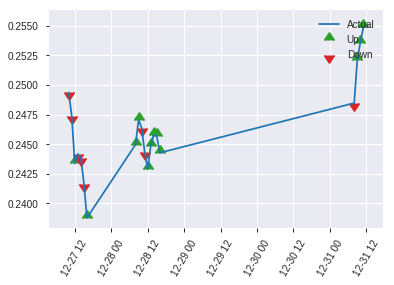


ModelMetricsBinomial: xgboost
** Reported on test data. **

MSE: 0.20509610731635727
RMSE: 0.45287537724671817
LogLoss: 0.5959768382721506
Mean Per-Class Error: 0.2900775694893343
AUC: 0.7703619909502262
pr_auc: 0.7506883031684346
Gini: 0.5407239819004523
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.2838468849658966: 


0    1    Error    Rate
-----  ---  ---  -------  ------------
0      58   61   0.5126   (61.0/119.0)
1      14   90   0.1346   (14.0/104.0)
Total  72   151  0.3363   (75.0/223.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.283847     0.705882  150
max f2                       0.135857     0.837359  204
max f0point5                 0.482616     0.714286  71
max accuracy                 0.482616     0.713004  71
max precision                0.788443     1         0
max recall                   0.135857     1         204
max specificity              0.788443     1         0
max absolute_mcc             0.482616     0.431048  71
max min_per_class_accuracy   0.386243     0.705882  108
max mean_per_class_accuracy  0.378204     0.709922  112

Gains/Lift Table: Avg response rate: 46.64 %, avg score: 38.23 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0134529                   0.754548           2.14423   2.14423            1                0.772912  1                           0.772912            0.0288462       0.0288462                  114.423   114.423
    2        0.0224215                   0.73773            2.14423   2.14423            1                0.747324  1                           0.762677            0.0192308       0.0480769                  114.423   114.423
    3        0.0313901                   0.729799           1.07212   1.83791            0.5              0.731286  0.857143                    0.753708            0.00961538      0.0576923                  7.21154   83.7912
    4        0.0403587                   0.691905           2.14423   1.90598            1                0.716201  0.888889                    0.745373            0.0192308       0.0769231                  114.423   90.5983
    5        0.0538117                   0.673217           2.14423   1.96554            1                0.682546  0.916667                    0.729666            0.0288462       0.105769                   114.423   96.5545
    6        0.103139                    0.603462           2.14423   2.051              1                0.635449  0.956522                    0.684606            0.105769        0.211538                   114.423   105.1
    7        0.152466                    0.566767           1.55944   1.89197            0.727273         0.587396  0.882353                    0.653156            0.0769231       0.288462                   55.9441   89.1968
    8        0.201794                    0.540691           1.36451   1.76303            0.636364         0.555371  0.822222                    0.629253            0.0673077       0.355769                   36.451    76.3034
    9        0.300448                    0.487256           1.46198   1.66418            0.681818         0.506884  0.776119                    0.589072            0.144231        0.5                        46.1976   66.4179
    10       0.399103                    0.419618           0.77972   1.44555            0.363636         0.454952  0.674157                    0.555919            0.0769231       0.576923                   -22.028   44.5549
    11       0.502242                    0.379348           1.39841   1.43587            0.652174         0.400851  0.669643                    0.524074            0.144231        0.721154                   39.8411   43.5869
    12       0.600897                    0.346949           0.682255  1.31214            0.318182         0.366348  0.61194                     0.498179            0.0673077       0.788462                   -31.7745  31.2141
    13       0.699552                    0.267486           0.77972   1.23706            0.363636         0.304887  0.576923                    0.47092             0.0769231       0.865385                   -22.028   23.7056
    14       0.798206                    0.198127           0.682255  1.16849            0.318182         0.237106  0.544944                    0.442022            0.0673077       0.932692                   -31.7745  16.8485
    15       0.896861                    0.154002           0.487325  1.09356            0.227273         0.172126  0.51                        0.412333            0.0480769       0.980769                   -51.2675  9.35577
    16       1                           0.0944787          0.186455  1                  0.0869565        0.12132   0.466368                    0.382318           

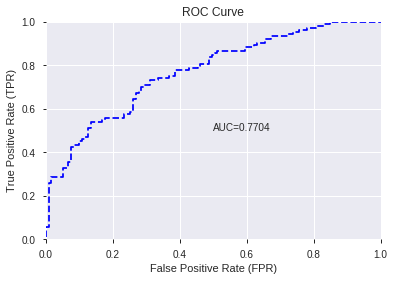

This function is available for GLM models only


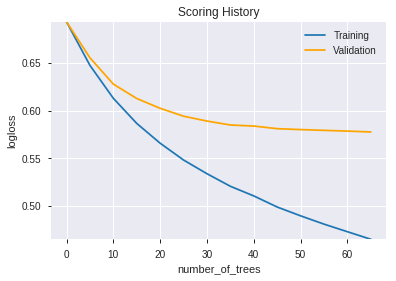

--2019-08-27 21:25:26--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.88.211
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.88.211|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
Exception in thread "main" java.lang.StackOverflowError
	at hex.genmodel.algos.tree.SharedTreeNode.findInclusiveNa(SharedTreeNode.java:129)
	at hex.genmodel.algos.tree.SharedTreeNode.findInclusiveNa(SharedTreeNode.java:129)
	at hex.genmodel.algos.tree.SharedTreeNode.findInclusiveNa(SharedTreeNode.java:129)
	at hex.genmodel.algos.tree.SharedTreeNode.findInclusiveNa(SharedTreeNode.java:129)
	at hex.genmodel.algos.tree.SharedTreeNode.calculateChildInclusiveNa(SharedTreeNode.java:133)
	at hex.genmodel.algos.tree.SharedTreeNode.setLeftChild(SharedTr

[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/XGBoost_grid_1_AutoML_20190827_212504_model_2',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'XGBoost_grid_1_AutoML_20190827_212504_model_2',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_66_sid_82c1',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training

['BOP',
 'DIV',
 'TRANGE',
 'STOCHF_fastk',
 'HT_PHASOR_quadrature',
 'hour',
 'SAREXT',
 'Volume',
 'ULTOSC',
 'ADOSC',
 'BETA_8',
 'ADXR_14',
 'BETA_30',
 'PLUS_DI_8',
 'DX_8',
 'STOCHRSI_fastk',
 'CDLCLOSINGMARUBOZU',
 'WILLR_8',
 'SUB',
 'CDLHAMMER',
 'STOCHRSI_fastd',
 'aroondown_20',
 'PLUS_DM_12',
 'aroonup_14',
 'STOCH_slowd',
 'aroondown_12',
 'aroondown_8',
 'dayofweek',
 'PLUS_DI_12',
 'HT_TRENDMODE',
 'WILLR_12',
 'CORREL_14',
 'aroonup_8',
 'STOCHF_fastd',
 'CORREL_12',
 'CDLSHORTLINE',
 'WILLR_14',
 'weekday_name',
 'CDLLONGLINE',
 'days_in_month',
 'CORREL_8',
 'CDLDOJI',
 'CDLSPINNINGTOP',
 'CDLENGULFING',
 'weekday']

In [21]:
# XGBoost with top XGBoost features
model_train(feature_name='XGBF',model_algo="XGBoost",features_list = features_list[:model_selected_features])

In [0]:
# PCA
try:
  del xgb_features,glm_features,dl_features
except:
  pass
gc.collect()

if features_to_include is True or 'PCA' in features_to_include:
  for _ in range(3):
    try:
      from h2o.estimators.pca import H2OPrincipalComponentAnalysisEstimator
      h2o_model = H2OPrincipalComponentAnalysisEstimator(seed=1, k=PCA_k, pca_method="GramSVD", max_iterations=10000)
      h2o_model.train(x=list(train_hf.columns[:-1]), training_frame=train_hf[:index_splits[0],:])

      display(h2o_model.varimp(use_pandas=True))
      display(h2o_model)

      training_frame = h2o_model.predict(train_hf)
      del h2o_model, H2OPrincipalComponentAnalysisEstimator
      gc.collect()

      training_frame = training_frame.cbind(train_hf[data_label_name])
      break
    except KeyboardInterrupt:
      break
    except Exception as e:
      print(e)
      load_h2o()
else:
  training_frame = []

In [23]:
# DeepLearning with PCA
model_train(feature_name='PCA',model_algo="DeepLearning",training_frame=training_frame)

[]

In [24]:
# GLM with PCA
model_train(feature_name='PCA',model_algo="GLM",training_frame=training_frame)

[]

In [25]:
# XGBoost with PCA
model_train(feature_name='PCA',model_algo="XGBoost",training_frame=training_frame)

[]

In [0]:
# Generalized Low Rank
try:
  del training_frame
except:
  pass
gc.collect()

if features_to_include is True or 'GLRM' in features_to_include:
  for _ in range(3):
    try:
      from h2o.estimators.glrm import H2OGeneralizedLowRankEstimator

      h2o_model = H2OGeneralizedLowRankEstimator(seed=1, k=GLRM_k)
      h2o_model.train(x=list(train_hf.columns[:-1]), training_frame=train_hf[:index_splits[0],:])

      display(h2o_model.varimp(use_pandas=True))
      display(h2o_model)

      training_frame = h2o_model.predict(train_hf)
      del h2o_model, H2OGeneralizedLowRankEstimator
      gc.collect()

      training_frame = training_frame.cbind(train_hf[data_label_name])
      break
    except KeyboardInterrupt:
      break
    except Exception as e:
      print(e)
      load_h2o()
else:
  training_frame = []

In [27]:
# DeepLearning with Generalized Low Rank
model_train(feature_name='GLRM',model_algo="DeepLearning",training_frame=training_frame)

[]

In [28]:
# GLM with Generalized Low Rank
model_train(feature_name='GLRM',model_algo="GLM",training_frame=training_frame)

[]

In [29]:
# XGBoost with Generalized Low Rank
model_train(feature_name='GLRM',model_algo="XGBoost",training_frame=training_frame)

[]

In [0]:
# High Correlation Filter 
try:
  del training_frame
except:
  pass
gc.collect()

if features_to_include is True or 'HCF' in features_to_include:
  corr_matrix = pd.read_pickle('scaled_df')[:index_splits[0]].drop(data_label_name,axis=1).corr().abs()

  upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))

  features_list = [column for column in upper.columns if not any(upper[column] > HCF_threshold)]

  del corr_matrix, upper
  gc.collect()

  display(len(features_list),features_list)
else:
  features_list = []

In [31]:
# DeepLearning with low correlation features
model_train(feature_name='HCF',model_algo="DeepLearning",features_list=features_list)

[]

In [32]:
# GLM with low correlation features
model_train(feature_name='HCF',model_algo="GLM",features_list=features_list)

[]

In [33]:
# XGBoost with low correlation features
model_train(feature_name='HCF',model_algo="XGBoost",features_list=features_list)

[]

In [0]:
#	Low Variance Filter  
try:
  del features_list
except:
  pass
gc.collect()

if features_to_include is True or 'LVF' in features_to_include:
  df_variance = pd.read_pickle('scaled_df')[:index_splits[0]].drop(data_label_name,axis=1).var()
  features_list = [column for column in df_variance.index if df_variance[column]  > LVF_threshold]

  del df_variance
  gc.collect()

  display(len(features_list),features_list)
else:
  features_list = []

In [35]:
# DeepLearning with Low Variance features  
model_train(feature_name='LVF',model_algo="DeepLearning",features_list=features_list)

[]

In [36]:
# GLM with Low Variance features  
model_train(feature_name='LVF',model_algo="GLM",features_list=features_list)

[]

In [37]:
# XGBoost with Low Variance features  
model_train(feature_name='LVF',model_algo="XGBoost",features_list=features_list)

[]

In [0]:
# Select k best features
try:
  del features_list
except:
  pass
gc.collect()

if features_to_include is True or 'KBest' in features_to_include:
  from sklearn.feature_selection import SelectKBest
  from sklearn.feature_selection import f_classif

  bestfeatures = SelectKBest(score_func=f_classif, k=select_k).fit(pd.read_pickle('scaled_df')[:index_splits[0]].drop(data_label_name,axis=1)
                                                              ,pd.read_pickle('scaled_df')[:index_splits[0]][data_label_name])

  features_list = list(np.array(train_hf.columns)[:-1][bestfeatures.get_support()])

  del bestfeatures, SelectKBest, f_classif
  gc.collect()
  display(len(features_list),features_list)
else:
  features_list=[]

In [39]:
# DeepLearning with Select k best features 
model_train(feature_name='KBest',model_algo="DeepLearning",features_list=features_list)

[]

In [40]:
# GLM with Select k best features
model_train(feature_name='KBest',model_algo="GLM",features_list=features_list)

[]

In [41]:
# XGBoost with Select k best features
model_train(feature_name='KBest',model_algo="XGBoost",features_list=features_list)

[]

In [0]:
# Select Percentile
try:
  del features_list
except:
  pass
gc.collect()

if features_to_include is True or 'Percentile' in features_to_include:
  from sklearn.feature_selection import SelectPercentile
  from sklearn.feature_selection import f_classif

  bestfeatures = SelectPercentile(score_func=f_classif, percentile=select_percentile).fit(pd.read_pickle('scaled_df')[:index_splits[0]].drop(data_label_name,axis=1)
                                                              ,pd.read_pickle('scaled_df')[:index_splits[0]][data_label_name])

  features_list = list(np.array(train_hf.columns)[:-1][bestfeatures.get_support()])

  del bestfeatures, SelectPercentile, f_classif
  gc.collect()
  display(len(features_list),features_list)
else:
  features_list=[]

In [43]:
# DeepLearning with Select Percentile features  
model_train(feature_name='Percentile',model_algo="DeepLearning",features_list=features_list)

[]

In [44]:
# GLM with Select Percentile features  
model_train(feature_name='Percentile',model_algo="GLM",features_list=features_list)

[]

In [45]:
# XGBoost with Select Percentile features  
model_train(feature_name='Percentile',model_algo="XGBoost",features_list=features_list)

[]

In [46]:
# Select Family-wise error
try:
  del features_list
except:
  pass
gc.collect()

if features_to_include is True or 'Fwe' in features_to_include:
  from sklearn.feature_selection import SelectFwe
  from sklearn.feature_selection import f_classif

  bestfeatures = SelectFwe(score_func=f_classif, alpha=select_alpha).fit(pd.read_pickle('scaled_df')[:index_splits[0]].drop(data_label_name,axis=1)
                                                              ,pd.read_pickle('scaled_df')[:index_splits[0]][data_label_name])

  features_list = list(np.array(train_hf.columns)[:-1][bestfeatures.get_support()])

  del bestfeatures, SelectFwe, f_classif
  gc.collect()
  display(len(features_list),features_list)
else:
  features_list=[]

/usr/local/lib/python3.6/dist-packages/sklearn/feature_selection/univariate_selection.py:114: UserWarning: Features [ 12  13 915 925 927 933] are constant.
  UserWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/feature_selection/univariate_selection.py:115: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/usr/local/lib/python3.6/dist-packages/sklearn/feature_selection/univariate_selection.py:721: RuntimeWarning: invalid value encountered in less
  return (self.pvalues_ < self.alpha / len(self.pvalues_))


71

['Volume',
 'hour',
 'BOP',
 'CCI_8',
 'CMO_8',
 'MINUS_DI_8',
 'MINUS_DM_8',
 'MOM_8',
 'ROC_8',
 'ROCP_8',
 'ROCR_8',
 'ROCR100_8',
 'RSI_8',
 'WILLR_8',
 'CCI_12',
 'CMO_12',
 'MINUS_DI_12',
 'MINUS_DM_12',
 'MOM_12',
 'ROC_12',
 'ROCP_12',
 'ROCR_12',
 'ROCR100_12',
 'RSI_12',
 'WILLR_12',
 'CCI_14',
 'CMO_14',
 'MINUS_DI_14',
 'MOM_14',
 'ROC_14',
 'ROCP_14',
 'ROCR_14',
 'ROCR100_14',
 'RSI_14',
 'WILLR_14',
 'CCI_20',
 'CMO_20',
 'ROC_20',
 'ROCP_20',
 'ROCR_20',
 'ROCR100_20',
 'RSI_20',
 'WILLR_20',
 'CCI_24',
 'CMO_24',
 'RSI_24',
 'WILLR_24',
 'CCI_30',
 'CMO_30',
 'RSI_30',
 'WILLR_30',
 'STOCH_slowk',
 'STOCHF_fastk',
 'STOCHF_fastd',
 'STOCHRSI_fastk',
 'STOCHRSI_fastd',
 'ULTOSC',
 'ADOSC',
 'ATR_8',
 'NATR_8',
 'TRANGE',
 'CDLBELTHOLD',
 'CDLCLOSINGMARUBOZU',
 'CDLENGULFING',
 'CDLLONGLINE',
 'CDLMARUBOZU',
 'CDLSHORTLINE',
 'LINEARREG_ANGLE_8',
 'LINEARREG_SLOPE_8',
 'DIV',
 'SUB']

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  DeepLearning_grid_1_AutoML_20190827_212536_model_8  0.772220  0.606947              0.334963  0.459642  0.211270
1  DeepLearning_grid_1_AutoML_20190827_212536_model_5  0.764544  0.613058              0.355365  0.461283  0.212782
2  DeepLearning_grid_1_AutoML_20190827_212536_model_6  0.755090  0.596358              0.351164  0.453177  0.205370
3  DeepLearning_grid_1_AutoML_20190827_212536_model_9  0.754363  0.604042              0.348174  0.456189  0.208108
4  DeepLearning_grid_1_AutoML_20190827_212536_model_4  0.752101  0.755496              0.291209  0.490403  0.240495
5  DeepLearning_grid_1_AutoML_20190827_212536_model_7  0.735213  0.673679              0.360173  0.473198  0.223917
6  DeepLearning_grid_1_AutoML_20190827_212536_model_3  0.709438  0.731527              0.378192  0.492086  0.242149
7  DeepLearning_grid_1_AutoML_20190827_212536_model_2  0.704347  0.693321              0.357789  0.480584  0.230961
8  DeepLearning_grid_1_AutoML_20190827_212536_model_1  0.690853  0.885258              0.323610  0.518907  0.269265
9               DeepLearning_1_AutoML_20190827_212536  0.663704  0.920593              0.425582  0.540458  0.292095

variable  relative_importance  scaled_importance  percentage
0                  BOP             1.000000           1.000000    0.031150
1   CDLCLOSINGMARUBOZU             0.954182           0.954182    0.029723
2                 hour             0.777877           0.777877    0.024231
3                  DIV             0.753274           0.753274    0.023465
4               TRANGE             0.720498           0.720498    0.022444
..                 ...                  ...                ...         ...
66            WILLR_20             0.360001           0.360001    0.011214
67               RSI_8             0.358428           0.358428    0.011165
68              ROCP_8             0.352076           0.352076    0.010967
69              CMO_12             0.346310           0.346310    0.010788
70              RSI_14             0.332151           0.332151    0.010347

[71 rows x 4 columns]

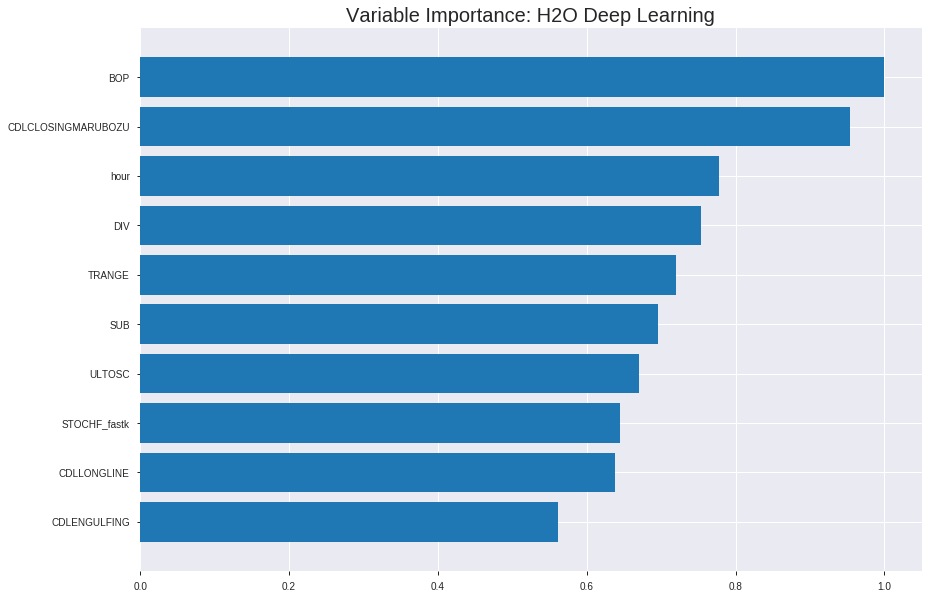

Model Details
H2ODeepLearningEstimator :  Deep Learning
Model Key:  DeepLearning_grid_1_AutoML_20190827_212536_model_8


ModelMetricsBinomial: deeplearning
** Reported on train data. **

MSE: 0.19040787805960235
RMSE: 0.43635751174879794
LogLoss: 0.5571760038990072
Mean Per-Class Error: 0.2920654702558989
AUC: 0.7848246925888999
pr_auc: 0.7395842205937934
Gini: 0.5696493851777997
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.40137871391826246: 


0    1    Error    Rate
-----  ---  ---  -------  --------------
0      470  380  0.4471   (380.0/850.0)
1      114  594  0.161    (114.0/708.0)
Total  584  974  0.3171   (494.0/1558.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.401379     0.706302  227
max f2                       0.19401      0.836132  325
max f0point5                 0.490913     0.691044  167
max accuracy                 0.490913     0.71181   167
max precision                0.95166      1         0
max recall                   0.059903     1         381
max specificity              0.95166      1         0
max absolute_mcc             0.490913     0.415486  167
max min_per_class_accuracy   0.457139     0.704802  189
max mean_per_class_accuracy  0.450311     0.707935  193

Gains/Lift Table: Avg response rate: 45.44 %, avg score: 44.16 %



group    cumulative_data_fraction    lower_threshold    lift       cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  ---------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0102696                   0.932371           2.06303    2.06303            0.9375           0.940976   0.9375                      0.940976            0.0211864       0.0211864                  106.303   106.303
    2        0.0205392                   0.915366           2.06303    2.06303            0.9375           0.923665   0.9375                      0.932321            0.0211864       0.0423729                  106.303   106.303
    3        0.0301669                   0.905837           1.76045    1.96646            0.8              0.909903   0.893617                    0.925166            0.0169492       0.059322                   76.0452   96.6462
    4        0.0404365                   0.879275           1.92549    1.95606            0.875            0.893997   0.888889                    0.91725             0.019774        0.079096                   92.5494   95.6058
    5        0.0500642                   0.844564           2.05386    1.97487            0.933333         0.862052   0.897436                    0.906635            0.019774        0.0988701                  105.386   97.4866
    6        0.100128                    0.696958           1.91844    1.94665            0.871795         0.757789   0.884615                    0.832212            0.0960452       0.194915                   91.8441   94.6654
    7        0.150193                    0.63561            1.63632    1.84321            0.74359          0.664283   0.837607                    0.776236            0.0819209       0.276836                   63.6318   84.3208
    8        0.200257                    0.58148            1.57989    1.77738            0.717949         0.609563   0.807692                    0.734567            0.079096        0.355932                   57.9893   77.7379
    9        0.300385                    0.518232           1.34009    1.63162            0.608974         0.549498   0.741453                    0.672878            0.134181        0.490113                   34.0088   63.1615
    10       0.399872                    0.484939           1.30614    1.55064            0.593548         0.500877   0.704655                    0.630084            0.129944        0.620056                   30.6142   55.0639
    11       0.5                         0.447198           1.05796    1.45198            0.480769         0.467952   0.65982                     0.597616            0.105932        0.725989                   5.79639   45.1977
    12       0.600128                    0.410669           0.902796   1.36035            0.410256         0.42835    0.618182                    0.569375            0.0903955       0.816384                   -9.72041  36.0349
    13       0.699615                    0.370756           0.70986    1.26785            0.322581         0.391455   0.576147                    0.544074            0.0706215       0.887006                   -29.014   26.7848
    14       0.799743                    0.278287           0.691203   1.19565            0.314103         0.331925   0.543339                    0.517513            0.069209        0.956215                   -30.8797  19.5652
    15       0.899872                    0.125284           0.366761   1.10342            0.166667         0.205096   0.501427                    0.482751            0.0367232       0.992938                   -63.3239  10.3422
    16       1                           0.00812061         0.0705309  1                  0.0320513        0.0719842  0.454429 



ModelMetricsBinomial: deeplearning
** Reported on validation data. **

MSE: 0.20929012624831847
RMSE: 0.45748237807408326
LogLoss: 0.6056921390319422
Mean Per-Class Error: 0.27524678068001784
AUC: 0.7701893000771823
pr_auc: 0.6961934789125664
Gini: 0.5403786001543647
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.3333289469662286: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      143  96   0.4017   (96.0/239.0)
1      32   174  0.1553   (32.0/206.0)
Total  175  270  0.2876   (128.0/445.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.333329     0.731092  238
max f2                       0.192216     0.836892  309
max f0point5                 0.403462     0.695266  178
max accuracy                 0.360625     0.719101  216
max precision                0.902994     1         0
max recall                   0.0198236    1         387
max specificity              0.902994     1         0
max absolute_mcc             0.333329     0.452191  238
max min_per_class_accuracy   0.386708     0.703883  189
max mean_per_class_accuracy  0.353354     0.724753  220

Gains/Lift Table: Avg response rate: 46.29 %, avg score: 36.16 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.011236                    0.880447           1.72816   1.72816            0.8              0.892352   0.8                         0.892352            0.0194175       0.0194175                  72.8155   72.8155
    2        0.0202247                   0.84741            1.62015   1.68015            0.75             0.862063   0.777778                    0.87889             0.0145631       0.0339806                  62.0146   68.0151
    3        0.0314607                   0.823087           2.16019   1.8516             1                0.838399   0.857143                    0.864429            0.0242718       0.0582524                  116.019   85.1595
    4        0.0404494                   0.756311           1.62015   1.80016            0.75             0.797567   0.833333                    0.849571            0.0145631       0.0728155                  62.0146   80.0162
    5        0.0516854                   0.692451           0.864078  1.59667            0.4              0.722599   0.73913                     0.821968            0.00970874      0.0825243                  -13.5922  59.6665
    6        0.101124                    0.56734            1.66924   1.63215            0.772727         0.602177   0.755556                    0.714515            0.0825243       0.165049                   66.9241   63.2147
    7        0.150562                    0.531945           1.57105   1.61209            0.727273         0.548382   0.746269                    0.659964            0.0776699       0.242718                   57.105    61.2085
    8        0.2                         0.502336           1.57105   1.60194            0.727273         0.518042   0.741573                    0.624882            0.0776699       0.320388                   57.105    60.1942
    9        0.301124                    0.458256           1.29612   1.49924            0.6              0.481726   0.69403                     0.576807            0.131068        0.451456                   29.6117   49.9239
    10       0.4                         0.421706           1.57105   1.51699            0.727273         0.44239    0.702247                    0.543581            0.15534         0.606796                   57.105    51.699
    11       0.501124                    0.37879            1.20011   1.45305            0.555556         0.401855   0.672646                    0.514981            0.121359        0.728155                   20.0108   45.3045
    12       0.6                         0.334297           1.031     1.3835             0.477273         0.357808   0.640449                    0.48908             0.101942        0.830097                   3.10018   38.3495
    13       0.698876                    0.267658           0.638239  1.27806            0.295455         0.304237   0.59164                     0.462929            0.0631068       0.893204                   -36.1761  27.8057
    14       0.8                         0.17644            0.576052  1.18932            0.266667         0.226689   0.550562                    0.433067            0.0582524       0.951456                   -42.3948  18.932
    15       0.898876                    0.0732518          0.245477  1.0855             0.113636         0.119376   0.5025                      0.398561            0.0242718       0.975728                   -75.4523  8.54976
    16       1                           0.00577629         0.240022  1                  0.111111         0.0327416  0.462921                    0


Scoring History: 


timestamp            duration          training_speed    epochs    iterations    samples    training_rmse    training_logloss    training_r2    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_r2    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------------  ----------------  --------  ------------  ---------  ---------------  ------------------  -------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ---------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-08-27 21:31:09  0.000 sec                           0         0             0          nan              nan                 nan            nan             nan                nan              nan                              nan                nan                   nan              nan               nan                  nan                nan
    2019-08-27 21:31:11  1 min  8.899 sec  577 obs/sec       0.539795  1             841        0.482124         0.669547            0.0624369      0.704594        0.645385           1.65042          0.378691                         0.511787           0.79088               -0.053499        0.691159          0.651505             2.16019            0.391011
    2019-08-27 21:31:21  1 min 18.873 sec  894 obs/sec       5.98524   11            9325       0.445247         0.577448            0.200379       0.772935        0.725269           2.06303          0.327343                         0.470981           0.63065               0.107803         0.760409          0.69493              2.16019            0.319101
    2019-08-27 21:31:31  1 min 29.269 sec  1024 obs/sec      13.0873   24            20390      0.446144         0.578507            0.197154       0.777825        0.733615           2.06303          0.324775                         0.477029           0.656411              0.084739         0.770728          0.70098              2.16019            0.319101
    2019-08-27 21:31:41  1 min 38.982 sec  1096 obs/sec      20.1874   37            31452      0.436358         0.557176            0.231989       0.784825        0.739584           2.06303          0.317073                         0.457482           0.605692              0.15821          0.770189          0.696193             1.72816            0.28764
    2019-08-27 21:31:51  1 min 48.816 sec  1155 obs/sec      27.9031   51            43473      0.430149         0.543304            0.253688       0.795519        0.754331           1.92549          0.277279                         0.452755           0.610858              0.175516         0.77151           0.71361              2.16019            0.314607
    2019-08-27 21:32:00  1 min 58.137 sec  1202 obs/sec      35.5122   65            55328      0.44075          0.564513            0.21645        0.798889        0.765778           2.06303          0.306804                         0.469203           0.631891              0.114523         0.776181          0.711801             2.16019            0.285393
    2019-08-27 21:32:10  2 min  7.903 sec  1242 obs/sec      43.6938   80            68075      0.426009         0.532426            0.267983       0.802141        0.770345           2.20056          0.28819                          0.47097            0.64354               0.107844         0.750782          0.675215             1.72816            0.31236
    2019-08-27 21:32:11  2 min  8.877 sec  1241 obs/sec      43.6938   80            68075      0.436358         0.557176            0.231989       0.784825        0.739584           2.06303          0.317073                         0.457482           0.605692              0.15821          0.770189          0.696193             1.72816            0.28764

Variable Importances: 


variable            relative_importance    scaled_importance    percentage
------------------  ---------------------  -------------------  --------------------
BOP                 1.0                    1.0                  0.03115005781415844
CDLCLOSINGMARUBOZU  0.9541823863983154     0.9541823863983154   0.029722836501559192
hour                0.7778769731521606     0.7778769731521606   0.024230912685992374
DIV                 0.7532740831375122     0.7532740831375122   0.023464531239640696
TRANGE              0.7204983830451965     0.7204983830451965   0.022443566286865543
---                 ---                    ---                  ---
WILLR_20            0.3600008189678192     0.3600008189678192   0.011214046323991955
RSI_8               0.35842767357826233    0.35842767357826233  0.011165042754157181
ROCP_8              0.3520762622356415     0.3520762622356415   0.010967195923633039
CMO_12              0.3463096022605896     0.3463096022605896   0.01078756413201558
RSI_14              0.3321513235569        0.3321513235569      0.010346532931846682


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.7219730941704036)

('F1', 0.7148014440433214)

('auc', 0.7722204266321914)

('logloss', 0.6069473047742704)

('mean_per_class_error', 0.28413865546218486)

('rmse', 0.4596415858121605)

('mse', 0.21127038740791773)

deeplearning prediction progress: |███████████████████████████████████████| 100%


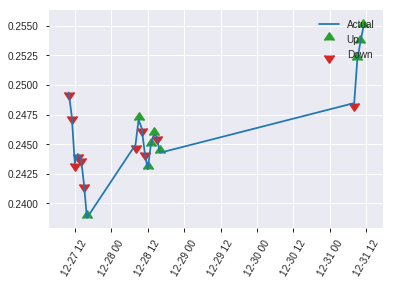


ModelMetricsBinomial: deeplearning
** Reported on test data. **

MSE: 0.21127038740791773
RMSE: 0.4596415858121605
LogLoss: 0.6069473047742704
Mean Per-Class Error: 0.28413865546218486
AUC: 0.7722204266321914
pr_auc: 0.7331750366800759
Gini: 0.5444408532643827
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.21630622089129686: 


0    1    Error    Rate
-----  ---  ---  -------  ------------
0      45   74   0.6218   (74.0/119.0)
1      5    99   0.0481   (5.0/104.0)
Total  50   173  0.3543   (79.0/223.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.216306     0.714801  172
max f2                       0.216306     0.840407  172
max f0point5                 0.430799     0.719697  72
max accuracy                 0.415554     0.721973  87
max precision                0.874994     1         0
max recall                   0.0352665    1         216
max specificity              0.874994     1         0
max absolute_mcc             0.415554     0.440643  87
max min_per_class_accuracy   0.388477     0.705882  108
max mean_per_class_accuracy  0.415554     0.715861  87

Gains/Lift Table: Avg response rate: 46.64 %, avg score: 35.46 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0134529                   0.803766           2.14423   2.14423            1                0.845884   1                           0.845884            0.0288462       0.0288462                  114.423   114.423
    2        0.0224215                   0.753061           2.14423   2.14423            1                0.778181   1                           0.818803            0.0192308       0.0480769                  114.423   114.423
    3        0.0313901                   0.730007           2.14423   2.14423            1                0.748521   1                           0.798722            0.0192308       0.0673077                  114.423   114.423
    4        0.0403587                   0.671173           1.07212   1.90598            0.5              0.71888    0.888889                    0.78098             0.00961538      0.0769231                  7.21154   90.5983
    5        0.0538117                   0.650106           1.42949   1.78686            0.666667         0.657713   0.833333                    0.750163            0.0192308       0.0961538                  42.9487   78.6859
    6        0.103139                    0.541805           1.55944   1.67809            0.727273         0.577076   0.782609                    0.667382            0.0769231       0.173077                   55.9441   67.8094
    7        0.152466                    0.509401           2.14423   1.8289             1                0.523578   0.852941                    0.620857            0.105769        0.278846                   114.423   82.8903
    8        0.201794                    0.483567           1.36451   1.71538            0.636364         0.493682   0.8                         0.58977             0.0673077       0.346154                   36.451    71.5385
    9        0.300448                    0.437162           1.46198   1.63218            0.681818         0.463119   0.761194                    0.548183            0.144231        0.490385                   46.1976   63.2176
    10       0.399103                    0.412431           1.36451   1.56601            0.636364         0.425546   0.730337                    0.517868            0.134615        0.625                      36.451    56.6011
    11       0.502242                    0.387619           0.932274  1.43587            0.434783         0.397717   0.669643                    0.493194            0.0961538       0.721154                   -6.77258  43.5869
    12       0.600897                    0.349154           0.77972   1.32814            0.363636         0.366904   0.619403                    0.47246             0.0769231       0.798077                   -22.028   32.8143
    13       0.699552                    0.283369           0.487325  1.20957            0.227273         0.315223   0.564103                    0.450286            0.0480769       0.846154                   -51.2675  20.9566
    14       0.798206                    0.162895           1.07212   1.19258            0.5              0.236355   0.55618                     0.423845            0.105769        0.951923                   7.21154   19.2578
    15       0.896861                    0.0829789          0.292395  1.09356            0.136364         0.119079   0.51                        0.390321            0.0288462       0.980769                   -70.7605  9.35577
    16       1                           0.006619           0.186455  1                  0.0869565        0.0438494  0.466368                   

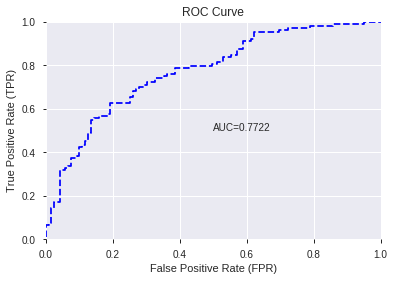

This function is available for GLM models only


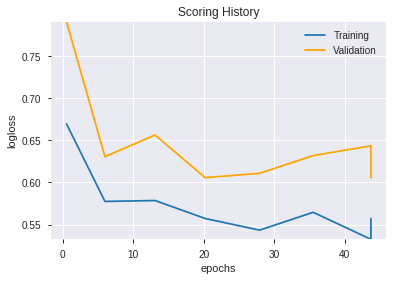

--2019-08-27 21:33:40--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.185.219
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.185.219|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/DeepLearning_grid_1_AutoML_20190827_212536_model_8',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'DeepLearning_grid_1_AutoML_20190827_212536_model_8',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_74_sid_82c1',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'autom

['BOP',
 'CDLCLOSINGMARUBOZU',
 'hour',
 'DIV',
 'TRANGE',
 'SUB',
 'ULTOSC',
 'STOCHF_fastk',
 'CDLLONGLINE',
 'CDLENGULFING',
 'CCI_8',
 'STOCHRSI_fastk',
 'ADOSC',
 'CDLSHORTLINE',
 'STOCHRSI_fastd',
 'LINEARREG_SLOPE_8',
 'STOCHF_fastd',
 'CCI_12',
 'ATR_8',
 'Volume',
 'WILLR_8',
 'NATR_8',
 'STOCH_slowk',
 'CDLBELTHOLD',
 'CDLMARUBOZU',
 'CCI_30',
 'LINEARREG_ANGLE_8',
 'WILLR_12',
 'WILLR_24',
 'WILLR_30',
 'MINUS_DI_8',
 'CMO_30',
 'ROCP_14',
 'CCI_20',
 'RSI_24',
 'RSI_30',
 'ROCR_12',
 'ROCR100_14',
 'ROCR100_20',
 'MOM_14',
 'MOM_12',
 'ROCR_20',
 'WILLR_14',
 'MINUS_DI_12',
 'MINUS_DM_8',
 'CMO_20',
 'CMO_24',
 'MINUS_DI_14',
 'ROCP_12',
 'ROCR100_8',
 'CCI_24',
 'MOM_8',
 'CCI_14',
 'ROCR_8',
 'RSI_20',
 'ROC_8',
 'ROC_12',
 'ROC_14',
 'ROCR_14',
 'ROCP_20',
 'ROCR100_12',
 'MINUS_DM_12',
 'RSI_12',
 'ROC_20',
 'CMO_8',
 'CMO_14',
 'WILLR_20',
 'RSI_8',
 'ROCP_8',
 'CMO_12',
 'RSI_14']

In [47]:
# DeepLearning with Select Family-wise error features
model_train(feature_name='Fwe',model_algo="DeepLearning",features_list=features_list)

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  GLM_grid_1_AutoML_20190827_213350_model_1  0.748384  0.610567              0.364375  0.460733  0.212275

variable  relative_importance  scaled_importance  percentage
0                  BOP             0.262821           1.000000    0.112841
1   CDLCLOSINGMARUBOZU             0.180944           0.688469    0.077688
2         STOCHF_fastk             0.125461           0.477365    0.053866
3          CDLLONGLINE             0.123301           0.469146    0.052939
4                  SUB             0.116932           0.444913    0.050205
..                 ...                  ...                ...         ...
66              CMO_14             0.001812           0.006894    0.000778
67              ROCP_8             0.001725           0.006563    0.000741
68              ROCR_8             0.001712           0.006513    0.000735
69               ROC_8             0.001689           0.006425    0.000725
70           ROCR100_8             0.001680           0.006393    0.000721

[71 rows x 4 columns]

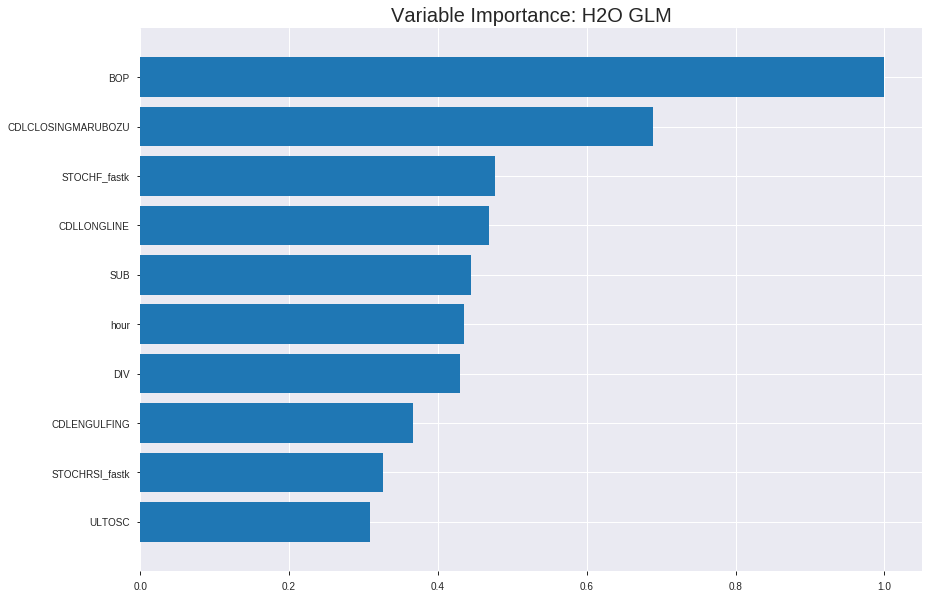

Model Details
H2OGeneralizedLinearEstimator :  Generalized Linear Modeling
Model Key:  GLM_grid_1_AutoML_20190827_213350_model_1


ModelMetricsBinomialGLM: glm
** Reported on train data. **

MSE: 0.1993364899252052
RMSE: 0.44647115239979973
LogLoss: 0.5831816061262922
Null degrees of freedom: 1557
Residual degrees of freedom: 1486
Null deviance: 2146.8864027643094
Residual deviance: 1817.1938846895264
AIC: 1961.1938846895264
AUC: 0.762892987703556
pr_auc: 0.7071523577131346
Gini: 0.5257859754071119
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.3882694832227252: 


0    1    Error    Rate
-----  ---  ---  -------  --------------
0      450  400  0.4706   (400.0/850.0)
1      110  598  0.1554   (110.0/708.0)
Total  560  998  0.3273   (510.0/1558.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.388269     0.701055  245
max f2                       0.251337     0.826317  322
max f0point5                 0.494211     0.66795   177
max accuracy                 0.469648     0.698973  193
max precision                0.729977     0.893617  41
max recall                   0.0699138    1         395
max specificity              0.880339     0.998824  0
max absolute_mcc             0.469648     0.396576  193
max min_per_class_accuracy   0.469648     0.698824  193
max mean_per_class_accuracy  0.469648     0.698988  193

Gains/Lift Table: Avg response rate: 45.44 %, avg score: 45.44 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0102696                   0.843702           1.78796   1.78796            0.8125           0.861797  0.8125                      0.861797            0.0183616       0.0183616                  78.7959   78.7959
    2        0.0205392                   0.814521           1.92549   1.85673            0.875            0.830786  0.84375                     0.846292            0.019774        0.0381356                  92.5494   85.6727
    3        0.0301669                   0.78692            1.90716   1.87282            0.866667         0.802679  0.851064                    0.832373            0.0183616       0.0564972                  90.7156   87.2821
    4        0.0404365                   0.758961           2.06303   1.92113            0.9375           0.769006  0.873016                    0.81628             0.0211864       0.0776836                  106.303   92.1128
    5        0.0500642                   0.742638           1.90716   1.91844            0.866667         0.75096   0.871795                    0.803718            0.0183616       0.0960452                  90.7156   91.8441
    6        0.100128                    0.677569           1.8338    1.87612            0.833333         0.709423  0.852564                    0.756571            0.0918079       0.187853                   83.3804   87.6123
    7        0.150193                    0.640574           1.55168   1.76798            0.705128         0.658805  0.803419                    0.723982            0.0776836       0.265537                   55.168    76.7975
    8        0.200257                    0.608876           1.38241   1.67158            0.628205         0.624456  0.759615                    0.6991              0.069209        0.334746                   38.2406   67.1583
    9        0.300385                    0.55735            1.41062   1.58459            0.641026         0.58481   0.720085                    0.661004            0.141243        0.475989                   41.0619   58.4595
    10       0.399872                    0.507499           1.24935   1.50119            0.567742         0.531172  0.682183                    0.628702            0.124294        0.600282                   24.9353   50.1188
    11       0.5                         0.46068            1.12849   1.42655            0.512821         0.483568  0.648267                    0.599638            0.112994        0.713277                   12.8495   42.6554
    12       0.600128                    0.409411           0.931008  1.34387            0.423077         0.433998  0.610695                    0.572002            0.0932203       0.806497                   -6.89917  34.3874
    13       0.699615                    0.358073           0.724057  1.25574            0.329032         0.385119  0.570642                    0.545427            0.0720339       0.878531                   -27.5943  25.5735
    14       0.799743                    0.302618           0.648885  1.17976            0.294872         0.331197  0.536116                    0.518605            0.0649718       0.943503                   -35.1115  17.9757
    15       0.899872                    0.199656           0.394973  1.09243            0.179487         0.252341  0.496434                    0.488978            0.039548        0.983051                   -60.5027  9.24345
    16       1                           0.0117835          0.169274  1                  0.0769231        0.14393   0.454429                    0.454429         



ModelMetricsBinomialGLM: glm
** Reported on validation data. **

MSE: 0.20759191296043036
RMSE: 0.45562255536839963
LogLoss: 0.5980473399740841
Null degrees of freedom: 444
Residual degrees of freedom: 373
Null deviance: 614.5808798679772
Residual deviance: 532.2621325769348
AIC: 676.2621325769348
AUC: 0.7700064995734656
pr_auc: 0.7114124439289844
Gini: 0.5400129991469311
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.2744542011160284: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      119  120  0.5021   (120.0/239.0)
1      24   182  0.1165   (24.0/206.0)
Total  143  302  0.3236   (144.0/445.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.274454     0.716535  266
max f2                       0.192558     0.835443  319
max f0point5                 0.460121     0.697674  125
max accuracy                 0.360947     0.719101  196
max precision                0.841177     1         0
max recall                   0.0807738    1         375
max specificity              0.841177     1         0
max absolute_mcc             0.360947     0.43958   196
max min_per_class_accuracy   0.367421     0.711297  190
max mean_per_class_accuracy  0.360947     0.720396  196

Gains/Lift Table: Avg response rate: 46.29 %, avg score: 36.70 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.011236                    0.762208           2.16019   2.16019            1                0.789371  1                           0.789371            0.0242718       0.0242718                  116.019   116.019
    2        0.0202247                   0.721074           1.62015   1.92017            0.75             0.742634  0.888889                    0.768599            0.0145631       0.038835                   62.0146   92.0173
    3        0.0314607                   0.687679           2.16019   2.00589            1                0.6981    0.928571                    0.743421            0.0242718       0.0631068                  116.019   100.589
    4        0.0404494                   0.677586           1.62015   1.92017            0.75             0.681878  0.888889                    0.729744            0.0145631       0.0776699                  62.0146   92.0173
    5        0.0516854                   0.655324           0.864078  1.69059            0.4              0.668081  0.782609                    0.716339            0.00970874      0.0873786                  -13.5922  69.0587
    6        0.101124                    0.610714           1.47286   1.58414            0.681818         0.63053   0.733333                    0.674388            0.0728155       0.160194                   47.286    58.4142
    7        0.150562                    0.560359           1.66924   1.61209            0.772727         0.582241  0.746269                    0.644131            0.0825243       0.242718                   66.9241   61.2085
    8        0.2                         0.530422           1.76743   1.65049            0.818182         0.547387  0.764045                    0.620217            0.0873786       0.330097                   76.7432   65.0485
    9        0.301124                    0.469994           1.63215   1.64433            0.755556         0.497032  0.761194                    0.578849            0.165049        0.495146                   63.2147   64.4327
    10       0.4                         0.416895           1.031     1.49272            0.477273         0.442428  0.691011                    0.545127            0.101942        0.597087                   3.10018   49.2718
    11       0.501124                    0.360871           1.39213   1.47242            0.644444         0.388528  0.681614                    0.513526            0.140777        0.737864                   39.2125   47.2419
    12       0.6                         0.314724           0.638239  1.33495            0.295455         0.339467  0.617978                    0.484842            0.0631068       0.800971                   -36.1761  33.4951
    13       0.698876                    0.268111           0.883716  1.27111            0.409091         0.290146  0.588424                    0.457297            0.0873786       0.88835                    -11.6284  27.1111
    14       0.8                         0.19981            0.576052  1.18325            0.266667         0.239863  0.547753                    0.429812            0.0582524       0.946602                   -42.3948  18.3252
    15       0.898876                    0.111833           0.294572  1.0855             0.136364         0.15984   0.5025                      0.400115            0.0291262       0.975728                   -70.5428  8.54976
    16       1                           0.0104543          0.240022  1                  0.111111         0.072606  0.462921                    0.366996         


Scoring History: 


timestamp            duration    iteration    lambda    predictors    deviance_train    deviance_test
--  -------------------  ----------  -----------  --------  ------------  ----------------  ---------------
    2019-08-27 21:33:51  0.000 sec   2            19        72            1.35014           1.34269
    2019-08-27 21:33:51  0.025 sec   4            12        72            1.33961           1.32995
    2019-08-27 21:33:51  0.048 sec   6            7.3       72            1.32647           1.31501
    2019-08-27 21:33:51  0.067 sec   8            4.6       72            1.31029           1.29759
    2019-08-27 21:33:51  0.086 sec   10           2.8       72            1.29075           1.2776
    2019-08-27 21:33:51  0.107 sec   12           1.8       72            1.2683            1.25614
    2019-08-27 21:33:51  0.128 sec   14           1.1       72            1.24427           1.23548
    2019-08-27 21:33:51  0.158 sec   16           0.68      72            1.22059           1.21822
    2019-08-27 21:33:51  0.179 sec   18           0.42      72            1.19915           1.20596
    2019-08-27 21:33:51  0.198 sec   20           0.26      72            1.18095           1.1989
    2019-08-27 21:33:51  0.217 sec   22           0.16      72            1.16636           1.19609
    2019-08-27 21:33:51  0.237 sec   24           0.1       72            1.15491           1.1974
    2019-08-27 21:33:51  0.256 sec   26           0.063     72            1.14617           1.20217
    2019-08-27 21:33:51  0.276 sec   28           0.039     72            1.13951           1.21075
    2019-08-27 21:33:51  0.295 sec   30           0.024     72            1.13446           1.22275
    2019-08-27 21:33:51  0.315 sec   32           0.015     72            1.13062           1.23726

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.7174887892376681)

('F1', 0.6971830985915494)

('auc', 0.7483839689722043)

('logloss', 0.6105667346420208)

('mean_per_class_error', 0.29015837104072406)

('rmse', 0.46073275723663265)

('mse', 0.21227467359086988)

glm prediction progress: |████████████████████████████████████████████████| 100%


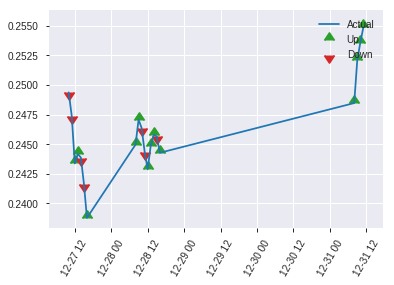


ModelMetricsBinomialGLM: glm
** Reported on test data. **

MSE: 0.21227467359086988
RMSE: 0.46073275723663265
LogLoss: 0.6105667346420208
Null degrees of freedom: 222
Residual degrees of freedom: 151
Null deviance: 308.2619463225164
Residual deviance: 272.31276365034137
AIC: 416.31276365034137
AUC: 0.7483839689722043
pr_auc: 0.7210046376824336
Gini: 0.49676793794440854
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.2333129985231207: 


0    1    Error    Rate
-----  ---  ---  -------  ------------
0      38   81   0.6807   (81.0/119.0)
1      5    99   0.0481   (5.0/104.0)
Total  43   180  0.3857   (86.0/223.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.233313     0.697183  179
max f2                       0.212047     0.836093  187
max f0point5                 0.4487       0.714286  78
max accuracy                 0.4487       0.717489  78
max precision                0.831379     1         0
max recall                   0.0879629    1         216
max specificity              0.831379     1         0
max absolute_mcc             0.4487       0.435212  78
max min_per_class_accuracy   0.4114       0.653846  95
max mean_per_class_accuracy  0.434927     0.709842  82

Gains/Lift Table: Avg response rate: 46.64 %, avg score: 37.88 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0134529                   0.717207           2.14423   2.14423            1                0.771158  1                           0.771158            0.0288462       0.0288462                  114.423   114.423
    2        0.0224215                   0.702189           2.14423   2.14423            1                0.704592  1                           0.744531            0.0192308       0.0480769                  114.423   114.423
    3        0.0313901                   0.697883           2.14423   2.14423            1                0.699666  1                           0.731713            0.0192308       0.0673077                  114.423   114.423
    4        0.0403587                   0.69135            2.14423   2.14423            1                0.697395  1                           0.724086            0.0192308       0.0865385                  114.423   114.423
    5        0.0538117                   0.666821           1.42949   1.96554            0.666667         0.677146  0.916667                    0.712351            0.0192308       0.105769                   42.9487   96.5545
    6        0.103139                    0.59695            1.55944   1.77132            0.727273         0.627596  0.826087                    0.671816            0.0769231       0.182692                   55.9441   77.1321
    7        0.152466                    0.548841           1.75437   1.76584            0.818182         0.574222  0.823529                    0.640242            0.0865385       0.269231                   75.4371   76.5837
    8        0.201794                    0.509071           1.16958   1.62009            0.545455         0.523545  0.755556                    0.611716            0.0576923       0.326923                   16.958    62.0085
    9        0.300448                    0.45908            1.65691   1.63218            0.772727         0.482045  0.761194                    0.569137            0.163462        0.490385                   65.6906   63.2176
    10       0.399103                    0.419346           1.16958   1.51783            0.545455         0.443577  0.707865                    0.5381              0.115385        0.605769                   16.958    51.7826
    11       0.502242                    0.375478           0.652592  1.34014            0.304348         0.399154  0.625                       0.509566            0.0673077       0.673077                   -34.7408  34.0144
    12       0.600897                    0.334639           0.58479   1.21613            0.272727         0.356159  0.567164                    0.48438             0.0576923       0.730769                   -41.521   21.6131
    13       0.699552                    0.29496            1.16958   1.20957            0.545455         0.315083  0.564103                    0.460505            0.115385        0.846154                   16.958    20.9566
    14       0.798206                    0.238783           0.97465   1.18053            0.454545         0.268031  0.550562                    0.436716            0.0961538       0.942308                   -2.53497  18.0532
    15       0.896861                    0.157025           0.292395  1.08284            0.136364         0.197504  0.505                       0.410403            0.0288462       0.971154                   -70.7605  8.28365
    16       1                           0.0448878          0.279682  1                  0.130435         0.104092  0.466368                    0.37881          

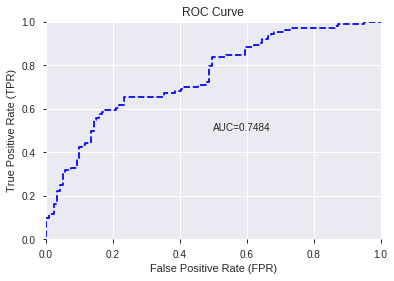

/usr/local/lib/python3.6/dist-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


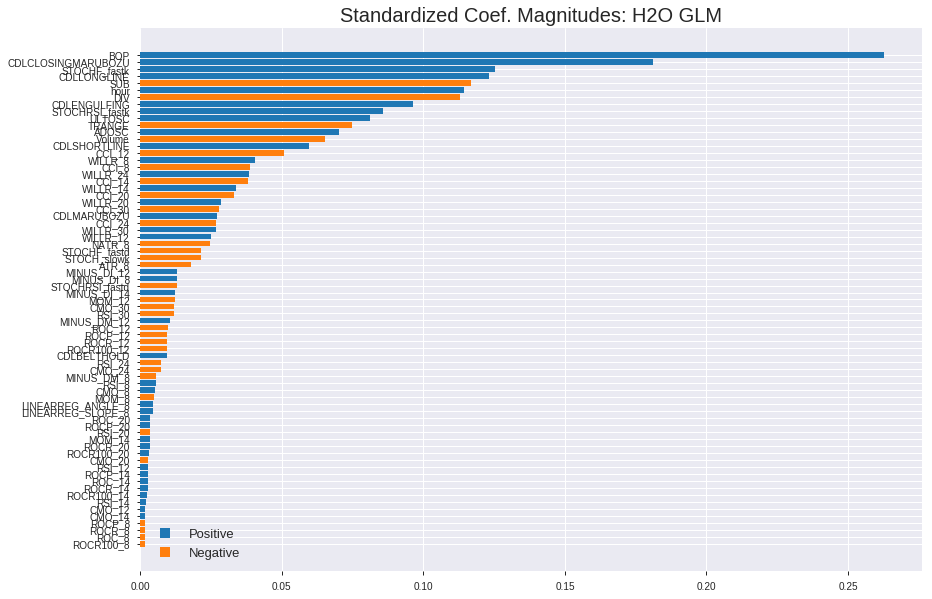

'log_likelihood'
--2019-08-27 21:33:58--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.165.179
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.165.179|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/GLM_grid_1_AutoML_20190827_213350_model_1',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'GLM_grid_1_AutoML_20190827_213350_model_1',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_82_sid_82c1',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training_py_82_s

['BOP',
 'CDLCLOSINGMARUBOZU',
 'STOCHF_fastk',
 'CDLLONGLINE',
 'SUB',
 'hour',
 'DIV',
 'CDLENGULFING',
 'STOCHRSI_fastk',
 'ULTOSC',
 'TRANGE',
 'ADOSC',
 'Volume',
 'CDLSHORTLINE',
 'CCI_12',
 'WILLR_8',
 'CCI_8',
 'WILLR_24',
 'CCI_14',
 'WILLR_14',
 'CCI_20',
 'WILLR_20',
 'CCI_30',
 'CDLMARUBOZU',
 'CCI_24',
 'WILLR_30',
 'WILLR_12',
 'NATR_8',
 'STOCHF_fastd',
 'STOCH_slowk',
 'ATR_8',
 'MINUS_DI_12',
 'MINUS_DI_8',
 'STOCHRSI_fastd',
 'MINUS_DI_14',
 'MOM_12',
 'CMO_30',
 'RSI_30',
 'MINUS_DM_12',
 'ROC_12',
 'ROCP_12',
 'ROCR_12',
 'ROCR100_12',
 'CDLBELTHOLD',
 'RSI_24',
 'CMO_24',
 'MINUS_DM_8',
 'RSI_8',
 'CMO_8',
 'MOM_8',
 'LINEARREG_ANGLE_8',
 'LINEARREG_SLOPE_8',
 'ROC_20',
 'ROCP_20',
 'RSI_20',
 'MOM_14',
 'ROCR_20',
 'ROCR100_20',
 'CMO_20',
 'RSI_12',
 'ROCP_14',
 'ROC_14',
 'ROCR_14',
 'ROCR100_14',
 'RSI_14',
 'CMO_12',
 'CMO_14',
 'ROCP_8',
 'ROCR_8',
 'ROC_8',
 'ROCR100_8']

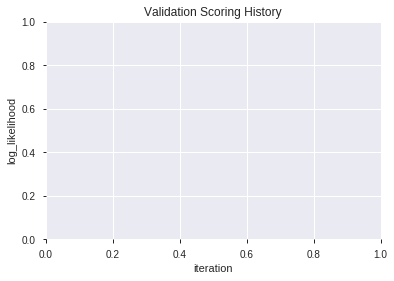

In [48]:
# GLM with Select Family-wise error features
model_train(feature_name='Fwe',model_algo="GLM",features_list=features_list)

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  XGBoost_grid_1_AutoML_20190827_213406_model_2  0.770928  0.594362              0.302036  0.451822  0.204143
1  XGBoost_grid_1_AutoML_20190827_213406_model_4  0.768827  0.594678              0.276867  0.451649  0.203987
2               XGBoost_2_AutoML_20190827_213406  0.758888  0.596417              0.277473  0.452122  0.204414
3  XGBoost_grid_1_AutoML_20190827_213406_model_7  0.755899  0.594745              0.376980  0.452387  0.204654
4  XGBoost_grid_1_AutoML_20190827_213406_model_6  0.750808  0.599587              0.322439  0.455434  0.207421
5               XGBoost_1_AutoML_20190827_213406  0.750485  0.600109              0.287088  0.454489  0.206561
6  XGBoost_grid_1_AutoML_20190827_213406_model_1  0.748222  0.610128              0.299653  0.459408  0.211056
7  XGBoost_grid_1_AutoML_20190827_213406_model_3  0.747172  0.596323              0.372778  0.454516  0.206585
8               XGBoost_3_AutoML_20190827_213406  0.740869  0.611998              0.370394  0.461277  0.212776
9  XGBoost_grid_1_AutoML_20190827_213406_model_5  0.737557  0.632996              0.351770  0.468014  0.219037

variable  relative_importance  scaled_importance  percentage
0                  BOP          1972.367798           1.000000    0.257788
1                  DIV           662.983215           0.336136    0.086652
2               TRANGE           436.926270           0.221524    0.057106
3         STOCHF_fastk           414.517456           0.210162    0.054177
4                 hour           353.075226           0.179011    0.046147
5               Volume           250.087143           0.126795    0.032686
6               ULTOSC           182.214172           0.092383    0.023815
7   CDLCLOSINGMARUBOZU           169.775040           0.086077    0.022190
8               ROC_20           165.634033           0.083977    0.021648
9                  SUB           161.174042           0.081716    0.021065
10   LINEARREG_ANGLE_8           151.909500           0.077019    0.019855
11               CCI_8           151.286575           0.076703    0.019773
12             WILLR_8           145.241699           0.073638    0.018983
13      STOCHRSI_fastk           144.114395           0.073067    0.018836
14               ADOSC           142.513840           0.072255    0.018627
15              CCI_12           133.328888           0.067598    0.017426
16      STOCHRSI_fastd           109.166603           0.055348    0.014268
17         MINUS_DM_12           104.131462           0.052795    0.013610
18              CCI_14            97.523407           0.049445    0.012746
19              CCI_24            89.541405           0.045398    0.011703
20              NATR_8            89.510902           0.045382    0.011699
21         MINUS_DI_14            88.422447           0.044831    0.011557
22               ATR_8            82.457077           0.041806    0.010777
23              CMO_30            82.333740           0.041744    0.010761
24          MINUS_DM_8            79.966530           0.040543    0.010452
25               MOM_8            73.070236           0.037047    0.009550
26              CCI_30            70.953239           0.035974    0.009274
27         STOCH_slowk            70.450340           0.035719    0.009208
28         MINUS_DI_12            69.122375           0.035045    0.009034
29               ROC_8            66.903854           0.033921    0.008744
30            WILLR_20            65.269485           0.033092    0.008531
31              CCI_20            61.593811           0.031228    0.008050
32              CMO_20            61.068668           0.030962    0.007982
33              MOM_14            60.242916           0.030543    0.007874
34            WILLR_24            58.419018           0.029619    0.007635
35            WILLR_30            50.513546           0.025611    0.006602
36              ROC_14            50.254837           0.025479    0.006568
37          MINUS_DI_8            45.725891           0.023183    0.005976
38            WILLR_12            43.289028           0.021948    0.005658
39            WILLR_14            42.359310           0.021476    0.005536
40              MOM_12            40.481487           0.020524    0.005291
41              CMO_24            35.640301           0.018070    0.004658
42              ROC_12            34.257534           0.017369    0.004477
43        CDLSHORTLINE            26.285748           0.013327    0.003436
44              CMO_12            25.861027           0.013112    0.003380
45   LINEARREG_SLOPE_8            25.011646           0.012681    0.003269
46              CMO_14            22.377361           0.011345    0.002925
47               CMO_8            17.978188           0.009115    0.002350
48         CDLLONGLINE            14.677395           0.007442    0.001918
49        CDLENGULFING            12.238382           0.006205    0.001600
50         CDLBELTHOLD            11.406818           0.005783    0.001491
51             ROCP_20            10.009044           0.005075    0.001308
52              RSI_30             6.71

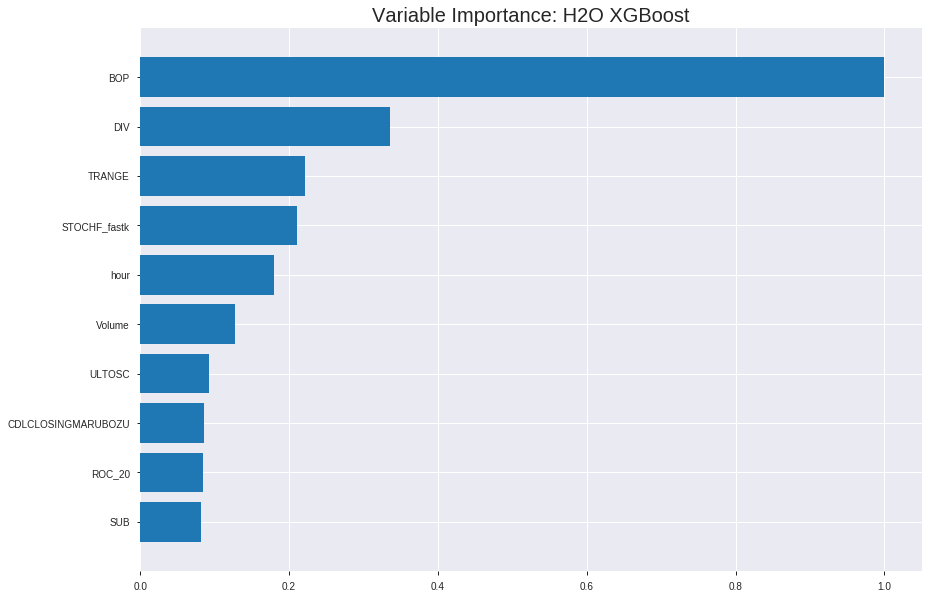

Model Details
H2OXGBoostEstimator :  XGBoost
Model Key:  XGBoost_grid_1_AutoML_20190827_213406_model_2


ModelMetricsBinomial: xgboost
** Reported on train data. **

MSE: 0.15055452362574437
RMSE: 0.3880135611363917
LogLoss: 0.4729730487357651
Mean Per-Class Error: 0.18675473579262214
AUC: 0.888787803256896
pr_auc: 0.8751869409858906
Gini: 0.777575606513792
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.49675533175468445: 


0    1    Error    Rate
-----  ---  ---  -------  --------------
0      709  141  0.1659   (141.0/850.0)
1      147  561  0.2076   (147.0/708.0)
Total  856  702  0.1849   (288.0/1558.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.496755     0.795745  188
max f2                       0.267345     0.857714  307
max f0point5                 0.543084     0.814873  164
max accuracy                 0.496755     0.815148  188
max precision                0.884543     1         0
max recall                   0.193399     1         348
max specificity              0.884543     1         0
max absolute_mcc             0.496755     0.626953  188
max min_per_class_accuracy   0.478544     0.804706  198
max mean_per_class_accuracy  0.496755     0.813245  188

Gains/Lift Table: Avg response rate: 45.44 %, avg score: 45.62 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0102696                   0.852528           2.20056   2.20056            1                0.866649  1                           0.866649            0.0225989       0.0225989                  120.056   120.056
    2        0.0205392                   0.835606           2.20056   2.20056            1                0.84328   1                           0.854965            0.0225989       0.0451977                  120.056   120.056
    3        0.0301669                   0.825386           2.20056   2.20056            1                0.829251  1                           0.846758            0.0211864       0.0663842                  120.056   120.056
    4        0.0404365                   0.805623           2.20056   2.20056            1                0.814823  1                           0.838648            0.0225989       0.0889831                  120.056   120.056
    5        0.0500642                   0.794337           2.20056   2.20056            1                0.798632  1                           0.830952            0.0211864       0.110169                   120.056   120.056
    6        0.100128                    0.748162           2.11593   2.15825            0.961538         0.769439  0.980769                    0.800196            0.105932        0.216102                   111.593   115.825
    7        0.150193                    0.710218           2.00308   2.10652            0.910256         0.728637  0.957265                    0.776343            0.100282        0.316384                   100.308   110.652
    8        0.200257                    0.670088           2.03129   2.08772            0.923077         0.691134  0.948718                    0.755041            0.101695        0.418079                   103.129   108.772
    9        0.300385                    0.606968           1.67864   1.95136            0.762821         0.638306  0.886752                    0.716129            0.168079        0.586158                   67.8636   95.1356
    10       0.399872                    0.537421           1.47651   1.83322            0.670968         0.571639  0.833066                    0.68018             0.146893        0.733051                   47.6508   83.3215
    11       0.5                         0.455834           0.902796  1.64689            0.410256         0.495155  0.748395                    0.643128            0.0903955       0.823446                   -9.72041  64.6893
    12       0.600128                    0.377369           0.719415  1.49215            0.326923         0.415967  0.678075                    0.605227            0.0720339       0.89548                    -28.0585  49.2148
    13       0.699615                    0.302239           0.511099  1.35264            0.232258         0.34004   0.614679                    0.567517            0.0508475       0.946328                   -48.8901  35.2641
    14       0.799743                    0.229493           0.380867  1.23097            0.173077         0.266655  0.55939                     0.529849            0.0381356       0.984463                   -61.9133  23.0974
    15       0.899872                    0.160481           0.155168  1.11127            0.0705128        0.196209  0.504993                    0.492725            0.0155367       1                          -84.4832  11.127
    16       1                           0.0919315          0         1                  0                0.128196  0.454429                    0.456225          



ModelMetricsBinomial: xgboost
** Reported on validation data. **

MSE: 0.2010223018743569
RMSE: 0.4483551068900151
LogLoss: 0.5857238751657056
Mean Per-Class Error: 0.25860177925823624
AUC: 0.7844375837835642
pr_auc: 0.714935535888348
Gini: 0.5688751675671284
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.29896673560142517: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      141  98   0.41     (98.0/239.0)
1      27   179  0.1311   (27.0/206.0)
Total  168  277  0.2809   (125.0/445.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.298967     0.741201  248
max f2                       0.253955     0.837004  278
max f0point5                 0.41063      0.725646  182
max accuracy                 0.41063      0.74382   182
max precision                0.845311     1         0
max recall                   0.0992857    1         396
max specificity              0.845311     1         0
max absolute_mcc             0.41063      0.483948  182
max min_per_class_accuracy   0.390746     0.732218  194
max mean_per_class_accuracy  0.41063      0.741398  182

Gains/Lift Table: Avg response rate: 46.29 %, avg score: 38.18 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.011236                    0.751176           1.72816   1.72816            0.8              0.803607  0.8                         0.803607            0.0194175       0.0194175                  72.8155   72.8155
    2        0.0202247                   0.728323           2.16019   1.92017            1                0.743828  0.888889                    0.777039            0.0194175       0.038835                   116.019   92.0173
    3        0.0314607                   0.713047           1.72816   1.8516             0.8              0.721308  0.857143                    0.757135            0.0194175       0.0582524                  72.8155   85.1595
    4        0.0404494                   0.699311           2.16019   1.92017            1                0.705028  0.888889                    0.745556            0.0194175       0.0776699                  116.019   92.0173
    5        0.0516854                   0.681814           1.29612   1.78451            0.6              0.691254  0.826087                    0.733751            0.0145631       0.092233                   29.6117   78.4508
    6        0.101124                    0.630836           1.37467   1.58414            0.636364         0.653677  0.733333                    0.694604            0.0679612       0.160194                   37.4669   58.4142
    7        0.150562                    0.585535           1.86562   1.67657            0.863636         0.602438  0.776119                    0.664341            0.092233        0.252427                   86.5622   67.6569
    8        0.2                         0.545455           1.37467   1.60194            0.636364         0.562124  0.741573                    0.639074            0.0679612       0.320388                   37.4669   60.1942
    9        0.301124                    0.488532           1.63215   1.61209            0.755556         0.517303  0.746269                    0.598181            0.165049        0.485437                   63.2147   61.2085
    10       0.4                         0.43893            1.27648   1.52913            0.590909         0.461495  0.707865                    0.564393            0.126214        0.61165                    27.6478   52.9126
    11       0.501124                    0.386341           1.34412   1.49179            0.622222         0.40823   0.690583                    0.53288             0.135922        0.747573                   34.4121   49.1793
    12       0.6                         0.310384           0.883716  1.39159            0.409091         0.348457  0.644195                    0.502488            0.0873786       0.834951                   -11.6284  39.1586
    13       0.698876                    0.253272           0.883716  1.31973            0.409091         0.282765  0.610932                    0.471402            0.0873786       0.92233                    -11.6284  31.9733
    14       0.8                         0.203514           0.192017  1.17718            0.0888889        0.226603  0.544944                    0.440458            0.0194175       0.941748                   -80.7983  17.7184
    15       0.898876                    0.148298           0.343667  1.0855             0.159091         0.174588  0.5025                      0.411213            0.0339806       0.975728                   -65.6333  8.54976
    16       1                           0.0943633          0.240022  1                  0.111111         0.119974  0.462921                    0.381762         


Scoring History: 


timestamp            duration    number_of_trees    training_rmse    training_logloss    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------  -----------------  ---------------  ------------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-08-27 21:34:12  0.941 sec   0                  0.5              0.693147            0.5             0                  1                0.545571                         0.5                0.693147              0.5               0                    1                  0.537079
    2019-08-27 21:34:12  1.095 sec   5                  0.477443         0.648856            0.809047        0.584505           1.84645          0.248395                         0.481532           0.656719              0.773165          0.665723             1.72816            0.269663
    2019-08-27 21:34:12  1.183 sec   10                 0.461101         0.617401            0.828551        0.780461           2.20056          0.240051                         0.47077            0.635567              0.78              0.700568             1.72816            0.274157
    2019-08-27 21:34:13  1.255 sec   15                 0.44797          0.592111            0.831831        0.78397            2.20056          0.242619                         0.463662           0.621161              0.784092          0.704015             1.72816            0.265169
    2019-08-27 21:34:13  1.331 sec   20                 0.437807         0.572255            0.837792        0.791354           2.20056          0.245186                         0.457306           0.608119              0.784895          0.713661             2.16019            0.260674
    2019-08-27 21:34:13  1.405 sec   25                 0.429443         0.555806            0.844223        0.820409           2.20056          0.231707                         0.453685           0.600303              0.786489          0.717353             2.16019            0.260674
    2019-08-27 21:34:13  1.484 sec   30                 0.422906         0.542847            0.850193        0.829937           2.20056          0.228498                         0.452              0.596369              0.786012          0.711781             1.72816            0.262921
    2019-08-27 21:34:13  1.562 sec   35                 0.416453         0.529809            0.856009        0.835993           2.20056          0.212452                         0.450374           0.592457              0.78787           0.715116             1.72816            0.253933
    2019-08-27 21:34:13  1.640 sec   40                 0.410943         0.518761            0.86241         0.842773           2.20056          0.203466                         0.449493           0.589952              0.786844          0.711158             1.72816            0.276404
    2019-08-27 21:34:13  1.727 sec   45                 0.405647         0.508032            0.867709        0.847225           2.20056          0.216303                         0.449012           0.588271              0.784874          0.71213              1.72816            0.280899
    2019-08-27 21:34:13  1.807 sec   50                 0.400896         0.498387            0.872966        0.85763            2.20056          0.197689                         0.448242           0.586224              0.785108          0.714367             1.72816            0.278652
    2019-08-27 21:34:13  1.889 sec   55                 0.396148         0.488958            0.879079        0.862043           2.20056          0.189987                         0.44716            0.583861              0.78593           0

Variable Importances: 


variable      relative_importance    scaled_importance      percentage
------------  ---------------------  ---------------------  ----------------------
BOP           1972.3677978515625     1.0                    0.257787722181442
DIV           662.9832153320312      0.33613569236640234    0.08665165447901678
TRANGE        436.92626953125        0.2215237289957684     0.05710609750695819
STOCHF_fastk  414.5174560546875      0.21016235232911842    0.054177274095217116
hour          353.0752258300781      0.17901084484074       0.04614679793726991
---           ---                    ---                    ---
RSI_20        4.228523254394531      0.0021438817136441423  0.00055266638358677
ROCR_14       2.8554396629333496     0.0014477217008124395  0.00037320487960508183
STOCHF_fastd  2.3854870796203613     0.0012094534712130246  0.00031178225542844384
RSI_8         2.131875991821289      0.0010808714247634106  0.0002786353825607695
ROCP_12       1.521926999092102      0.0007716243394106762  0.00019891528083643812


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.7174887892376681)

('F1', 0.7088607594936708)

('auc', 0.7709276018099548)

('logloss', 0.5943624684193766)

('mean_per_class_error', 0.28834033613445376)

('rmse', 0.45182224051894926)

('mse', 0.2041433370275632)

xgboost prediction progress: |████████████████████████████████████████████| 100%


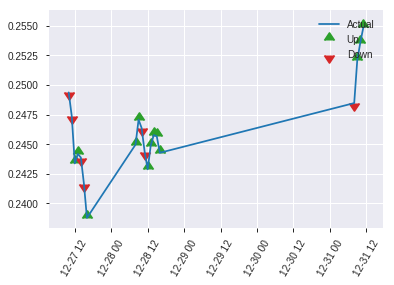


ModelMetricsBinomial: xgboost
** Reported on test data. **

MSE: 0.2041433370275632
RMSE: 0.45182224051894926
LogLoss: 0.5943624684193766
Mean Per-Class Error: 0.28834033613445376
AUC: 0.7709276018099548
pr_auc: 0.7412893264355164
Gini: 0.5418552036199096
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.35693100094795227: 


0    1    Error    Rate
-----  ---  ---  -------  ------------
0      70   49   0.4118   (49.0/119.0)
1      20   84   0.1923   (20.0/104.0)
Total  90   133  0.3094   (69.0/223.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.356931     0.708861  132
max f2                       0.169525     0.836039  199
max f0point5                 0.53257      0.714286  50
max accuracy                 0.45035      0.717489  84
max precision                0.765397     1         0
max recall                   0.11987      1         214
max specificity              0.765397     1         0
max absolute_mcc             0.53257      0.432658  50
max min_per_class_accuracy   0.408657     0.689076  108
max mean_per_class_accuracy  0.445461     0.71166   88

Gains/Lift Table: Avg response rate: 46.64 %, avg score: 39.69 %



group    cumulative_data_fraction    lower_threshold    lift       cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  ---------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0134529                   0.731908           2.14423    2.14423            1                0.74355   1                           0.74355             0.0288462       0.0288462                  114.423   114.423
    2        0.0224215                   0.72386            2.14423    2.14423            1                0.729387  1                           0.737885            0.0192308       0.0480769                  114.423   114.423
    3        0.0313901                   0.712571           1.07212    1.83791            0.5              0.71631   0.857143                    0.731721            0.00961538      0.0576923                  7.21154   83.7912
    4        0.0403587                   0.702993           2.14423    1.90598            1                0.71117   0.888889                    0.727154            0.0192308       0.0769231                  114.423   90.5983
    5        0.0538117                   0.682796           2.14423    1.96554            1                0.69562   0.916667                    0.71927             0.0288462       0.105769                   114.423   96.5545
    6        0.103139                    0.612904           1.75437    1.86455            0.818182         0.640565  0.869565                    0.681629            0.0865385       0.192308                   75.4371   86.4548
    7        0.152466                    0.573379           1.55944    1.76584            0.727273         0.589971  0.823529                    0.651975            0.0769231       0.269231                   55.9441   76.5837
    8        0.201794                    0.548098           1.9493     1.81068            0.909091         0.56231   0.844444                    0.630057            0.0961538       0.365385                   94.9301   81.0684
    9        0.300448                    0.493938           1.07212    1.56817            0.5              0.520886  0.731343                    0.59421             0.105769        0.471154                   7.21154   56.8169
    10       0.399103                    0.445057           1.55944    1.56601            0.727273         0.465118  0.730337                    0.562299            0.153846        0.625                      55.9441   56.6011
    11       0.502242                    0.405005           0.839047   1.41672            0.391304         0.423131  0.660714                    0.53372             0.0865385       0.711538                   -16.0953  41.6724
    12       0.600897                    0.353272           0.97465    1.34414            0.454545         0.375794  0.626866                    0.507792            0.0961538       0.807692                   -2.53497  34.4145
    13       0.699552                    0.308929           0.682255   1.2508             0.318182         0.332332  0.583333                    0.483048            0.0673077       0.875                      -31.7745  25.0801
    14       0.798206                    0.223401           0.58479    1.16849            0.272727         0.269226  0.544944                    0.45662             0.0576923       0.932692                   -41.521   16.8485
    15       0.896861                    0.168545           0.58479    1.10428            0.272727         0.189885  0.515                       0.427279            0.0576923       0.990385                   -41.521   10.4279
    16       1                           0.095092           0.0932274  1                  0.0434783        0.132925  0.466368                   

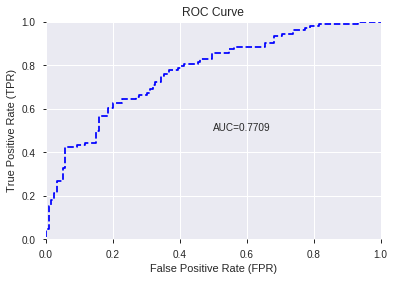

This function is available for GLM models only


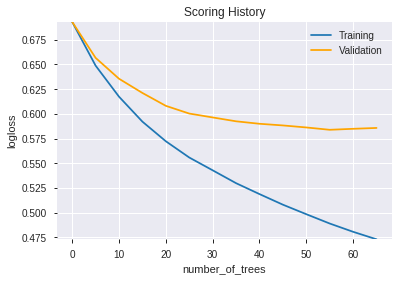

--2019-08-27 21:34:29--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 54.231.120.139
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|54.231.120.139|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
Exception in thread "main" java.lang.StackOverflowError
	at java.base/java.lang.String.substring(String.java:1874)
	at java.base/java.lang.String.split(String.java:2289)
	at java.base/java.lang.String.split(String.java:2364)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:101)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:106)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:106)
	at hex.genmodel.algos.xgboost.XGBoostMojoMo

[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/XGBoost_grid_1_AutoML_20190827_213406_model_2',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'XGBoost_grid_1_AutoML_20190827_213406_model_2',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_90_sid_82c1',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training

['BOP',
 'DIV',
 'TRANGE',
 'STOCHF_fastk',
 'hour',
 'Volume',
 'ULTOSC',
 'CDLCLOSINGMARUBOZU',
 'ROC_20',
 'SUB',
 'LINEARREG_ANGLE_8',
 'CCI_8',
 'WILLR_8',
 'STOCHRSI_fastk',
 'ADOSC',
 'CCI_12',
 'STOCHRSI_fastd',
 'MINUS_DM_12',
 'CCI_14',
 'CCI_24',
 'NATR_8',
 'MINUS_DI_14',
 'ATR_8',
 'CMO_30',
 'MINUS_DM_8',
 'MOM_8',
 'CCI_30',
 'STOCH_slowk',
 'MINUS_DI_12',
 'ROC_8',
 'WILLR_20',
 'CCI_20',
 'CMO_20',
 'MOM_14',
 'WILLR_24',
 'WILLR_30',
 'ROC_14',
 'MINUS_DI_8',
 'WILLR_12',
 'WILLR_14',
 'MOM_12',
 'CMO_24',
 'ROC_12',
 'CDLSHORTLINE',
 'CMO_12',
 'LINEARREG_SLOPE_8',
 'CMO_14',
 'CMO_8',
 'CDLLONGLINE',
 'CDLENGULFING',
 'CDLBELTHOLD',
 'ROCP_20',
 'RSI_30',
 'RSI_24',
 'RSI_20',
 'ROCR_14',
 'STOCHF_fastd',
 'RSI_8',
 'ROCP_12']

In [49]:
# XGBoost with Select Family-wise error features
model_train(feature_name='Fwe',model_algo="XGBoost",features_list=features_list)

In [50]:
# recursive feature elimination with cross validation
try:
  del features_list
except:
  pass
gc.collect()

if features_to_include is True or 'RFE' in features_to_include:
  from sklearn.feature_selection import RFECV
  from sklearn.svm import LinearSVC
  from sklearn.tree import DecisionTreeClassifier,ExtraTreeClassifier
  from sklearn.linear_model import LogisticRegression, LinearRegression

  bestfeatures = RFECV(ExtraTreeClassifier(random_state=1,criterion='entropy'), min_features_to_select=select_rfe, step=1,cv=5).fit(pd.read_pickle('scaled_df')[:index_splits[0]].drop(data_label_name,axis=1)
                                                              ,pd.read_pickle('scaled_df')[:index_splits[0]][data_label_name])

  features_list = list(np.array(train_hf.columns)[:-1][bestfeatures.get_support()])

  del bestfeatures, RFECV, LinearSVC, DecisionTreeClassifier,ExtraTreeClassifier, LogisticRegression, LinearRegression
  gc.collect()
  display(len(features_list),features_list)
else:
  features_list = []

262

['BBANDS_middleband_14_6_5',
 'BBANDS_lowerband_14_6_5',
 'MA_14_7',
 'MAVP_14_7',
 'BBANDS_upperband_14_7_2',
 'BBANDS_middleband_14_7_2',
 'BBANDS_lowerband_14_7_2',
 'BBANDS_upperband_14_7_3',
 'BBANDS_middleband_14_7_3',
 'BBANDS_lowerband_14_7_3',
 'BBANDS_upperband_14_7_4',
 'BBANDS_middleband_14_7_4',
 'BBANDS_upperband_14_7_5',
 'BBANDS_middleband_14_7_5',
 'BBANDS_lowerband_14_7_5',
 'DEMA_20',
 'EMA_20',
 'KAMA_20',
 'MIDPOINT_20',
 'MIDPRICE_20',
 'SMA_20',
 'MAVP_20_0',
 'BBANDS_upperband_20_0_2',
 'BBANDS_upperband_20_0_3',
 'BBANDS_lowerband_20_0_3',
 'BBANDS_middleband_20_0_5',
 'BBANDS_lowerband_20_0_5',
 'MA_20_1',
 'BBANDS_lowerband_20_1_3',
 'BBANDS_lowerband_20_1_4',
 'MA_20_2',
 'MAVP_20_2',
 'BBANDS_middleband_20_2_2',
 'BBANDS_lowerband_20_2_2',
 'BBANDS_middleband_20_2_4',
 'BBANDS_lowerband_20_2_4',
 'BBANDS_upperband_20_2_5',
 'BBANDS_lowerband_20_2_5',
 'MA_20_3',
 'BBANDS_upperband_20_3_2',
 'BBANDS_lowerband_20_3_2',
 'BBANDS_upperband_20_3_3',
 'BBANDS_low

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  DeepLearning_grid_1_AutoML_20190827_213558_model_8  0.702004  0.646279              0.388413  0.477532  0.228037
1  DeepLearning_grid_1_AutoML_20190827_213558_model_6  0.696105  0.649004              0.394392  0.474182  0.224849
2  DeepLearning_grid_1_AutoML_20190827_213558_model_2  0.695701  0.909828              0.383605  0.524608  0.275214
3  DeepLearning_grid_1_AutoML_20190827_213558_model_9  0.695459  0.644706              0.399200  0.475551  0.226148
4  DeepLearning_grid_1_AutoML_20190827_213558_model_3  0.682854  0.799352              0.408209  0.510059  0.260160
5  DeepLearning_grid_1_AutoML_20190827_213558_model_7  0.660633  0.829255              0.410027  0.516719  0.266999
6  DeepLearning_grid_1_AutoML_20190827_213558_model_5  0.657240  0.651129              0.439399  0.480250  0.230640
7  DeepLearning_grid_1_AutoML_20190827_213558_model_4  0.645443  1.441318              0.452004  0.624412  0.389890
8  DeepLearning_grid_1_AutoML_20190827_213558_model_1  0.627747  1.593305              0.432814  0.600015  0.360019
9               DeepLearning_1_AutoML_20190827_213558  0.613607  1.328117              0.402796  0.620046  0.384456

variable  relative_importance  scaled_importance  percentage
0                      TRANGE             1.000000           1.000000    0.012057
1                         BOP             0.985507           0.985507    0.011882
2          CDLCLOSINGMARUBOZU             0.762428           0.762428    0.009193
3                 CDLLONGLINE             0.608060           0.608060    0.007331
4                CDLENGULFING             0.513151           0.513151    0.006187
..                        ...                  ...                ...         ...
256            CDLMORNINGSTAR             0.259977           0.259977    0.003135
257  BBANDS_middleband_30_5_5             0.259345           0.259345    0.003127
258   BBANDS_upperband_14_7_4             0.258902           0.258902    0.003122
259    LINEARREG_INTERCEPT_12             0.257251           0.257251    0.003102
260  BBANDS_middleband_24_7_2             0.255083           0.255083    0.003076

[261 rows x 4 columns]

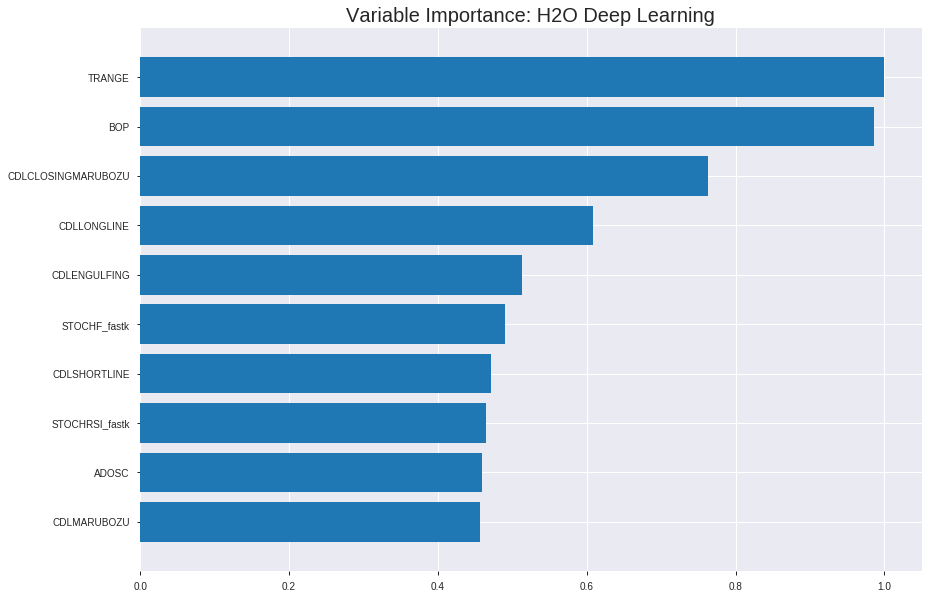

Model Details
H2ODeepLearningEstimator :  Deep Learning
Model Key:  DeepLearning_grid_1_AutoML_20190827_213558_model_8


ModelMetricsBinomial: deeplearning
** Reported on train data. **

MSE: 0.20494941660443913
RMSE: 0.4527133934449467
LogLoss: 0.5911926615475936
Mean Per-Class Error: 0.31651213027583913
AUC: 0.7442414423396477
pr_auc: 0.6874164234835948
Gini: 0.48848288467929546
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.3607562125833429: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      391  459   0.54     (459.0/850.0)
1      71   637   0.1003   (71.0/708.0)
Total  462  1096  0.3402   (530.0/1558.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.360756     0.706208  239
max f2                       0.261996     0.835974  291
max f0point5                 0.431535     0.638782  193
max accuracy                 0.431535     0.673941  193
max precision                0.790804     1         0
max recall                   0.0425006    1         382
max specificity              0.790804     1         0
max absolute_mcc             0.360756     0.392158  239
max min_per_class_accuracy   0.449584     0.666667  176
max mean_per_class_accuracy  0.408739     0.683488  209

Gains/Lift Table: Avg response rate: 45.44 %, avg score: 41.39 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain       cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  ---------  -----------------
    1        0.0102696                   0.742836           2.20056   2.20056            1                0.767802   1                           0.767802            0.0225989       0.0225989                  120.056    120.056
    2        0.0205392                   0.716815           1.92549   2.06303            0.875            0.728364   0.9375                      0.748083            0.019774        0.0423729                  92.5494    106.303
    3        0.0301669                   0.703437           1.90716   2.01328            0.866667         0.710995   0.914894                    0.736246            0.0183616       0.0607345                  90.7156    101.328
    4        0.0404365                   0.679618           1.78796   1.95606            0.8125           0.69114    0.888889                    0.724791            0.0183616       0.079096                   78.7959    95.6058
    5        0.0500642                   0.657959           1.76045   1.91844            0.8              0.66476    0.871795                    0.713246            0.0169492       0.0960452                  76.0452    91.8441
    6        0.100128                    0.606597           1.66453   1.79149            0.75641          0.633331   0.814103                    0.673289            0.0833333       0.179379                   66.453     79.1486
    7        0.150193                    0.563651           1.49526   1.69274            0.679487         0.585771   0.769231                    0.644116            0.0748588       0.254237                   49.5256    69.2742
    8        0.200257                    0.535258           1.26956   1.58695            0.576923         0.548197   0.721154                    0.620136            0.0635593       0.317797                   26.9557    58.6946
    9        0.300385                    0.501608           1.15671   1.44353            0.525641         0.518182   0.655983                    0.586151            0.115819        0.433616                   15.6707    44.3533
    10       0.399872                    0.470624           1.33454   1.41642            0.606452         0.485449   0.64366                     0.561097            0.132768        0.566384                   33.4536    41.6415
    11       0.5                         0.445524           1.18492   1.37006            0.538462         0.457425   0.622593                    0.540336            0.118644        0.685028                   18.492     37.0056
    12       0.600128                    0.4163             1.11439   1.3274             0.50641          0.432486   0.603209                    0.522342            0.111582        0.79661                    11.4389    32.74
    13       0.699615                    0.362802           0.993804  1.27996            0.451613         0.393252   0.581651                    0.503985            0.0988701       0.89548                    -0.619646  27.9962
    14       0.799743                    0.278334           0.620672  1.19742            0.282051         0.32502    0.544141                    0.481578            0.0621469       0.957627                   -37.9328   19.7418
    15       0.899872                    0.142003           0.268018  1.094              0.121795         0.213618   0.497147                    0.451763            0.0268362       0.984463                   -73.1982   9.40041
    16       1                           4.90314e-05        0.155168  1                  0.0705128        0.0733666  0.454429    



ModelMetricsBinomial: deeplearning
** Reported on validation data. **

MSE: 0.21521728284364497
RMSE: 0.4639151677232002
LogLoss: 0.6183894275328576
Mean Per-Class Error: 0.29164804809684364
AUC: 0.7605313401308039
pr_auc: 0.691243532151556
Gini: 0.5210626802616078
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4979262213194331: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      121  118  0.4937   (118.0/239.0)
1      20   186  0.0971   (20.0/206.0)
Total  141  304  0.3101   (138.0/445.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.497926     0.729412  266
max f2                       0.482104     0.834783  286
max f0point5                 0.547613     0.678643  177
max accuracy                 0.547613     0.701124  177
max precision                0.804025     1         0
max recall                   0.162433     1         387
max specificity              0.804025     1         0
max absolute_mcc             0.497926     0.438541  266
max min_per_class_accuracy   0.540317     0.68932   191
max mean_per_class_accuracy  0.519259     0.708352  228

Gains/Lift Table: Avg response rate: 46.29 %, avg score: 51.52 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.011236                    0.772773           2.16019   2.16019            1                0.787108  1                           0.787108            0.0242718       0.0242718                  116.019   116.019
    2        0.0202247                   0.737873           1.0801    1.68015            0.5              0.760082  0.777778                    0.775097            0.00970874      0.0339806                  8.00971   68.0151
    3        0.0314607                   0.724046           1.29612   1.543              0.6              0.729972  0.714286                    0.758981            0.0145631       0.0485437                  29.6117   54.2996
    4        0.0404494                   0.707693           2.16019   1.68015            1                0.7209    0.777778                    0.750518            0.0194175       0.0679612                  116.019   68.0151
    5        0.0516854                   0.694494           1.72816   1.69059            0.8              0.700373  0.782609                    0.739617            0.0194175       0.0873786                  72.8155   69.0587
    6        0.101124                    0.657156           1.37467   1.53614            0.636364         0.67775   0.711111                    0.709371            0.0679612       0.15534                    37.4669   53.6138
    7        0.150562                    0.628768           1.76743   1.61209            0.818182         0.641374  0.746269                    0.687044            0.0873786       0.242718                   76.7432   61.2085
    8        0.2                         0.601712           1.37467   1.5534             0.636364         0.611845  0.719101                    0.668455            0.0679612       0.31068                    37.4669   55.3398
    9        0.301124                    0.574644           1.58414   1.56372            0.733333         0.587322  0.723881                    0.641209            0.160194        0.470874                   58.4142   56.3723
    10       0.4                         0.555137           1.27648   1.49272            0.590909         0.565127  0.691011                    0.622402            0.126214        0.597087                   27.6478   49.2718
    11       0.501124                    0.538871           1.00809   1.39492            0.466667         0.546715  0.64574                     0.607129            0.101942        0.699029                   0.809061  39.4924
    12       0.6                         0.515937           1.17829   1.35922            0.545455         0.527335  0.629213                    0.59398             0.116505        0.815534                   17.8288   35.9223
    13       0.698876                    0.493769           0.932811  1.29889            0.431818         0.505466  0.601286                    0.581457            0.092233        0.907767                   -6.71889  29.8895
    14       0.8                         0.454816           0.432039  1.18932            0.2              0.475221  0.550562                    0.568028            0.0436893       0.951456                   -56.7961  18.932
    15       0.898876                    0.315754           0.147286  1.0747             0.0681818        0.403264  0.4975                      0.549904            0.0145631       0.966019                   -85.2714  7.46966
    16       1                           8.57256e-05        0.33603   1                  0.155556         0.206503  0.462921                    0.515178          


Scoring History: 


timestamp            duration          training_speed    epochs    iterations    samples    training_rmse    training_logloss    training_r2    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_r2    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------------  ----------------  --------  ------------  ---------  ---------------  ------------------  -------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ---------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-08-27 21:44:45  0.000 sec                           0         0             0          nan              nan                 nan            nan             nan                nan              nan                              nan                nan                   nan              nan               nan                  nan                nan
    2019-08-27 21:44:47  1 min 55.961 sec  478 obs/sec       0.455071  1             709        0.529039         0.784028            -0.128908      0.606893        0.550108           1.65042          0.512837                         0.507236           0.732335              -0.0348425       0.61422           0.586714             1.72816            0.498876
    2019-08-27 21:45:00  2 min  9.096 sec  702 obs/sec       6.0276    13            9391       0.453916         0.59876             0.168938       0.77039         0.723573           2.06303          0.32991                          0.477859           0.646757              0.0815537        0.723078          0.672523             1.92017            0.359551
    2019-08-27 21:45:13  2 min 22.310 sec  770 obs/sec       12.4936   27            19465      0.452713         0.591193            0.173335       0.744241        0.687416           2.20056          0.34018                          0.463915           0.618389              0.134371         0.760531          0.691244             2.16019            0.310112
    2019-08-27 21:45:27  2 min 35.825 sec  805 obs/sec       19.4134   42            30246      0.428844         0.542232            0.25821        0.796747        0.764014           2.20056          0.318357                         0.518738           0.774466              -0.082309        0.70039           0.651851             1.72816            0.393258
    2019-08-27 21:45:39  2 min 48.546 sec  836 obs/sec       26.2856   57            40953      0.424568         0.531203            0.272929       0.80702         0.779627           2.20056          0.293967                         0.466006           0.623091              0.126551         0.737945          0.679248             1.72816            0.352809
    2019-08-27 21:45:53  3 min  1.729 sec  861 obs/sec       33.6784   73            52471      0.420366         0.522726            0.287248       0.82326         0.799885           2.20056          0.274711                         0.470054           0.62907               0.111308         0.743064          0.679027             2.16019            0.348315
    2019-08-27 21:45:54  3 min  3.040 sec  861 obs/sec       33.6784   73            52471      0.452713         0.591193            0.173335       0.744241        0.687416           2.20056          0.34018                          0.463915           0.618389              0.134371         0.760531          0.691244             2.16019            0.310112

Variable Importances: 


variable                  relative_importance    scaled_importance    percentage
------------------------  ---------------------  -------------------  ---------------------
TRANGE                    1.0                    1.0                  0.012057138712355229
BOP                       0.9855071306228638     0.9855071306228638   0.011882396175935051
CDLCLOSINGMARUBOZU        0.7624281048774719     0.7624281048774719   0.009192701418705799
CDLLONGLINE               0.6080604791641235     0.6080604791641235   0.007331469542783024
CDLENGULFING              0.5131512880325317     0.5131512880325317   0.006187136260231986
---                       ---                    ---                  ---
CDLMORNINGSTAR            0.25997698307037354    0.25997698307037354  0.0031345785468991205
BBANDS_middleband_30_5_5  0.25934529304504395    0.25934529304504395  0.0031269621726405105
BBANDS_upperband_14_7_4   0.25890183448791504    0.25890183448791504  0.003121615331304026
LINEARREG_INTERCEPT_12    0.2572510242462158     0.2572510242462158   0.0031017112832320824
BBANDS_middleband_24_7_2  0.2550829350948334     0.2550829350948334   0.0030755703315931116


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.6681614349775785)

('F1', 0.6738351254480286)

('auc', 0.7020038784744667)

('logloss', 0.6462787780364492)

('mean_per_class_error', 0.3381948933419522)

('rmse', 0.47753239220194077)

('mse', 0.2280371856021082)

deeplearning prediction progress: |███████████████████████████████████████| 100%


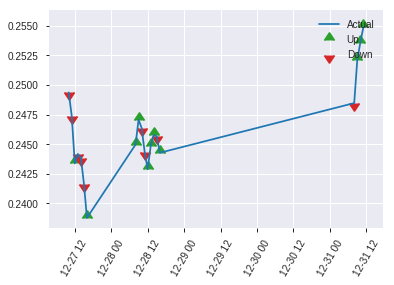


ModelMetricsBinomial: deeplearning
** Reported on test data. **

MSE: 0.2280371856021082
RMSE: 0.47753239220194077
LogLoss: 0.6462787780364492
Mean Per-Class Error: 0.3381948933419522
AUC: 0.7020038784744667
pr_auc: 0.7002312817322277
Gini: 0.4040077569489333
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.48950366767155146: 


0    1    Error    Rate
-----  ---  ---  -------  ------------
0      38   81   0.6807   (81.0/119.0)
1      10   94   0.0962   (10.0/104.0)
Total  48   175  0.4081   (91.0/223.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.489504     0.673835  174
max f2                       0.39824      0.828025  211
max f0point5                 0.607029     0.657051  51
max accuracy                 0.607029     0.668161  51
max precision                0.825219     1         0
max recall                   0.39824      1         211
max specificity              0.825219     1         0
max absolute_mcc             0.607029     0.356042  51
max min_per_class_accuracy   0.556651     0.634615  105
max mean_per_class_accuracy  0.571126     0.661805  87

Gains/Lift Table: Avg response rate: 46.64 %, avg score: 54.83 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0134529                   0.773663           2.14423   2.14423            1                0.797453  1                           0.797453            0.0288462       0.0288462                  114.423   114.423
    2        0.0224215                   0.740284           2.14423   2.14423            1                0.747769  1                           0.777579            0.0192308       0.0480769                  114.423   114.423
    3        0.0313901                   0.720616           2.14423   2.14423            1                0.730352  1                           0.764086            0.0192308       0.0673077                  114.423   114.423
    4        0.0403587                   0.715623           2.14423   2.14423            1                0.71776   1                           0.753791            0.0192308       0.0865385                  114.423   114.423
    5        0.0538117                   0.701541           2.14423   2.14423            1                0.711315  1                           0.743172            0.0288462       0.115385                   114.423   114.423
    6        0.103139                    0.665685           1.75437   1.95778            0.818182         0.676513  0.913043                    0.711292            0.0865385       0.201923                   75.4371   95.7776
    7        0.152466                    0.645444           1.16958   1.70277            0.545455         0.656365  0.794118                    0.693521            0.0576923       0.259615                   16.958    70.2771
    8        0.201794                    0.626468           1.75437   1.71538            0.818182         0.637132  0.8                         0.679737            0.0865385       0.346154                   75.4371   71.5385
    9        0.300448                    0.582096           0.97465   1.47216            0.454545         0.596189  0.686567                    0.652304            0.0961538       0.442308                   -2.53497  47.2158
    10       0.399103                    0.569672           1.26705   1.42146            0.590909         0.575699  0.662921                    0.633368            0.125           0.567308                   26.7045   42.1456
    11       0.502242                    0.551901           0.745819  1.28271            0.347826         0.55946   0.598214                    0.61819             0.0769231       0.644231                   -25.4181  28.2709
    12       0.600897                    0.53479            0.487325  1.15212            0.227273         0.543197  0.537313                    0.605878            0.0480769       0.692308                   -51.2675  15.2124
    13       0.699552                    0.518881           0.97465   1.1271             0.454545         0.527173  0.525641                    0.594779            0.0961538       0.788462                   -2.53497  12.7096
    14       0.798206                    0.48727            1.16958   1.13235            0.545455         0.502234  0.52809                     0.58334             0.115385        0.903846                   16.958    13.2347
    15       0.896861                    0.427548           0.487325  1.06139            0.227273         0.462277  0.495                       0.570023            0.0480769       0.951923                   -51.2675  6.13942
    16       1                           0.166481           0.466137  1                  0.217391         0.358974  0.466368                    0.548256         

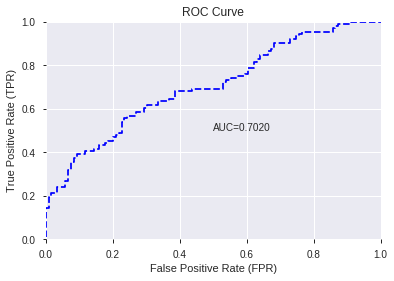

This function is available for GLM models only


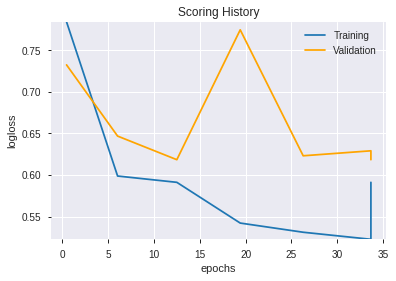

--2019-08-27 21:47:38--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.20.243
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.20.243|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/DeepLearning_grid_1_AutoML_20190827_213558_model_8',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'DeepLearning_grid_1_AutoML_20190827_213558_model_8',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_98_sid_82c1',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'autom

['TRANGE',
 'BOP',
 'CDLCLOSINGMARUBOZU',
 'CDLLONGLINE',
 'CDLENGULFING',
 'STOCHF_fastk',
 'CDLSHORTLINE',
 'STOCHRSI_fastk',
 'ADOSC',
 'CDLMARUBOZU',
 'PLUS_DM_8',
 'HT_PHASOR_quadrature',
 'CDLHAMMER',
 'aroonup_12',
 'CDLDOJI',
 'aroondown_14',
 'HT_TRENDMODE',
 'aroondown_8',
 'CORREL_12',
 'DX_8',
 'PLUS_DI_8',
 'AROONOSC_14',
 'CORREL_14',
 'WILLR_8',
 'CORREL_8',
 'BETA_8',
 'PLUS_DI_14',
 'STOCH_slowd',
 'aroondown_24',
 'CORREL_20',
 'STOCH_slowk',
 'ADXR_8',
 'BETA_12',
 'NATR_8',
 'PLUS_DI_12',
 'aroonup_24',
 'MFI_12',
 'MACDEXT_hist',
 'CCI_12',
 'aroondown_20',
 'aroondown_30',
 'WILLR_30',
 'BETA_14',
 'HT_DCPERIOD',
 'aroonup_20',
 'WILLR_24',
 'CDLSPINNINGTOP',
 'CCI_8',
 'VAR_8',
 'AROONOSC_20',
 'MFI_8',
 'MFI_24',
 'MACDFIX_hist_24',
 'ROCR_30',
 'HT_PHASOR_inphase',
 'DX_24',
 'CDLBELTHOLD',
 'PLUS_DM_12',
 'ADX_8',
 'BETA_20',
 'STDDEV_20',
 'DX_30',
 'MFI_14',
 'MINUS_DI_14',
 'ATR_8',
 'ADX_14',
 'PLUS_DM_14',
 'STOCHF_fastd',
 'MOM_8',
 'LINEARREG_ANGLE_12',

In [51]:
# DeepLearning with recursive feature elimination with cross validation
model_train(feature_name='RFE',model_algo="DeepLearning",features_list=features_list)

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  GLM_grid_1_AutoML_20190827_214747_model_1  0.716063  0.625497               0.39318  0.466978  0.218068

variable  relative_importance  scaled_importance  percentage
0                   BOP             0.286359           1.000000    0.057194
1                TRANGE             0.205933           0.719142    0.041131
2    CDLCLOSINGMARUBOZU             0.191894           0.670116    0.038327
3             CDLHAMMER             0.130460           0.455583    0.026057
4           CDLLONGLINE             0.128275           0.447951    0.025620
..                  ...                  ...                ...         ...
256        LINEARREG_20             0.000272           0.000951    0.000054
257        LINEARREG_12             0.000264           0.000922    0.000053
258           CDLHARAMI             0.000212           0.000740    0.000042
259             KAMA_20             0.000171           0.000598    0.000034
260              TSF_20             0.000087           0.000303    0.000017

[261 rows x 4 columns]

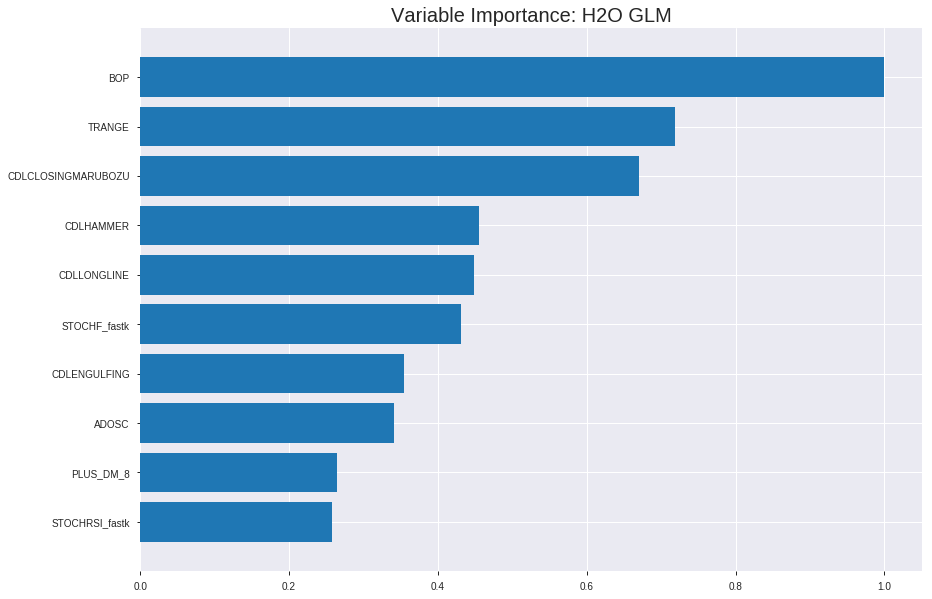

Model Details
H2OGeneralizedLinearEstimator :  Generalized Linear Modeling
Model Key:  GLM_grid_1_AutoML_20190827_214747_model_1


ModelMetricsBinomialGLM: glm
** Reported on train data. **

MSE: 0.19384251493652072
RMSE: 0.44027549890553835
LogLoss: 0.5700549540272151
Null degrees of freedom: 1557
Residual degrees of freedom: 1296
Null deviance: 2146.8864027643094
Residual deviance: 1776.291236748802
AIC: 2300.291236748802
AUC: 0.7770247590561647
pr_auc: 0.7328280761738296
Gini: 0.5540495181123295
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.3915044879481326: 


0    1    Error    Rate
-----  ---  ---  -------  --------------
0      489  361  0.4247   (361.0/850.0)
1      123  585  0.1737   (123.0/708.0)
Total  612  946  0.3107   (484.0/1558.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.391504     0.707376  236
max f2                       0.239505     0.824334  323
max f0point5                 0.518704     0.683901  160
max accuracy                 0.475657     0.708601  188
max precision                0.901319     1         0
max recall                   0.108005     1         382
max specificity              0.901319     1         0
max absolute_mcc             0.425553     0.416762  215
max min_per_class_accuracy   0.459331     0.7       198
max mean_per_class_accuracy  0.425553     0.708651  215

Gains/Lift Table: Avg response rate: 45.44 %, avg score: 45.44 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0102696                   0.871342           1.78796   1.78796            0.8125           0.882872  0.8125                      0.882872            0.0183616       0.0183616                  78.7959   78.7959
    2        0.0205392                   0.840984           2.06303   1.92549            0.9375           0.854064  0.875                       0.868468            0.0211864       0.039548                   106.303   92.5494
    3        0.0301669                   0.806739           1.90716   1.91964            0.866667         0.825522  0.87234                     0.854762            0.0183616       0.0579096                  90.7156   91.9642
    4        0.0404365                   0.787582           1.92549   1.92113            0.875            0.796022  0.873016                    0.839844            0.019774        0.0776836                  92.5494   92.1128
    5        0.0500642                   0.771451           2.05386   1.94665            0.933333         0.779562  0.884615                    0.828251            0.019774        0.0974576                  105.386   94.6654
    6        0.100128                    0.702173           1.97487   1.96076            0.897436         0.735488  0.891026                    0.78187             0.0988701       0.196328                   97.4866   96.076
    7        0.150193                    0.657911           1.63632   1.85261            0.74359          0.679381  0.84188                     0.747707            0.0819209       0.278249                   63.6318   85.2612
    8        0.200257                    0.626429           1.32598   1.72095            0.602564         0.641128  0.782051                    0.721062            0.0663842       0.344633                   32.5981   72.0955
    9        0.300385                    0.567676           1.43883   1.62691            0.653846         0.594109  0.739316                    0.678745            0.144068        0.488701                   43.8831   62.6913
    10       0.399872                    0.506192           1.24935   1.53298            0.567742         0.536301  0.696629                    0.643305            0.124294        0.612994                   24.9353   53.2978
    11       0.5                         0.447366           1.07207   1.44068            0.487179         0.477413  0.654685                    0.610084            0.107345        0.720339                   7.20701   44.0678
    12       0.600128                    0.394232           0.987433  1.36506            0.448718         0.420051  0.620321                    0.578378            0.0988701       0.819209                   -1.2567   36.5056
    13       0.699615                    0.351034           0.738254  1.27592            0.335484         0.373507  0.579817                    0.549245            0.0734463       0.892655                   -26.1746  27.5924
    14       0.799743                    0.288536           0.507823  1.17976            0.230769         0.320027  0.536116                    0.520547            0.0508475       0.943503                   -49.2177  17.9757
    15       0.899872                    0.196373           0.394973  1.09243            0.179487         0.245536  0.496434                    0.489946            0.039548        0.983051                   -60.5027  9.24345
    16       1                           0.00154223         0.169274  1                  0.0769231        0.135226  0.454429                    0.454429          



ModelMetricsBinomialGLM: glm
** Reported on validation data. **

MSE: 0.2030943352807715
RMSE: 0.4506598886974206
LogLoss: 0.5910442178007876
Null degrees of freedom: 444
Residual degrees of freedom: 183
Null deviance: 614.5808798679772
Residual deviance: 526.0293538427009
AIC: 1050.0293538427009
AUC: 0.7740077994881587
pr_auc: 0.7256909935055301
Gini: 0.5480155989763174
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.3003176378931835: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      133  106  0.4435   (106.0/239.0)
1      27   179  0.1311   (27.0/206.0)
Total  160  285  0.2989   (133.0/445.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.300318     0.729124  254
max f2                       0.238189     0.834775  297
max f0point5                 0.409248     0.701031  172
max accuracy                 0.395172     0.721348  183
max precision                0.851866     1         0
max recall                   0.0598344    1         388
max specificity              0.851866     1         0
max absolute_mcc             0.300318     0.442044  254
max min_per_class_accuracy   0.383233     0.713592  192
max mean_per_class_accuracy  0.374116     0.721067  203

Gains/Lift Table: Avg response rate: 46.29 %, avg score: 37.78 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.011236                    0.778119           2.16019   2.16019            1                0.820279   1                           0.820279            0.0242718       0.0242718                  116.019   116.019
    2        0.0202247                   0.750808           2.16019   2.16019            1                0.766466   1                           0.796362            0.0194175       0.0436893                  116.019   116.019
    3        0.0314607                   0.731094           1.72816   2.00589            0.8              0.743229   0.928571                    0.777386            0.0194175       0.0631068                  72.8155   100.589
    4        0.0404494                   0.717598           1.62015   1.92017            0.75             0.719173   0.888889                    0.76445             0.0145631       0.0776699                  62.0146   92.0173
    5        0.0516854                   0.709408           2.16019   1.97235            1                0.712235   0.913043                    0.753099            0.0242718       0.101942                   116.019   97.2351
    6        0.101124                    0.643659           1.47286   1.72816            0.681818         0.660573   0.8                         0.707864            0.0728155       0.174757                   47.286    72.8155
    7        0.150562                    0.593551           1.57105   1.67657            0.727273         0.621028   0.776119                    0.679351            0.0776699       0.252427                   57.105    67.6569
    8        0.2                         0.557397           1.57105   1.65049            0.727273         0.575603   0.764045                    0.653705            0.0776699       0.330097                   57.105    65.0485
    9        0.301124                    0.489367           1.39213   1.56372            0.644444         0.522151   0.723881                    0.609526            0.140777        0.470874                   39.2125   56.3723
    10       0.4                         0.417663           1.42376   1.52913            0.659091         0.448382   0.707865                    0.569693            0.140777        0.61165                    42.3764   52.9126
    11       0.501124                    0.376886           1.20011   1.46273            0.555556         0.398614   0.67713                     0.53517             0.121359        0.73301                    20.0108   46.2732
    12       0.6                         0.321871           0.687335  1.33495            0.318182         0.353122   0.617978                    0.50517             0.0679612       0.800971                   -31.2665  33.4951
    13       0.698876                    0.263202           1.0801    1.29889            0.5              0.293003   0.601286                    0.475153            0.106796        0.907767                   8.00971   29.8895
    14       0.8                         0.196591           0.384035  1.18325            0.177778         0.231546   0.547753                    0.44436             0.038835        0.946602                   -61.5965  18.3252
    15       0.898876                    0.111242           0.196381  1.0747             0.0909091        0.153093   0.4975                      0.41232             0.0194175       0.966019                   -80.3619  7.46966
    16       1                           0.000503788        0.33603   1                  0.155556         0.0706949  0.462921                   


Scoring History: 


timestamp            duration    iteration    lambda    predictors    deviance_train      deviance_test
---  -------------------  ----------  -----------  --------  ------------  ------------------  ------------------
     2019-08-27 21:47:48  0.000 sec   2            .19E2     260           1.352755792214848   1.3543481137284357
     2019-08-27 21:47:48  0.182 sec   4            .14E2     261           1.3462147864788203  1.3479493598835295
     2019-08-27 21:47:48  0.382 sec   6            .1E2      262           1.3383013231306202  1.3401755163576798
     2019-08-27 21:47:49  0.564 sec   8            .73E1     262           1.3288120632903653  1.3309550089511197
     2019-08-27 21:47:49  0.728 sec   10           .53E1     262           1.3176157914269804  1.32024484185965
---  ---                  ---         ---          ---       ---           ---                 ---
     2019-08-27 21:47:51  2.939 sec   36           .86E-1    262           1.1300169957298207  1.1840675403067482
     2019-08-27 21:47:51  3.118 sec   38           .63E-1    262           1.120926005282975   1.187558563899068
     2019-08-27 21:47:51  3.293 sec   40           .46E-1    262           1.1127873825813845  1.1968287752211786
     2019-08-27 21:47:51  3.462 sec   42           .33E-1    262           1.1055945287372715  1.208554790130762
     2019-08-27 21:47:52  3.645 sec   44           .24E-1    262           1.0991520183439403  1.225086617364965


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.6681614349775785)

('F1', 0.6825938566552902)

('auc', 0.7160633484162896)

('logloss', 0.6254970588591722)

('mean_per_class_error', 0.3309227537168713)

('rmse', 0.4669778306645005)

('mse', 0.2180682943321229)

glm prediction progress: |████████████████████████████████████████████████| 100%


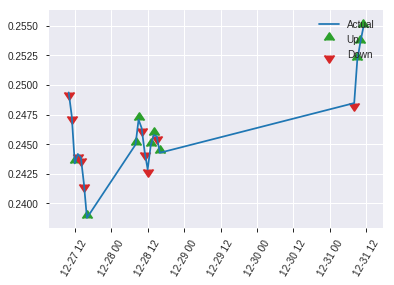


ModelMetricsBinomialGLM: glm
** Reported on test data. **

MSE: 0.2180682943321229
RMSE: 0.4669778306645005
LogLoss: 0.6254970588591722
Null degrees of freedom: 222
Residual degrees of freedom: -39
Null deviance: 308.2619463225164
Residual deviance: 278.9716882511909
AIC: 802.9716882511909
AUC: 0.7160633484162896
pr_auc: 0.7089650159636202
Gini: 0.4321266968325792
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.18337779527474923: 


0    1    Error    Rate
-----  ---  ---  -------  ------------
0      30   89   0.7479   (89.0/119.0)
1      4    100  0.0385   (4.0/104.0)
Total  34   189  0.417    (93.0/223.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.183378     0.682594  188
max f2                       0.151173     0.82658   200
max f0point5                 0.429382     0.646552  89
max accuracy                 0.429382     0.668161  89
max precision                0.849099     1         0
max recall                   0.0854515    1         217
max specificity              0.849099     1         0
max absolute_mcc             0.555022     0.340545  42
max min_per_class_accuracy   0.385012     0.663462  108
max mean_per_class_accuracy  0.381285     0.669077  111

Gains/Lift Table: Avg response rate: 46.64 %, avg score: 38.53 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0134529                   0.780436           2.14423   2.14423            1                0.810185  1                           0.810185            0.0288462       0.0288462                  114.423   114.423
    2        0.0224215                   0.733518           2.14423   2.14423            1                0.746522  1                           0.78472             0.0192308       0.0480769                  114.423   114.423
    3        0.0313901                   0.723588           2.14423   2.14423            1                0.726188  1                           0.767996            0.0192308       0.0673077                  114.423   114.423
    4        0.0403587                   0.712874           2.14423   2.14423            1                0.719026  1                           0.757114            0.0192308       0.0865385                  114.423   114.423
    5        0.0538117                   0.698175           2.14423   2.14423            1                0.704933  1                           0.744069            0.0288462       0.115385                   114.423   114.423
    6        0.103139                    0.617816           1.75437   1.95778            0.818182         0.657991  0.913043                    0.702901            0.0865385       0.201923                   75.4371   95.7776
    7        0.152466                    0.579193           1.36451   1.76584            0.636364         0.597153  0.823529                    0.668689            0.0673077       0.269231                   36.451    76.5837
    8        0.201794                    0.550296           1.36451   1.66774            0.636364         0.561747  0.777778                    0.642547            0.0673077       0.336538                   36.451    66.7735
    9        0.300448                    0.483142           0.97465   1.44015            0.454545         0.511703  0.671642                    0.599583            0.0961538       0.432692                   -2.53497  44.0155
    10       0.399103                    0.429927           1.36451   1.42146            0.636364         0.455338  0.662921                    0.563927            0.134615        0.567308                   36.451    42.1456
    11       0.502242                    0.381285           1.11873   1.35929            0.521739         0.405645  0.633929                    0.531423            0.115385        0.682692                   11.8729   35.9289
    12       0.600897                    0.326453           0.58479   1.23213            0.272727         0.35852   0.574627                    0.503036            0.0576923       0.740385                   -41.521   23.2133
    13       0.699552                    0.267135           0.682255  1.15459            0.318182         0.297492  0.538462                    0.474049            0.0673077       0.807692                   -31.7745  15.4586
    14       0.798206                    0.225925           0.877185  1.1203             0.409091         0.243159  0.522472                    0.445512            0.0865385       0.894231                   -12.2815  12.03
    15       0.896861                    0.151221           0.77972   1.08284            0.363636         0.183519  0.505                       0.416693            0.0769231       0.971154                   -22.028   8.28365
    16       1                           0.0525475          0.279682  1                  0.130435         0.112329  0.466368                    0.385301           

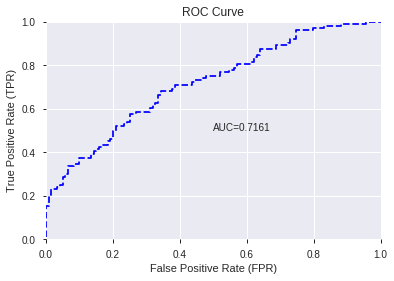

/usr/local/lib/python3.6/dist-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


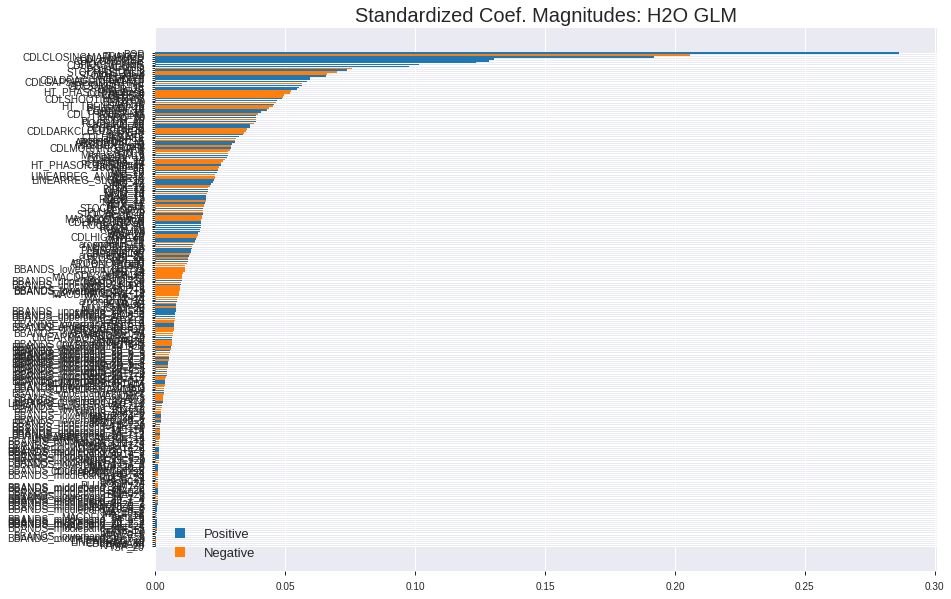

'log_likelihood'
--2019-08-27 21:48:02--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 54.231.40.195
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|54.231.40.195|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/GLM_grid_1_AutoML_20190827_214747_model_1',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'GLM_grid_1_AutoML_20190827_214747_model_1',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_106_sid_82c1',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training_py_106

['BOP',
 'TRANGE',
 'CDLCLOSINGMARUBOZU',
 'CDLHAMMER',
 'CDLLONGLINE',
 'STOCHF_fastk',
 'CDLENGULFING',
 'ADOSC',
 'PLUS_DM_8',
 'STOCHRSI_fastk',
 'PLUS_DI_8',
 'STOCH_slowd',
 'WILLR_24',
 'BETA_8',
 'CDLDRAGONFLYDOJI',
 'CDLGAPSIDESIDEWHITE',
 'AROONOSC_14',
 'CDLSHORTLINE',
 'WILLR_20',
 'WILLR_8',
 'HT_PHASOR_inphase',
 'CORREL_20',
 'CDLDOJI',
 'NATR_8',
 'CDLSHOOTINGSTAR',
 'BETA_20',
 'ATR_8',
 'HT_TRENDMODE',
 'PLUS_DI_12',
 'MFI_12',
 'CORREL_12',
 'WILLR_30',
 'CDLTHRUSTING',
 'ROC_30',
 'ROCR_30',
 'PLUS_DM_12',
 'ROCR100_30',
 'aroonup_12',
 'AD',
 'CORREL_8',
 'PLUS_DI_14',
 'CDLDARKCLOUDCOVER',
 'CCI_12',
 'ADXR_8',
 'CDLHIKKAKE',
 'aroondown_14',
 'AROONOSC_8',
 'STDDEV_20',
 'MACDEXT_hist',
 'DX_8',
 'CDLMORNINGSTAR',
 'ADX_8',
 'CCI_8',
 'MINUS_DM_8',
 'STDDEV_12',
 'CORREL_14',
 'BETA_12',
 'aroonup_20',
 'PLUS_DM_14',
 'HT_PHASOR_quadrature',
 'aroonup_24',
 'CCI_20',
 'MFI_20',
 'VAR_12',
 'LINEARREG_ANGLE_12',
 'VAR_8',
 'LINEARREG_SLOPE_12',
 'VAR_20',
 'CMO_12

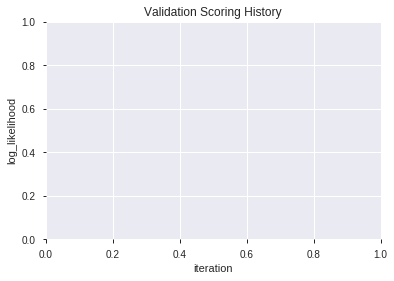

In [52]:
# GLM with recursive feature elimination with cross validation
model_train(feature_name='RFE',model_algo="GLM",features_list=features_list)

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  XGBoost_grid_1_AutoML_20190827_214811_model_4  0.767696  0.586759              0.275695  0.447548  0.200299
1               XGBoost_3_AutoML_20190827_214811  0.763736  0.591205              0.291290  0.450883  0.203296
2  XGBoost_grid_1_AutoML_20190827_214811_model_6  0.757999  0.589504              0.300259  0.449396  0.201957
3  XGBoost_grid_1_AutoML_20190827_214811_model_2  0.753232  0.602849              0.308662  0.455267  0.207268
4  XGBoost_grid_1_AutoML_20190827_214811_model_3  0.753070  0.590638              0.319449  0.450017  0.202515
5  XGBoost_grid_1_AutoML_20190827_214811_model_1  0.749273  0.586727              0.384171  0.449348  0.201914
6  XGBoost_grid_1_AutoML_20190827_214811_model_7  0.744101  0.595484              0.296097  0.452541  0.204793
7  XGBoost_grid_1_AutoML_20190827_214811_model_5  0.738526  0.604480              0.320661  0.456346  0.208252
8               XGBoost_2_AutoML_20190827_214811  0.738041  0.612443              0.358436  0.459973  0.211575
9               XGBoost_1_AutoML_20190827_214811  0.735537  0.609976              0.332054  0.459487  0.211128

variable  relative_importance  scaled_importance  percentage
0             BOP          1667.376953           1.000000    0.331633
1          TRANGE           749.887207           0.449741    0.149149
2    STOCHF_fastk           244.435074           0.146599    0.048617
3           ADOSC           100.472481           0.060258    0.019983
4         WILLR_8            83.256676           0.049933    0.016559
..            ...                  ...                ...         ...
109         MOM_8             4.825819           0.002894    0.000960
110    aroonup_30             4.795338           0.002876    0.000954
111        RSI_24             3.942415           0.002364    0.000784
112   MINUS_DM_24             3.693378           0.002215    0.000735
113       NATR_24             3.497448           0.002098    0.000696

[114 rows x 4 columns]

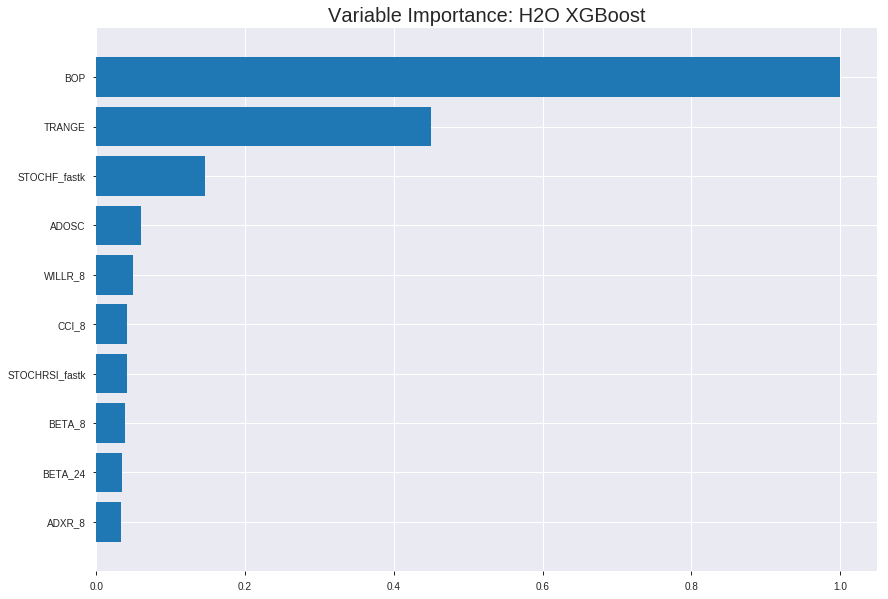

Model Details
H2OXGBoostEstimator :  XGBoost
Model Key:  XGBoost_grid_1_AutoML_20190827_214811_model_4


ModelMetricsBinomial: xgboost
** Reported on train data. **

MSE: 0.17044791784236457
RMSE: 0.41285338540741623
LogLoss: 0.517483146750638
Mean Per-Class Error: 0.24194749086075107
AUC: 0.8392464273845132
pr_auc: 0.8105286220534186
Gini: 0.6784928547690263
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.38139618720327106: 


0    1    Error    Rate
-----  ---  ---  -------  --------------
0      528  322  0.3788   (322.0/850.0)
1      95   613  0.1342   (95.0/708.0)
Total  623  935  0.2677   (417.0/1558.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.381396     0.746196  246
max f2                       0.292493     0.844221  296
max f0point5                 0.567949     0.753138  145
max accuracy                 0.498668     0.761232  184
max precision                0.866776     1         0
max recall                   0.163724     1         362
max specificity              0.866776     1         0
max absolute_mcc             0.498668     0.5175    184
max min_per_class_accuracy   0.475325     0.749412  198
max mean_per_class_accuracy  0.498668     0.758053  184

Gains/Lift Table: Avg response rate: 45.44 %, avg score: 45.69 %



group    cumulative_data_fraction    lower_threshold    lift       cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  ---------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0102696                   0.827567           2.20056    2.20056            1                0.846733  1                           0.846733            0.0225989       0.0225989                  120.056   120.056
    2        0.0205392                   0.809299           2.06303    2.1318             0.9375           0.819809  0.96875                     0.833271            0.0211864       0.0437853                  106.303   113.18
    3        0.0301669                   0.793728           2.20056    2.15374            1                0.802688  0.978723                    0.823511            0.0211864       0.0649718                  120.056   115.374
    4        0.0404365                   0.783499           2.20056    2.16564            1                0.789308  0.984127                    0.814824            0.0225989       0.0875706                  120.056   116.564
    5        0.0500642                   0.777672           2.20056    2.17235            1                0.780625  0.987179                    0.808247            0.0211864       0.108757                   120.056   117.235
    6        0.100128                    0.733865           1.97487    2.07361            0.897436         0.755477  0.942308                    0.781862            0.0988701       0.207627                   97.4866   107.361
    7        0.150193                    0.69699            1.74917    1.96546            0.794872         0.716972  0.893162                    0.760232            0.0875706       0.295198                   74.9167   96.5462
    8        0.200257                    0.667355           1.72095    1.90434            0.782051         0.681833  0.865385                    0.740632            0.0861582       0.381356                   72.0955   90.4335
    9        0.300385                    0.596548           1.56579    1.79149            0.711538         0.633695  0.814103                    0.704987            0.15678         0.538136                   56.5787   79.1486
    10       0.399872                    0.529236           1.34873    1.68133            0.612903         0.564427  0.764045                    0.670016            0.134181        0.672316                   34.8733   68.1331
    11       0.5                         0.457127           1.00154    1.5452             0.455128         0.493309  0.702182                    0.634629            0.100282        0.772599                   0.153919  54.5198
    12       0.600128                    0.380589           0.931008   1.44272            0.423077         0.420298  0.655615                    0.598869            0.0932203       0.865819                   -6.89917  44.2723
    13       0.699615                    0.315593           0.582085   1.32034            0.264516         0.347118  0.6                         0.56307             0.0579096       0.923729                   -41.7915  32.0339
    14       0.799743                    0.248602           0.465504   1.21331            0.211538         0.283626  0.551364                    0.528083            0.0466102       0.970339                   -53.4496  21.3313
    15       0.899872                    0.174635           0.282124   1.1097             0.128205         0.209019  0.50428                     0.492581            0.0282486       0.998588                   -71.7876  10.97
    16       1                           0.0831459          0.0141062  1                  0.00641026       0.135759  0.454429                    0.



ModelMetricsBinomial: xgboost
** Reported on validation data. **

MSE: 0.19756298943077188
RMSE: 0.44448058386252587
LogLoss: 0.577607520397505
Mean Per-Class Error: 0.23641182922370718
AUC: 0.7843563391152455
pr_auc: 0.6927987456143847
Gini: 0.568712678230491
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.339688241481781: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      155  84   0.3515   (84.0/239.0)
1      25   181  0.1214   (25.0/206.0)
Total  180  265  0.2449   (109.0/445.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.339688     0.768577  239
max f2                       0.22088      0.84399   311
max f0point5                 0.362459     0.714876  226
max accuracy                 0.339688     0.755056  239
max precision                0.787963     1         0
max recall                   0.0996929    1         395
max specificity              0.787963     1         0
max absolute_mcc             0.339688     0.535586  239
max min_per_class_accuracy   0.409272     0.732218  194
max mean_per_class_accuracy  0.339688     0.763588  239

Gains/Lift Table: Avg response rate: 46.29 %, avg score: 39.71 %



group    cumulative_data_fraction    lower_threshold    lift       cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  ---------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.011236                    0.737504           1.29612    1.29612            0.6              0.755068  0.6                         0.755068            0.0145631       0.0145631                  29.6117   29.6117
    2        0.0202247                   0.720588           1.62015    1.44013            0.75             0.72994   0.666667                    0.7439              0.0145631       0.0291262                  62.0146   44.0129
    3        0.0314607                   0.703395           2.16019    1.6973             1                0.713271  0.785714                    0.732961            0.0242718       0.0533981                  116.019   69.7295
    4        0.0404494                   0.696599           1.62015    1.68015            0.75             0.699177  0.777778                    0.725453            0.0145631       0.0679612                  62.0146   68.0151
    5        0.0516854                   0.677067           1.29612    1.59667            0.6              0.687869  0.73913                     0.717283            0.0145631       0.0825243                  29.6117   59.6665
    6        0.101124                    0.648125           1.47286    1.53614            0.681818         0.662301  0.711111                    0.690403            0.0728155       0.15534                    47.286    53.6138
    7        0.150562                    0.607171           1.47286    1.51536            0.681818         0.629617  0.701493                    0.670444            0.0728155       0.228155                   47.286    51.536
    8        0.2                         0.572235           1.66924    1.5534             0.772727         0.58792   0.719101                    0.650044            0.0825243       0.31068                    66.9241   55.3398
    9        0.301124                    0.518215           1.53614    1.5476             0.711111         0.543943  0.716418                    0.614413            0.15534         0.466019                   53.6138   54.7602
    10       0.4                         0.460539           1.37467    1.50485            0.636364         0.485123  0.696629                    0.582454            0.135922        0.601942                   37.4669   50.4854
    11       0.501124                    0.39883            1.48813    1.50148            0.688889         0.427289  0.695067                    0.551143            0.150485        0.752427                   48.8134   50.148
    12       0.6                         0.336651           1.27648    1.4644             0.590909         0.36836   0.677903                    0.521021            0.126214        0.878641                   27.6478   46.4401
    13       0.698876                    0.272109           0.392763   1.31279            0.181818         0.30423   0.607717                    0.49035             0.038835        0.917476                   -60.7237  31.2787
    14       0.8                         0.21096            0.480043   1.20752            0.222222         0.242619  0.558989                    0.459035            0.0485437       0.966019                   -51.9957  20.7524
    15       0.898876                    0.150011           0.0981906  1.0855             0.0454545        0.173045  0.5025                      0.427576            0.00970874      0.975728                   -90.1809  8.54976
    16       1                           0.0872082          0.240022   1                  0.111111         0.126362  0.462921                    0


Scoring History: 


timestamp            duration    number_of_trees    training_rmse    training_logloss    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------  -----------------  ---------------  ------------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-08-27 21:48:25  5.571 sec   0                  0.5              0.693147            0.5             0                  1                0.545571                         0.5                0.693147              0.5               0                    1                  0.537079
    2019-08-27 21:48:25  5.875 sec   5                  0.47894          0.651673            0.780163        0.739094           2.06303          0.320924                         0.479816           0.653373              0.787444          0.725326             2.16019            0.244944
    2019-08-27 21:48:25  5.981 sec   10                 0.464285         0.623036            0.787606        0.747427           2.20056          0.302953                         0.464049           0.622567              0.800087          0.728302             1.72816            0.238202
    2019-08-27 21:48:25  6.103 sec   15                 0.453938         0.602542            0.79313         0.755688           2.20056          0.300385                         0.456654           0.607603              0.797051          0.728384             2.16019            0.233708
    2019-08-27 21:48:25  6.211 sec   20                 0.445981         0.586445            0.798164        0.758427           2.20056          0.303594                         0.451762           0.597195              0.795822          0.728192             2.16019            0.244944
    2019-08-27 21:48:25  6.346 sec   25                 0.440038         0.574062            0.802377        0.768457           2.20056          0.286264                         0.447803           0.588505              0.794949          0.724343             2.16019            0.247191
    2019-08-27 21:48:26  6.467 sec   30                 0.435399         0.564258            0.805973        0.770779           2.20056          0.287548                         0.446001           0.58408               0.793669          0.719682             2.16019            0.249438
    2019-08-27 21:48:26  6.591 sec   35                 0.431467         0.556028            0.811752        0.7807             2.20056          0.28819                          0.444006           0.579436              0.793639          0.725713             2.16019            0.247191
    2019-08-27 21:48:26  6.710 sec   40                 0.427761         0.54821             0.81625         0.786143           2.20056          0.278562                         0.443025           0.577235              0.790886          0.719704             2.16019            0.260674
    2019-08-27 21:48:26  6.872 sec   45                 0.424274         0.541049            0.821728        0.792666           2.20056          0.277279                         0.442706           0.576126              0.789851          0.715332             2.16019            0.249438
    2019-08-27 21:48:26  6.999 sec   50                 0.421037         0.534188            0.826026        0.796606           2.20056          0.274069                         0.441535           0.573325              0.790724          0.721793             2.16019            0.247191
    2019-08-27 21:48:26  7.124 sec   55                 0.418437         0.528757            0.829677        0.800611           2.20056          0.287548                         0.441874           0.57339               0.78916           0

Variable Importances: 


variable      relative_importance    scaled_importance      percentage
------------  ---------------------  ---------------------  ---------------------
BOP           1667.376953125         1.0                    0.33163295216551475
TRANGE        749.88720703125        0.4497406573995223     0.14914882192226295
STOCHF_fastk  244.43507385253906     0.14659856812487335    0.04861691593048908
ADOSC         100.47248077392578     0.06025780828121687    0.019983474851323554
WILLR_8       83.25667572021484      0.049932725508874926   0.016559337170178497
---           ---                    ---                    ---
MOM_8         4.82581901550293       0.0028942579579610797  0.0009598313109271672
aroonup_30    4.795337677001953      0.0028759769457137605  0.0009537687248670146
RSI_24        3.942415237426758      0.0023644414839954927  0.0007841267095600358
MINUS_DM_24   3.693378448486328      0.002215083062989562   0.0007345945354710593
NATR_24       3.497447967529297      0.0020975748531094755  0.0006956249409248413


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.726457399103139)

('F1', 0.7024390243902439)

('auc', 0.7676955397543632)

('logloss', 0.5867588060782478)

('mean_per_class_error', 0.2756948933419522)

('rmse', 0.44754782944533167)

('mse', 0.20029905964122768)

xgboost prediction progress: |████████████████████████████████████████████| 100%


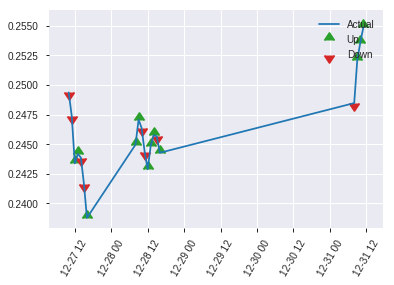


ModelMetricsBinomial: xgboost
** Reported on test data. **

MSE: 0.20029905964122768
RMSE: 0.44754782944533167
LogLoss: 0.5867588060782478
Mean Per-Class Error: 0.2756948933419522
AUC: 0.7676955397543632
pr_auc: 0.7334404428960841
Gini: 0.5353910795087264
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4412849545478821: 


0    1    Error    Rate
-----  ---  ---  -------  ------------
0      90   29   0.2437   (29.0/119.0)
1      32   72   0.3077   (32.0/104.0)
Total  122  101  0.2735   (61.0/223.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.441285     0.702439  100
max f2                       0.206246     0.829228  192
max f0point5                 0.516728     0.721649  70
max accuracy                 0.453266     0.726457  96
max precision                0.781325     1         0
max recall                   0.123358     1         215
max specificity              0.781325     1         0
max absolute_mcc             0.441285     0.449592  100
max min_per_class_accuracy   0.432078     0.705882  108
max mean_per_class_accuracy  0.441285     0.724305  100

Gains/Lift Table: Avg response rate: 46.64 %, avg score: 42.43 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0134529                   0.759124           2.14423   2.14423            1                0.773111  1                           0.773111            0.0288462       0.0288462                  114.423   114.423
    2        0.0224215                   0.751923           2.14423   2.14423            1                0.757108  1                           0.76671             0.0192308       0.0480769                  114.423   114.423
    3        0.0313901                   0.746378           0         1.53159            0                0.747281  0.714286                    0.761159            0               0.0480769                  -100      53.1593
    4        0.0403587                   0.728183           2.14423   1.66774            1                0.737207  0.777778                    0.755836            0.0192308       0.0673077                  114.423   66.7735
    5        0.0538117                   0.723956           1.42949   1.60817            0.666667         0.726542  0.75                        0.748513            0.0192308       0.0865385                  42.9487   60.8173
    6        0.103139                    0.671643           2.14423   1.86455            1                0.69414   0.869565                    0.722508            0.105769        0.192308                   114.423   86.4548
    7        0.152466                    0.636221           1.9493    1.89197            0.909091         0.652527  0.882353                    0.699867            0.0961538       0.288462                   94.9301   89.1968
    8        0.201794                    0.59707            1.55944   1.81068            0.727273         0.615023  0.844444                    0.679127            0.0769231       0.365385                   55.9441   81.0684
    9        0.300448                    0.530155           1.46198   1.69618            0.681818         0.557673  0.791045                    0.639247            0.144231        0.509615                   46.1976   69.6183
    10       0.399103                    0.469277           1.07212   1.54192            0.5              0.493018  0.719101                    0.6031              0.105769        0.615385                   7.21154   54.1919
    11       0.502242                    0.423795           0.932274  1.41672            0.434783         0.445392  0.660714                    0.570714            0.0961538       0.711538                   -6.77258  41.6724
    12       0.600897                    0.378722           0.77972   1.31214            0.363636         0.401769  0.61194                     0.542977            0.0769231       0.788462                   -22.028   31.2141
    13       0.699552                    0.314476           0.58479   1.20957            0.272727         0.351836  0.564103                    0.516021            0.0576923       0.846154                   -41.521   20.9566
    14       0.798206                    0.248675           0.877185  1.16849            0.409091         0.28012   0.544944                    0.486865            0.0865385       0.932692                   -12.2815  16.8485
    15       0.896861                    0.178124           0.38986   1.08284            0.181818         0.218793  0.505                       0.457377            0.0384615       0.971154                   -61.014   8.28365
    16       1                           0.0915175          0.279682  1                  0.130435         0.136613  0.466368                    0.424293         

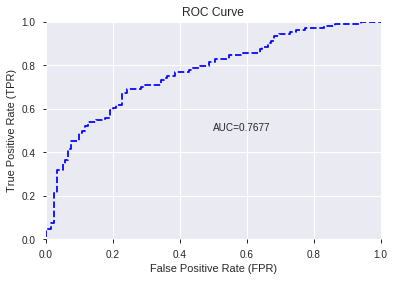

This function is available for GLM models only


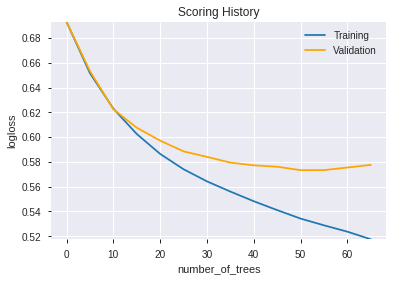

--2019-08-27 21:48:41--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.170.51
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.170.51|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
log4j:WARN No appenders could be found for logger (ml.dmlc.xgboost4j.java.Booster).
log4j:WARN Please initialize the log4j system properly.
log4j:WARN See http://logging.apache.org/log4j/1.2/faq.html#noconfig for more info.
Exception in thread "main" java.lang.StackOverflowError
	at java.base/java.lang.String.indexOf(String.java:1578)
	at java.base/java.lang.String.indexOf(String.java:1535)
	at java.base/java.lang.String.split(String.java:2274)
	at java.base/java.lang.String.split(String.java:2364)
	at hex.genmodel.algos.xgboost.XGBoostMojoMode

[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/XGBoost_grid_1_AutoML_20190827_214811_model_4',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'XGBoost_grid_1_AutoML_20190827_214811_model_4',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_114_sid_82c1',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_trainin

['BOP',
 'TRANGE',
 'STOCHF_fastk',
 'ADOSC',
 'WILLR_8',
 'CCI_8',
 'STOCHRSI_fastk',
 'BETA_8',
 'BETA_24',
 'ADXR_8',
 'LINEARREG_ANGLE_12',
 'PLUS_DM_20',
 'ROC_24',
 'BETA_20',
 'HT_PHASOR_quadrature',
 'ADX_8',
 'PLUS_DM_30',
 'HT_DCPERIOD',
 'ATR_24',
 'MFI_20',
 'CCI_14',
 'STDDEV_8',
 'PLUS_DI_8',
 'ROCP_8',
 'BETA_12',
 'aroonup_12',
 'PLUS_DM_14',
 'DX_24',
 'STDDEV_14',
 'AD',
 'MACDEXT_hist',
 'HT_PHASOR_inphase',
 'MINUS_DM_8',
 'PLUS_DM_12',
 'WILLR_30',
 'MACDFIX_hist_24',
 'MINUS_DI_14',
 'PLUS_DI_24',
 'CORREL_20',
 'LINEARREG_ANGLE_8',
 'WILLR_24',
 'STOCH_slowk',
 'AROONOSC_20',
 'DX_8',
 'aroonup_24',
 'aroondown_24',
 'MFI_12',
 'BBANDS_upperband_14_7_4',
 'CCI_12',
 'MFI_14',
 'STDDEV_20',
 'PLUS_DM_8',
 'CORREL_14',
 'BBANDS_lowerband_20_2_5',
 'PLUS_DI_20',
 'ROC_20',
 'TSF_14',
 'aroondown_14',
 'BETA_14',
 'MACDFIX_signal_14',
 'STOCH_slowd',
 'aroondown_30',
 'HT_TRENDMODE',
 'CDLLONGLINE',
 'BBANDS_upperband_30_2_4',
 'BBANDS_upperband_20_0_3',
 'AROONOSC_3

In [53]:
# XGBoost with recursive feature elimination with cross validation
model_train(feature_name='RFE',model_algo="XGBoost",features_list=features_list)

In [54]:
# Experiment Summary
pd.set_option('precision', 3) 

for k in models_summary:
  print(k)
  display(models_summary[k].max())
  print('\n'*3)
  display(models_summary[k].groupby(models_summary[k].index).max())
  print('\n'*3)
  
display(models_summary)

pd.set_option('precision', 6) 

accuracy


DeepLearning    0.726
GLM             0.717
XGBoost         0.740
dtype: float64

DeepLearning    GLM  XGBoost
All          0.686  0.664    0.740
DLF          0.726  0.717    0.713
Fwe          0.722  0.717    0.717
RFE          0.668  0.668    0.726
XGBF         0.717  0.717    0.713





F1


DeepLearning    0.715
GLM             0.697
XGBoost         0.718
dtype: float64

DeepLearning    GLM  XGBoost
All          0.686  0.684    0.718
DLF          0.691  0.686    0.706
Fwe          0.715  0.697    0.709
RFE          0.674  0.683    0.702
XGBF         0.695  0.686    0.706





auc


DeepLearning    0.772
GLM             0.751
XGBoost         0.773
dtype: float64

DeepLearning    GLM  XGBoost
All          0.736  0.722    0.773
DLF          0.759  0.751    0.770
Fwe          0.772  0.748    0.771
RFE          0.702  0.716    0.768
XGBF         0.757  0.751    0.770





logloss


DeepLearning    0.652
GLM             0.625
XGBoost         0.601
dtype: float64

DeepLearning    GLM  XGBoost
All          0.652  0.620    0.601
DLF          0.632  0.597    0.596
Fwe          0.607  0.611    0.594
RFE          0.646  0.625    0.587
XGBF         0.614  0.597    0.596





mean_per_class_error


DeepLearning    0.338
GLM             0.345
XGBoost         0.290
dtype: float64

DeepLearning    GLM  XGBoost
All          0.326  0.345    0.268
DLF          0.285  0.293    0.290
Fwe          0.284  0.290    0.288
RFE          0.338  0.331    0.276
XGBF         0.294  0.293    0.290





rmse


DeepLearning    0.479
GLM             0.467
XGBoost         0.455
dtype: float64

DeepLearning    GLM  XGBoost
All          0.479  0.465    0.455
DLF          0.462  0.454    0.453
Fwe          0.460  0.461    0.452
RFE          0.478  0.467    0.448
XGBF         0.454  0.454    0.453





mse


DeepLearning    0.230
GLM             0.218
XGBoost         0.207
dtype: float64

DeepLearning    GLM  XGBoost
All          0.230  0.216    0.207
DLF          0.214  0.206    0.205
Fwe          0.211  0.212    0.204
RFE          0.228  0.218    0.200
XGBF         0.206  0.206    0.205

{'F1':       DeepLearning    GLM  XGBoost
 All          0.686    NaN      NaN
 DLF          0.691    NaN      NaN
 DLF            NaN  0.686      NaN
 DLF            NaN    NaN    0.706
 All            NaN  0.684      NaN
 All            NaN    NaN    0.718
 XGBF         0.695    NaN      NaN
 XGBF           NaN  0.686      NaN
 XGBF           NaN    NaN    0.706
 Fwe          0.715    NaN      NaN
 Fwe            NaN  0.697      NaN
 Fwe            NaN    NaN    0.709
 RFE          0.674    NaN      NaN
 RFE            NaN  0.683      NaN
 RFE            NaN    NaN    0.702,
 'accuracy':       DeepLearning    GLM  XGBoost
 All          0.686    NaN      NaN
 DLF          0.726    NaN      NaN
 DLF            NaN  0.717      NaN
 DLF            NaN    NaN    0.713
 All            NaN  0.664      NaN
 All            NaN    NaN    0.740
 XGBF         0.717    NaN      NaN
 XGBF           NaN  0.717      NaN
 XGBF           NaN    NaN    0.713
 Fwe          0.722    NaN      NaN
 Fwe     